In [1]:
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from numpy.random import default_rng
import warnings
from sklearn.metrics import mean_squared_error

from hopfield import HopfieldNetwork

rand_gen = default_rng()

# plt.rcParams.update({'lines.markeredgewidth': 1})
sns.set(palette='Dark2')
sns.set_context('paper' , font_scale=1.0)
pylab.rcParams['figure.dpi'] = 300

nn = HopfieldNetwork()

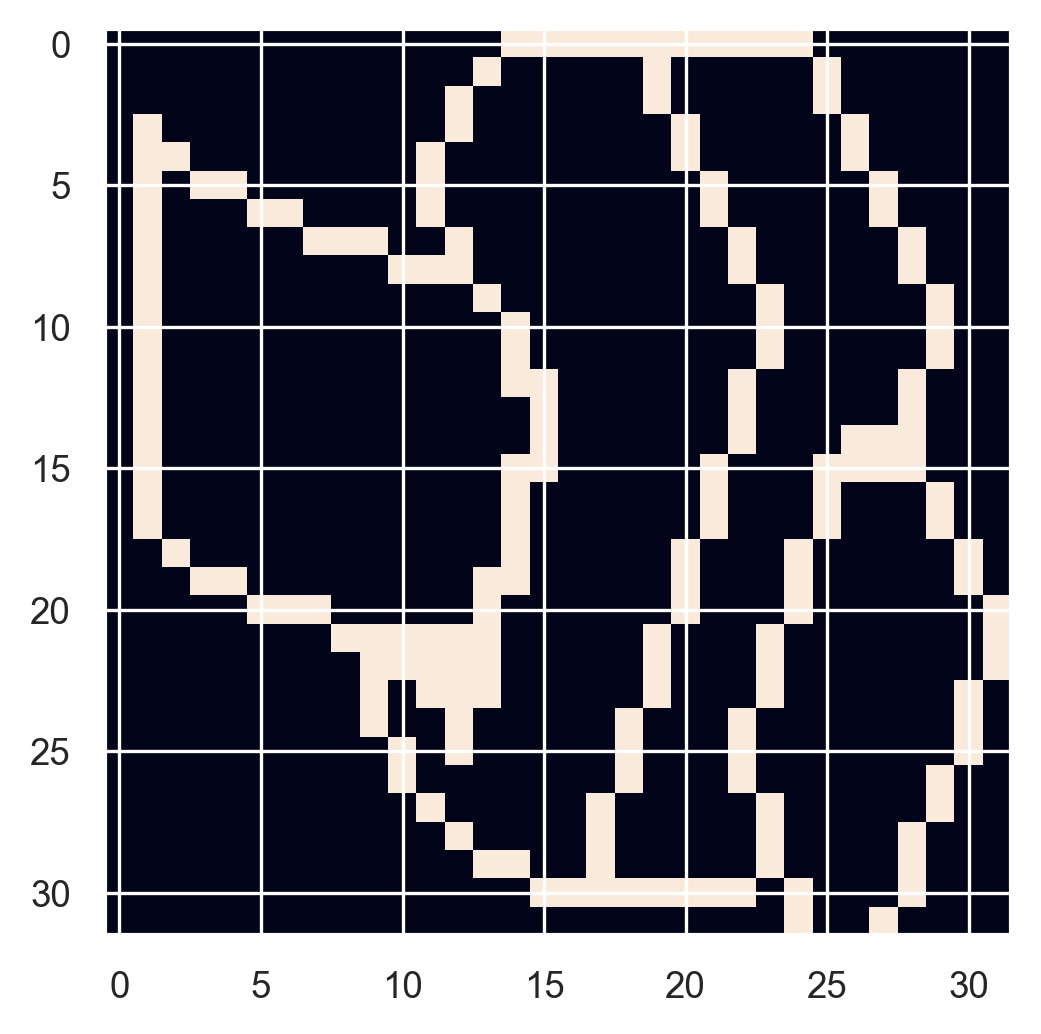

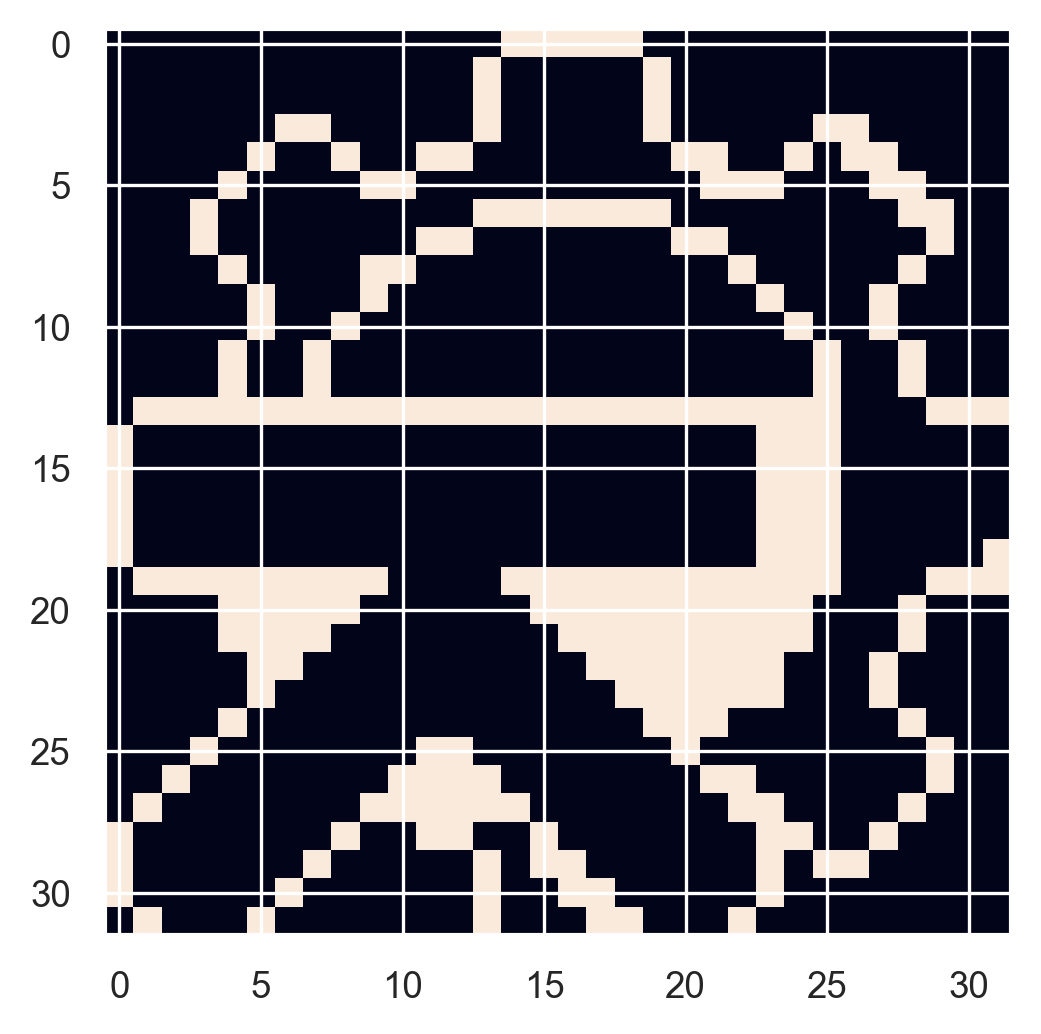

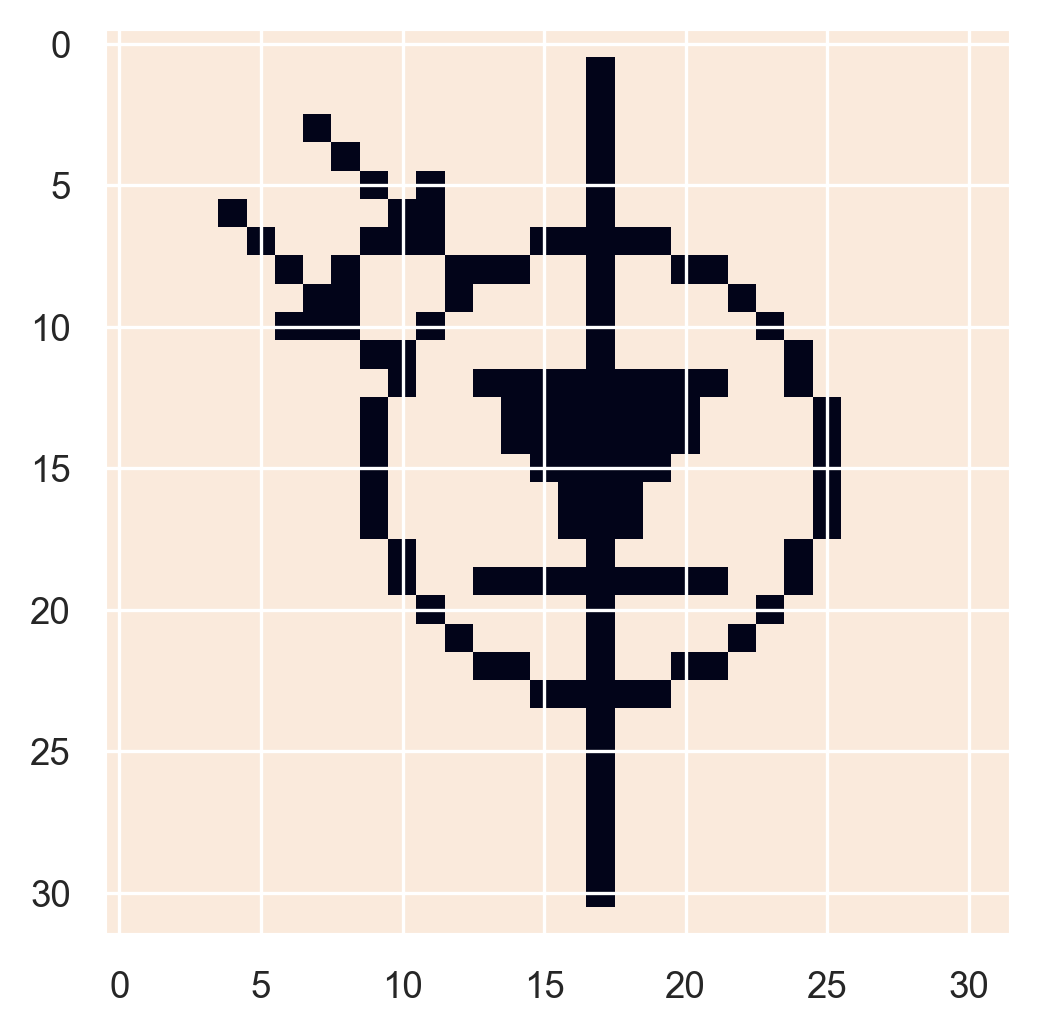

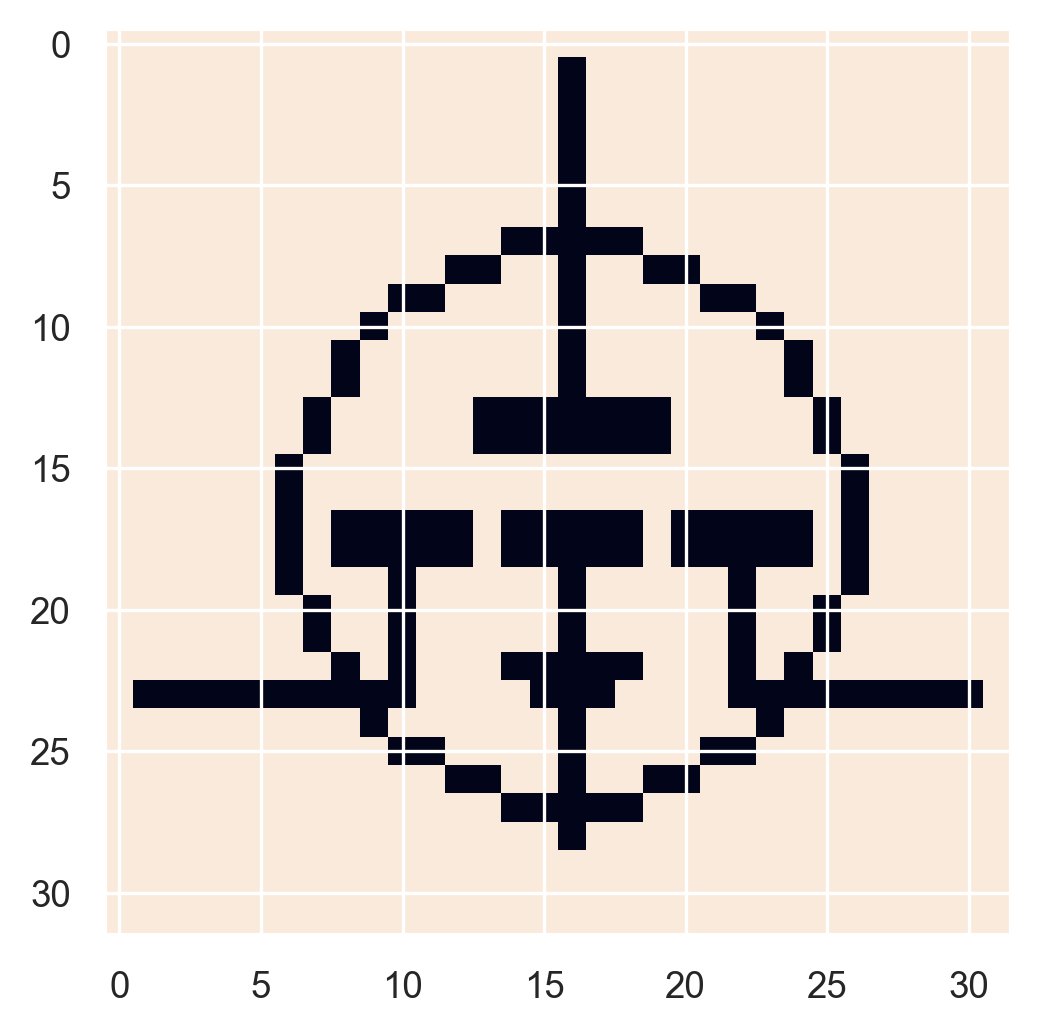

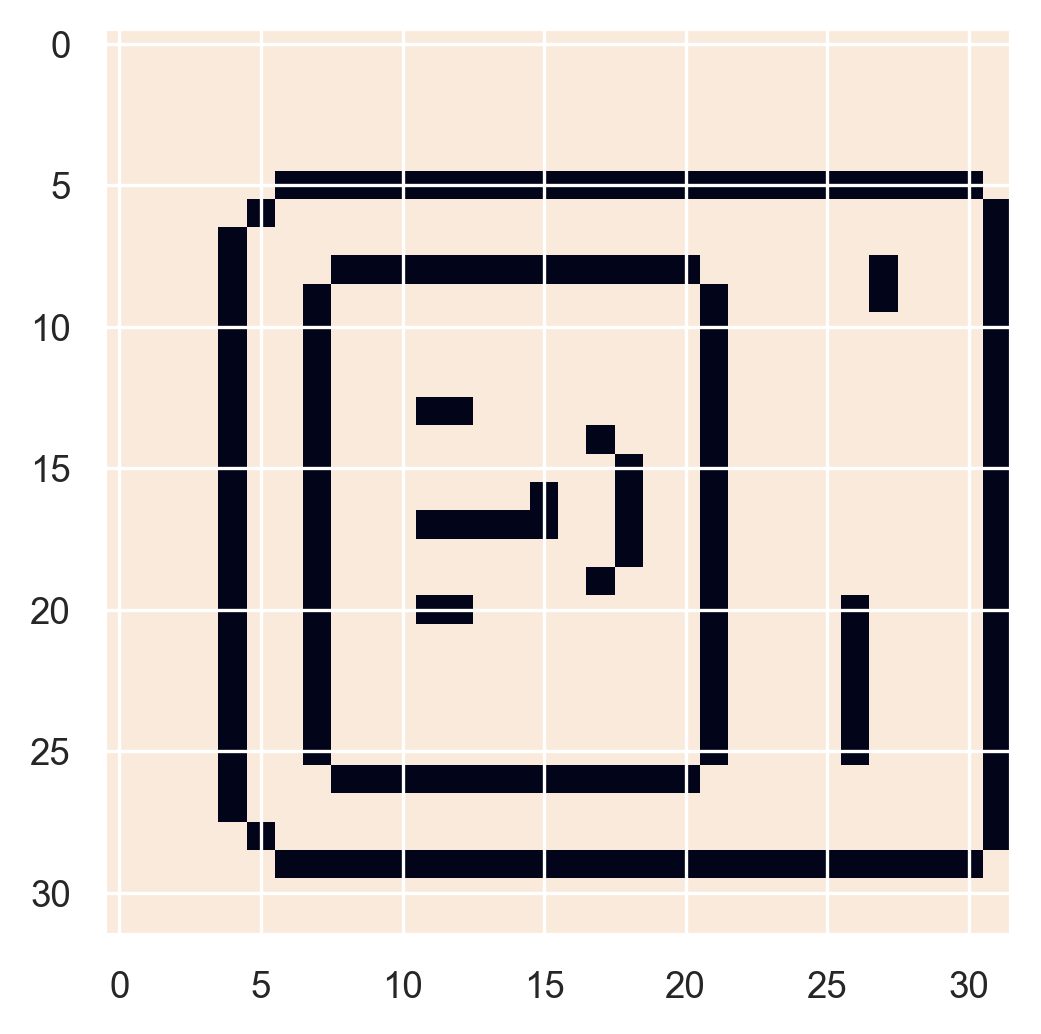

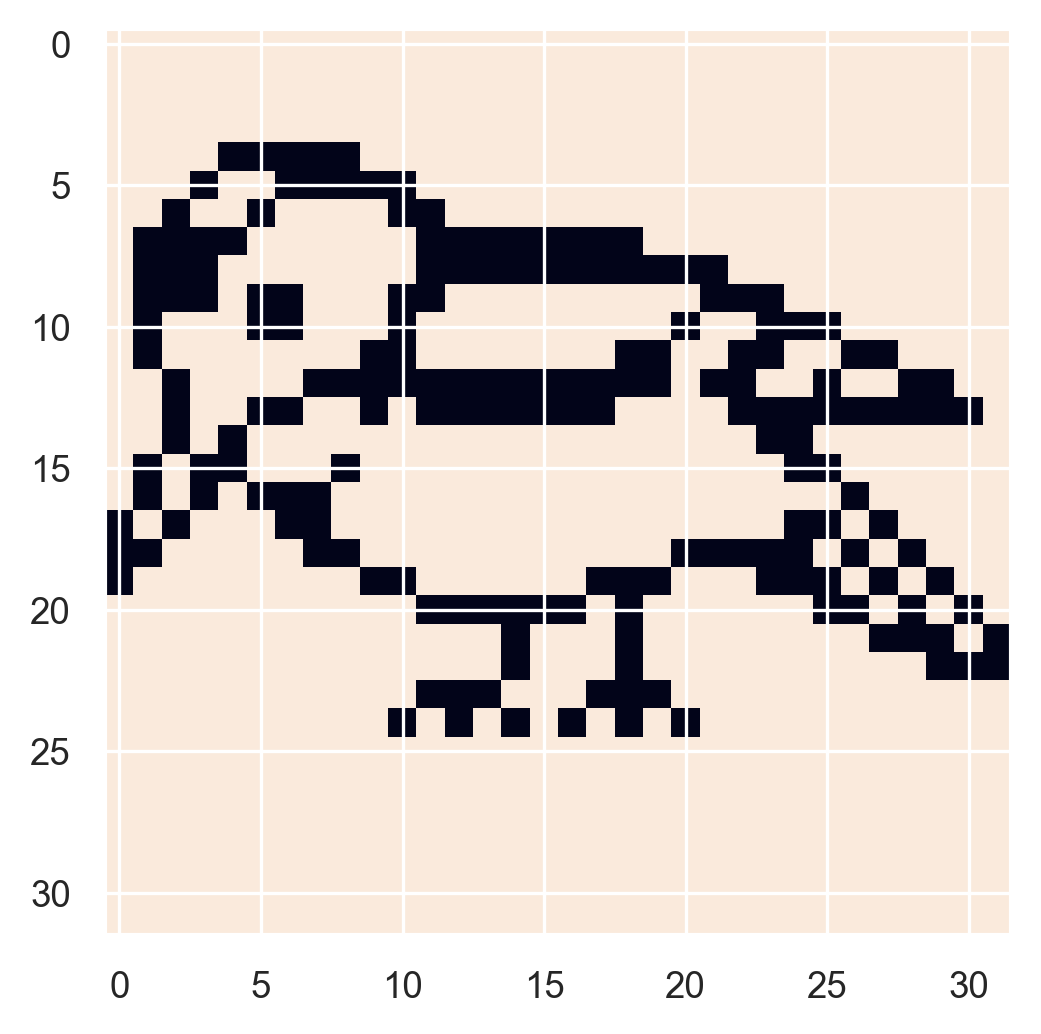

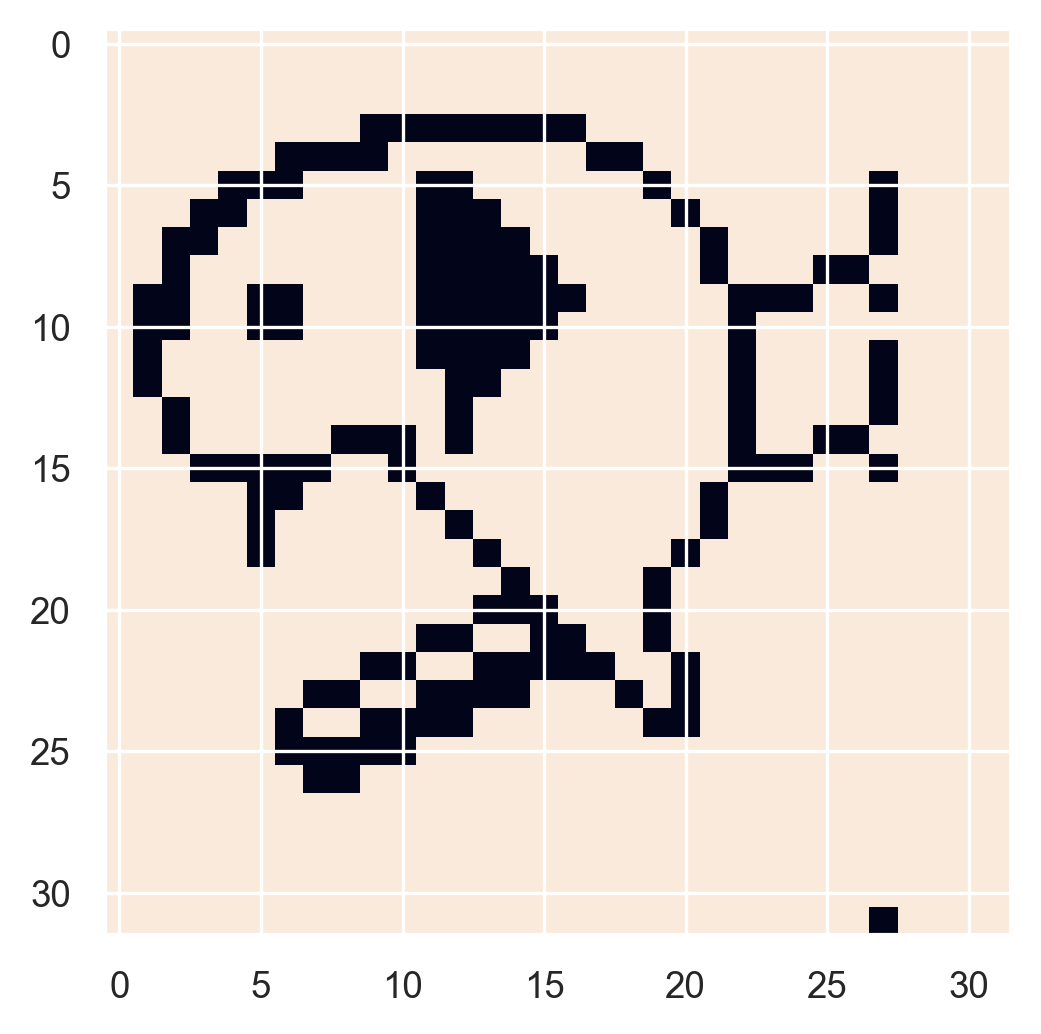

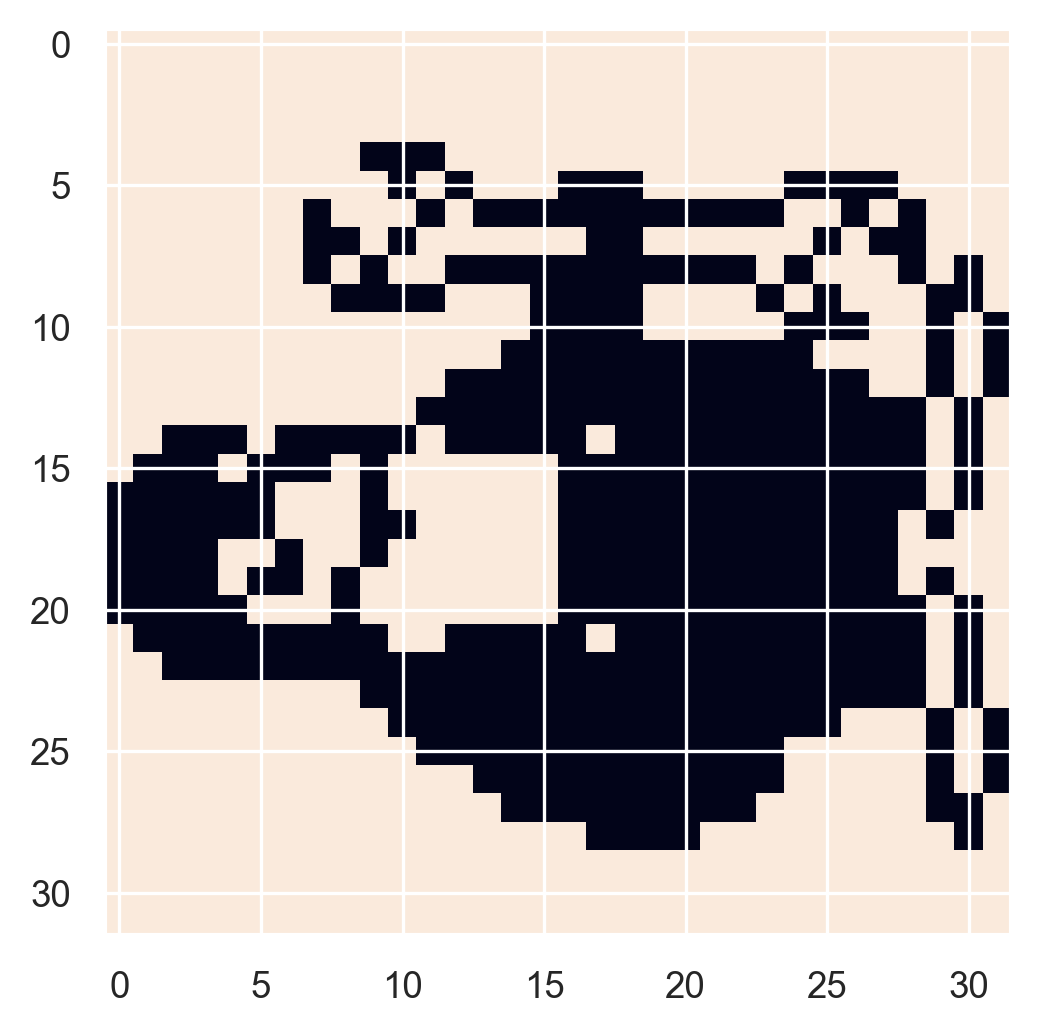

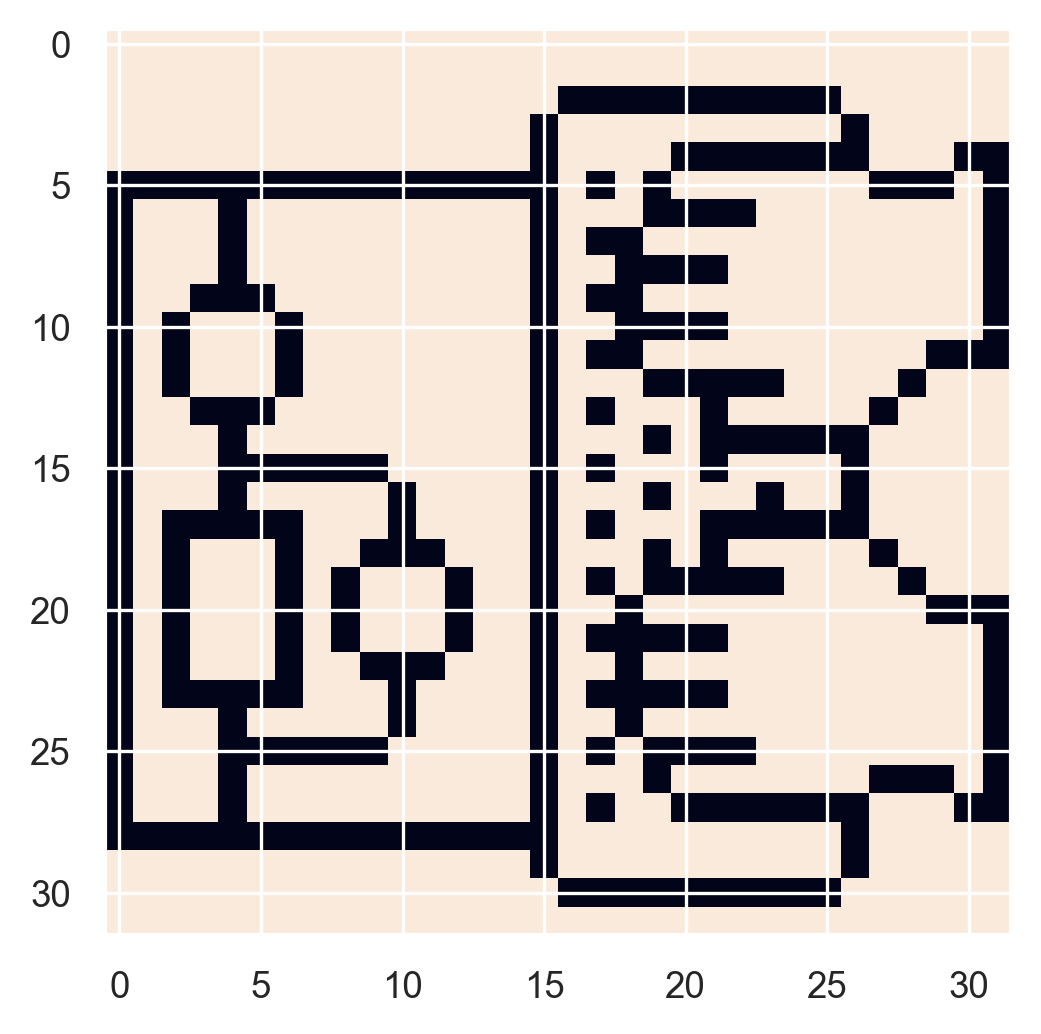

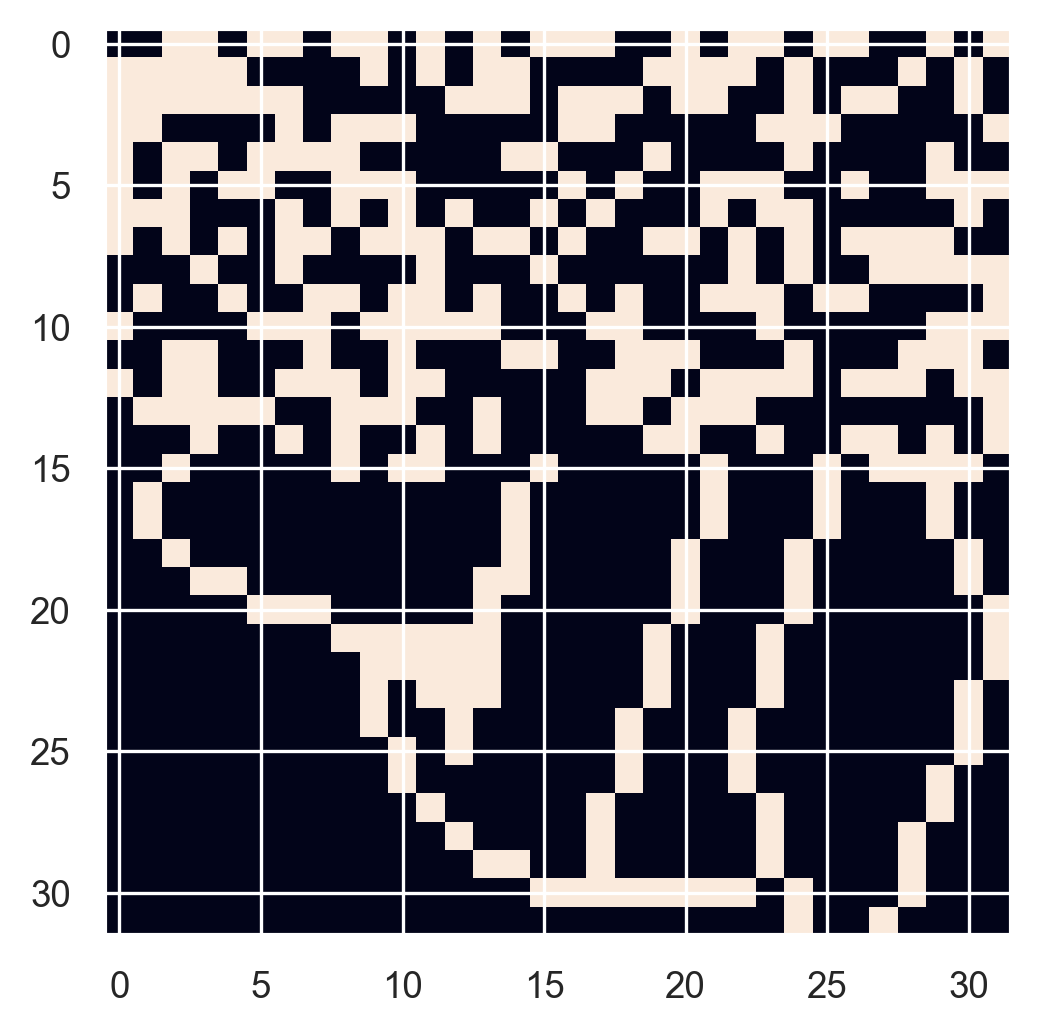

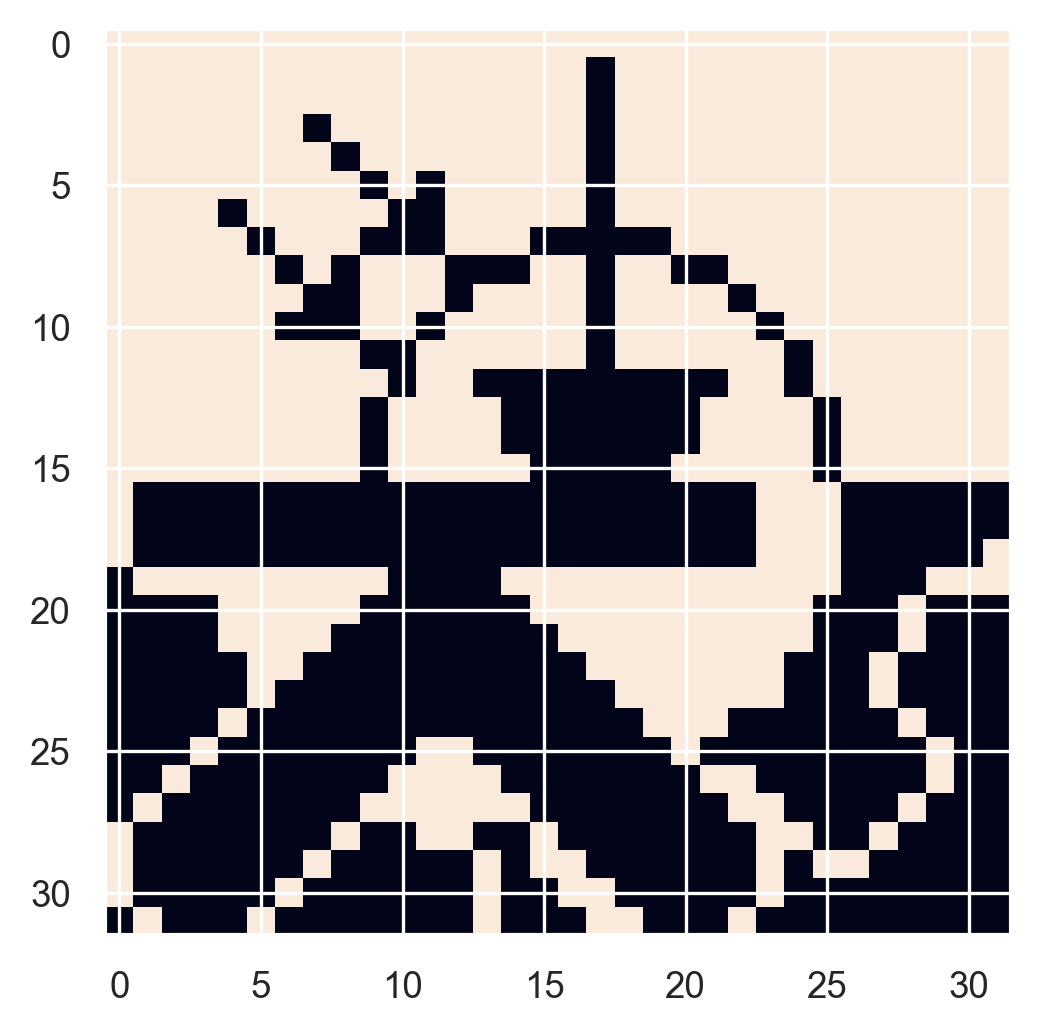

In [2]:
# load data
patterns = np.loadtxt('pict.dat', delimiter=',', dtype='int32').reshape((11, 1024))
for pattern in patterns:
    p = pattern.copy().reshape((32, 32))
    fig, ax = plt.subplots()
    ax.imshow(p)
    plt.show()

In [3]:
nn.train(patterns[:3, :])

# make sure patterns are stable
Xp = nn.recall(patterns[:3, :])
assert np.all(Xp == patterns[:3, :])
print(Xp == patterns[:3, :])

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


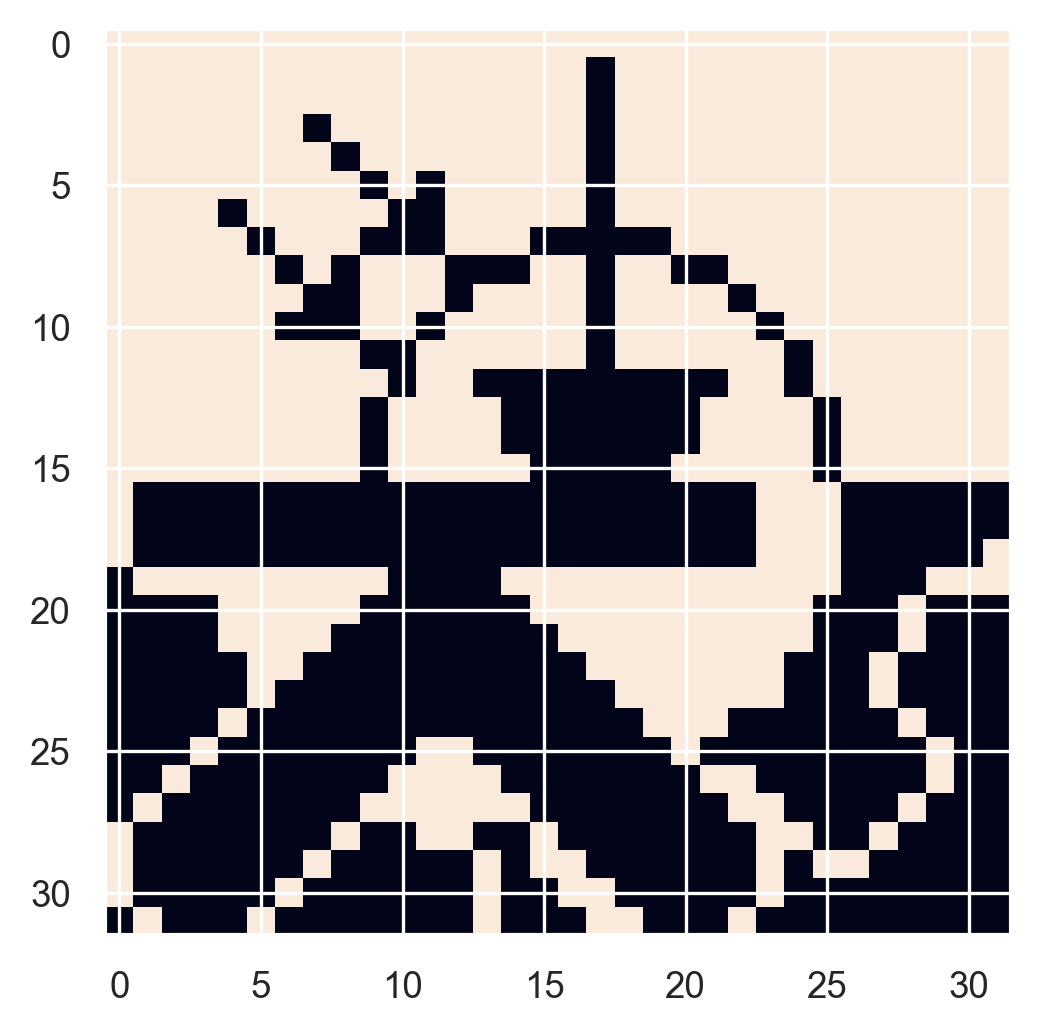

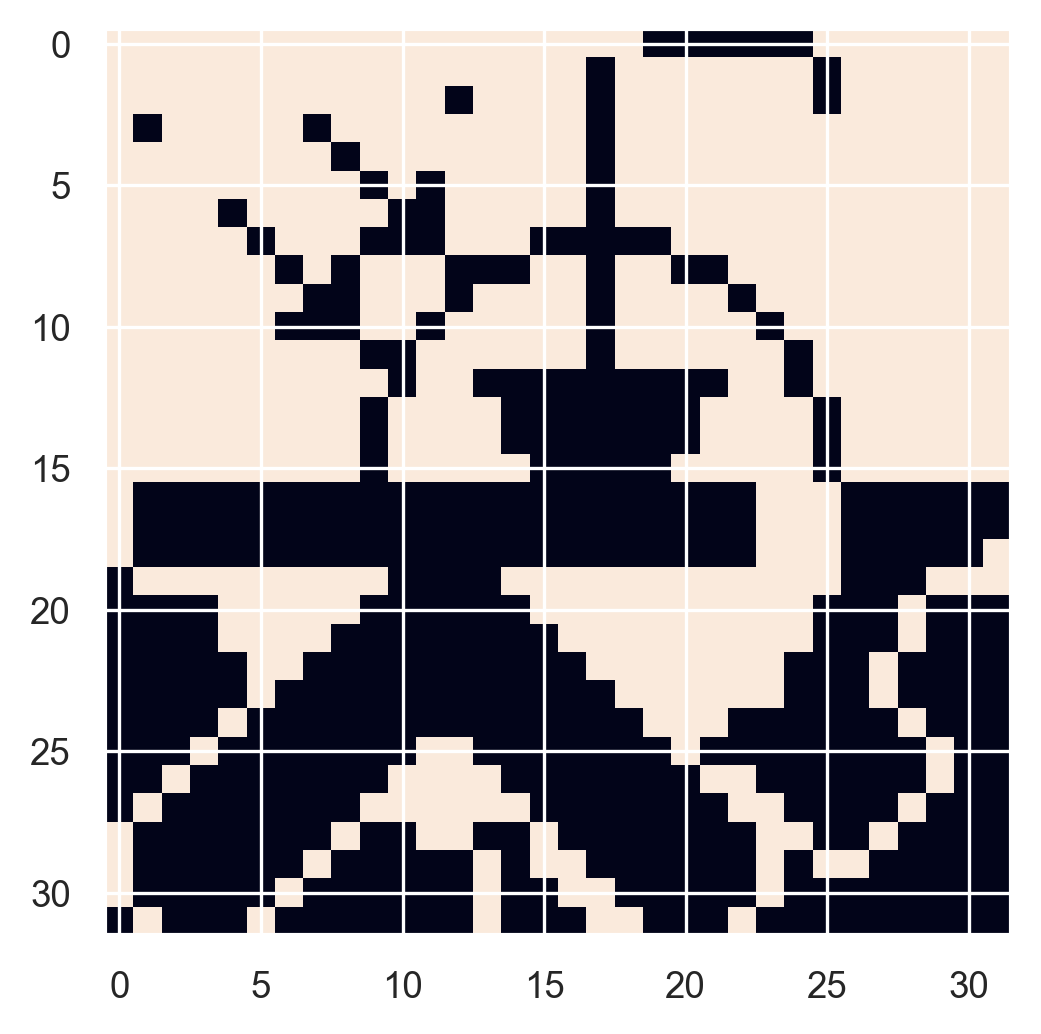

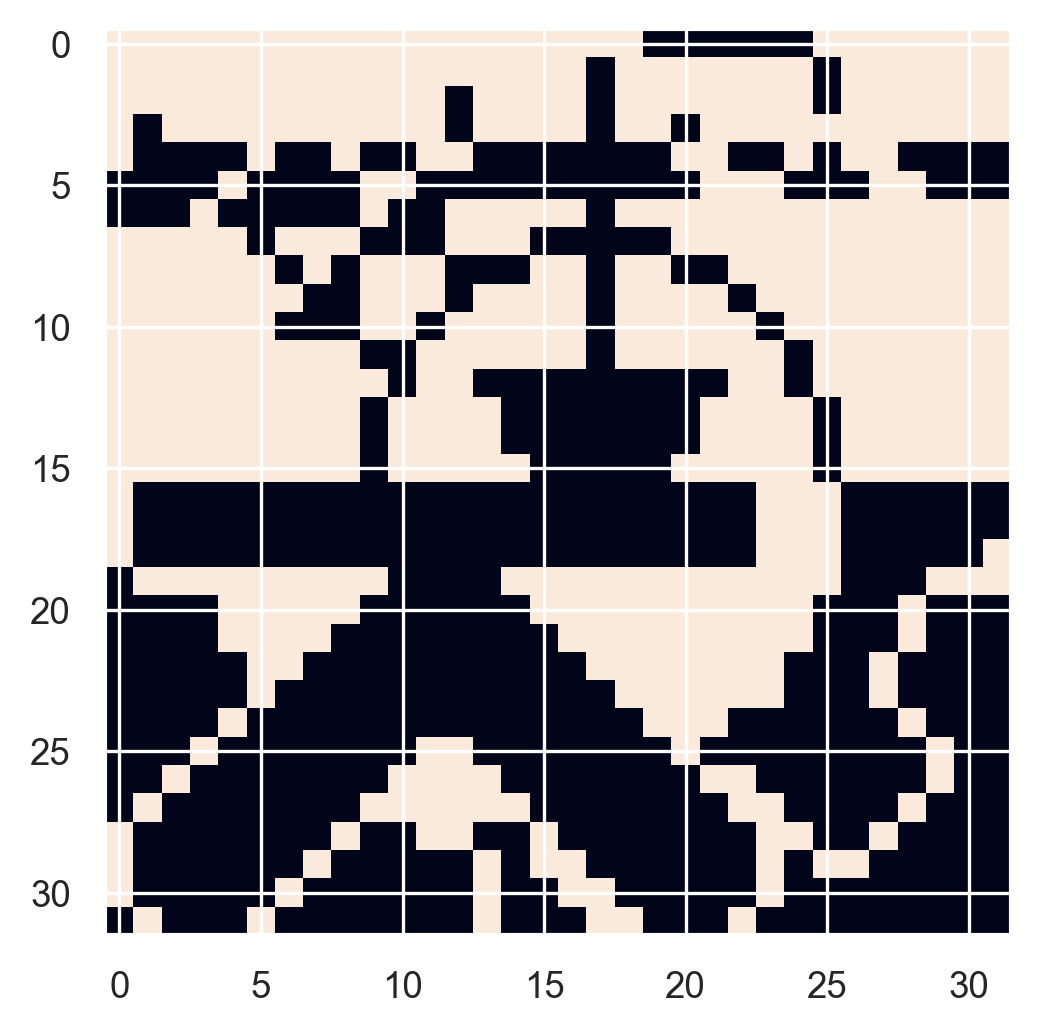

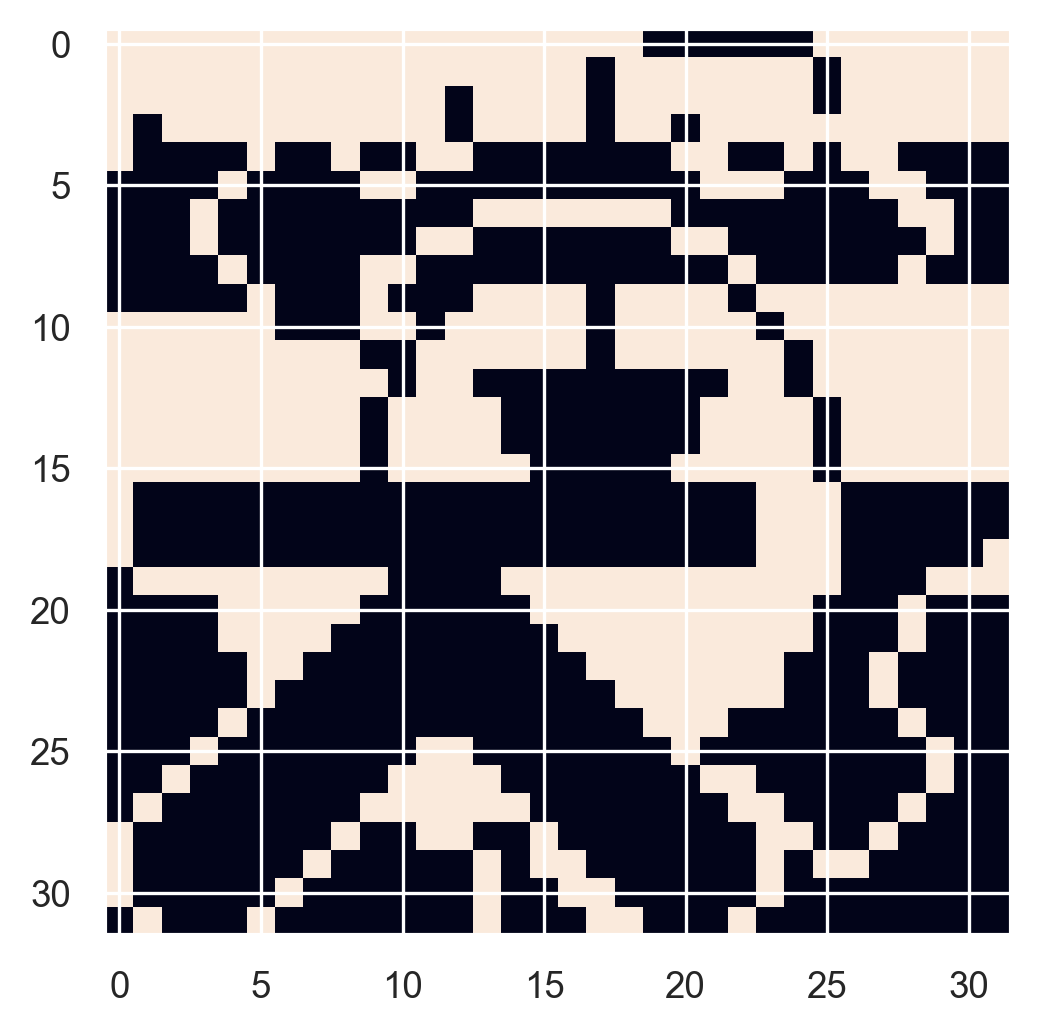

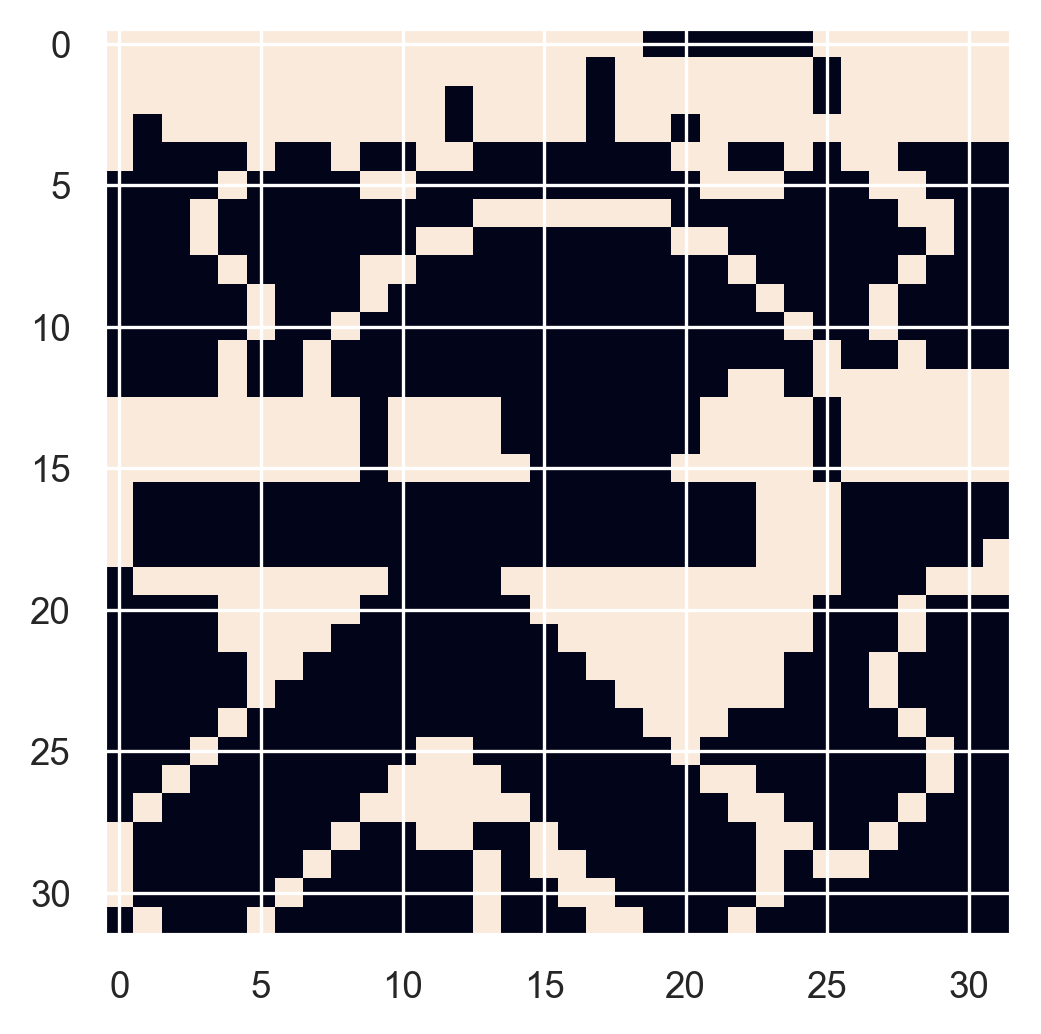

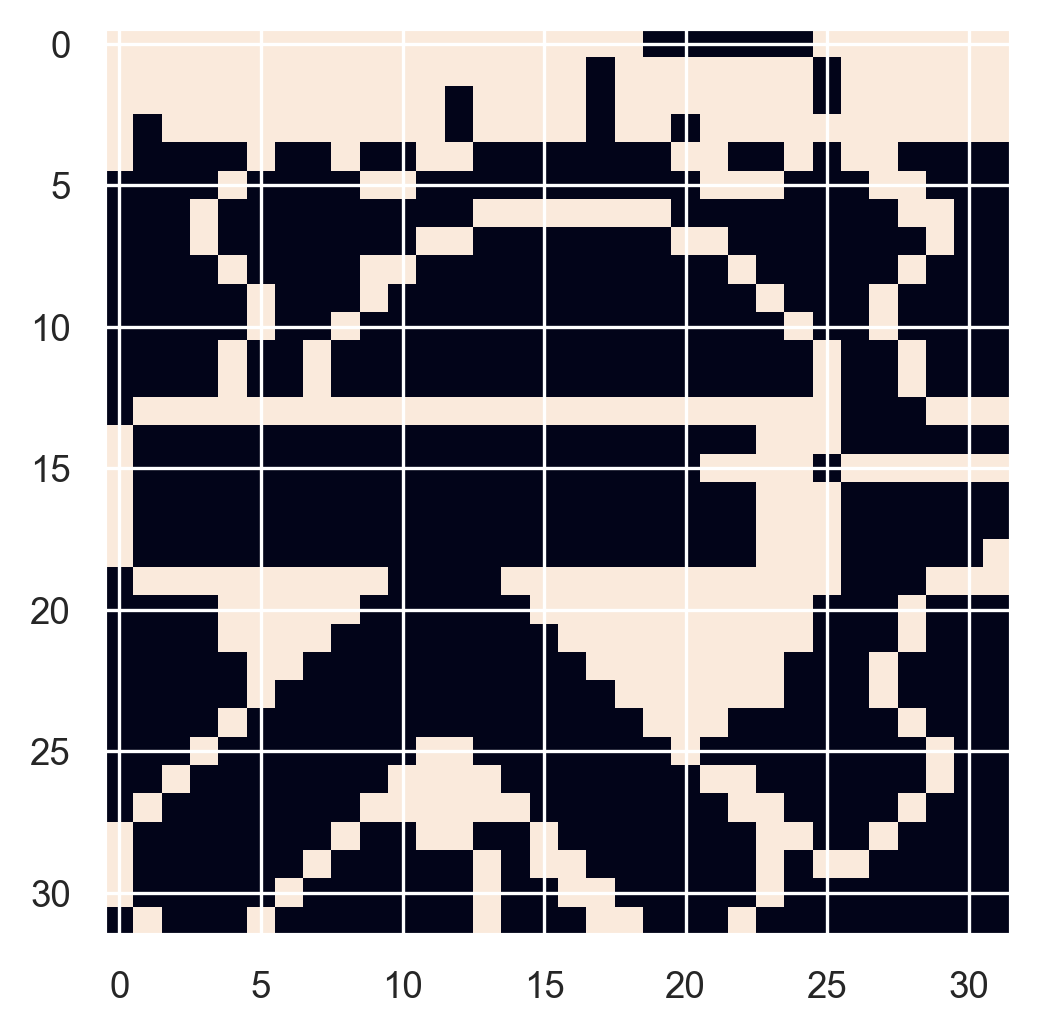

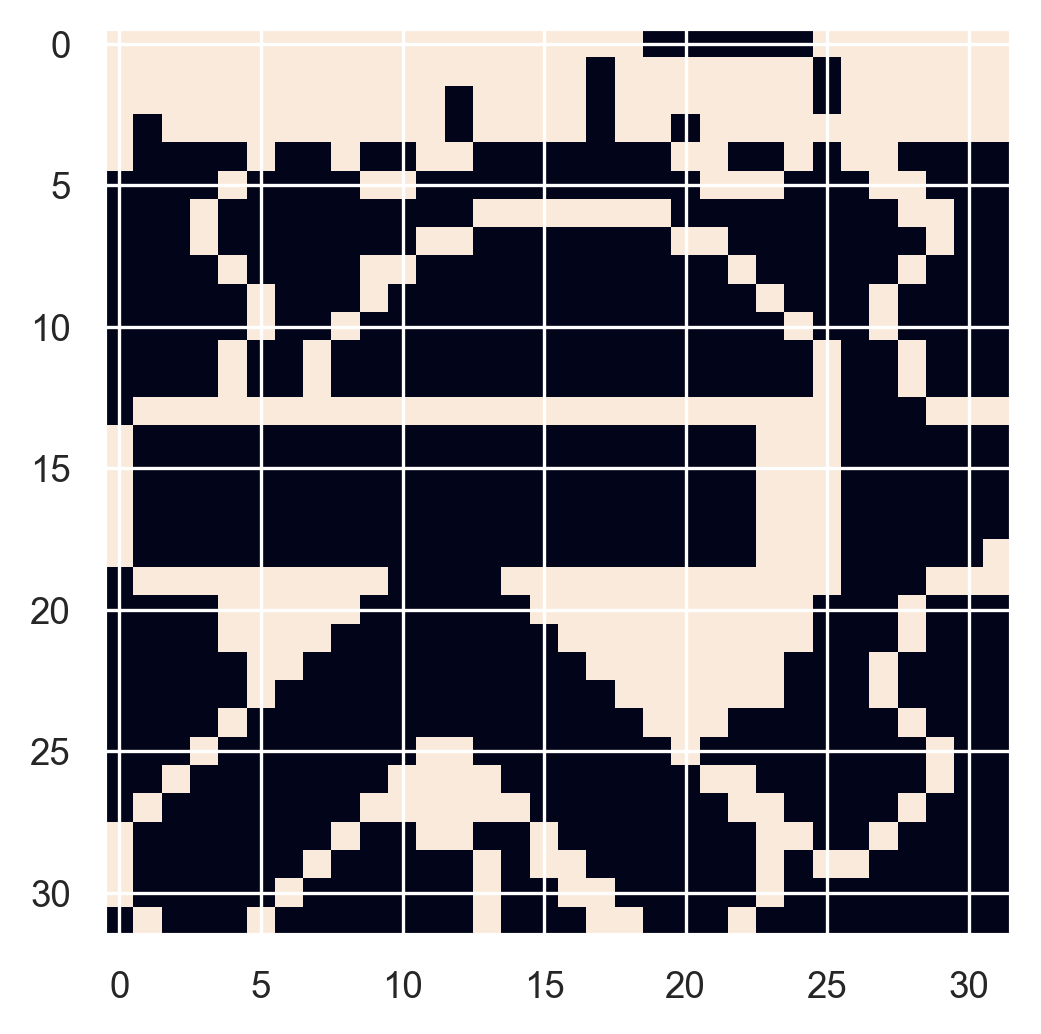

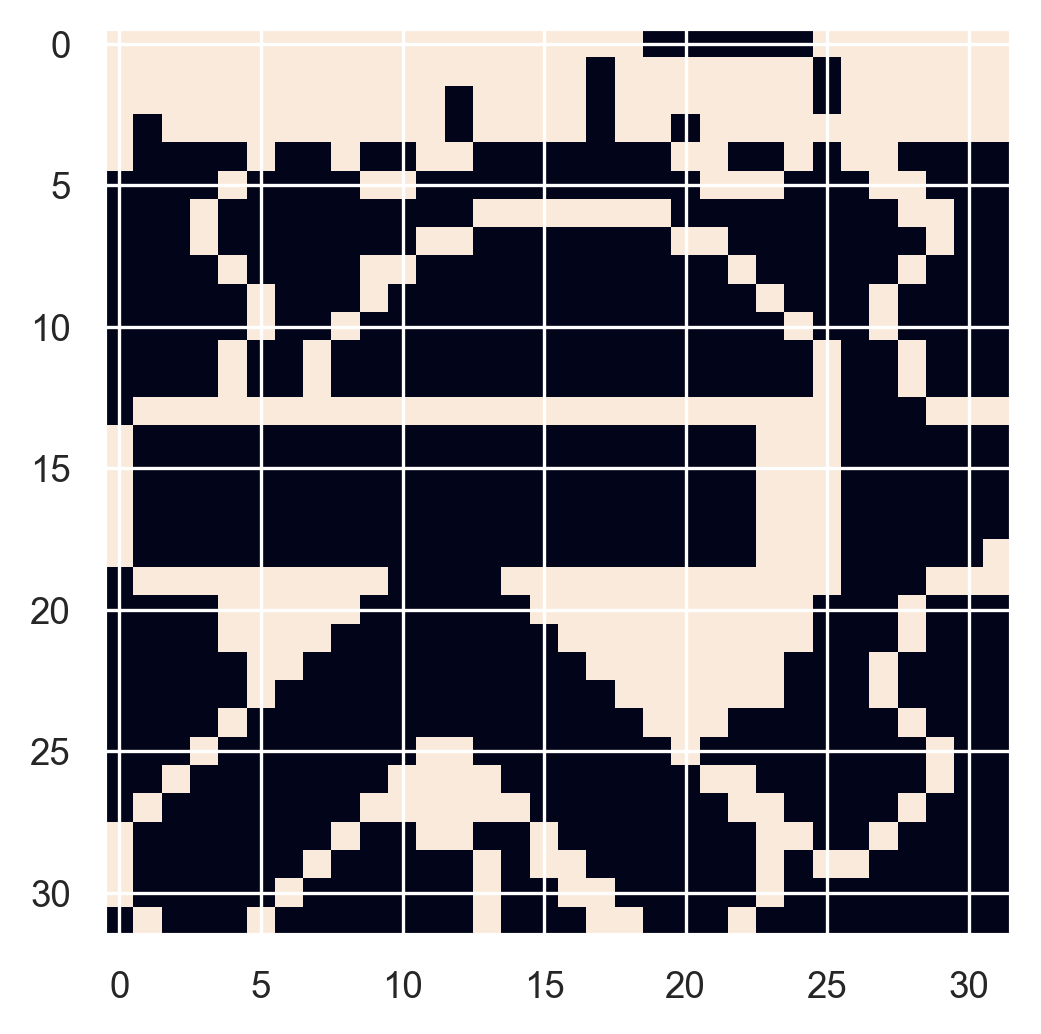

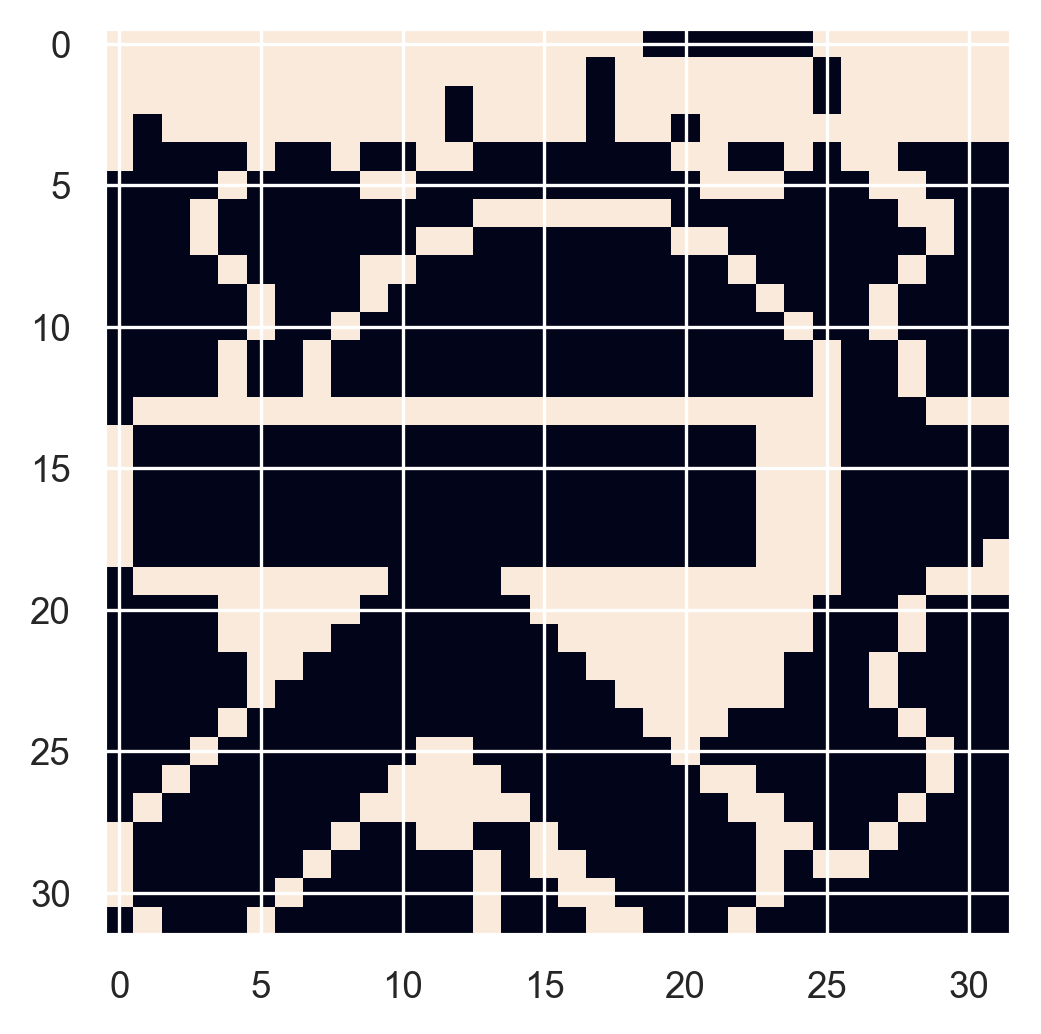

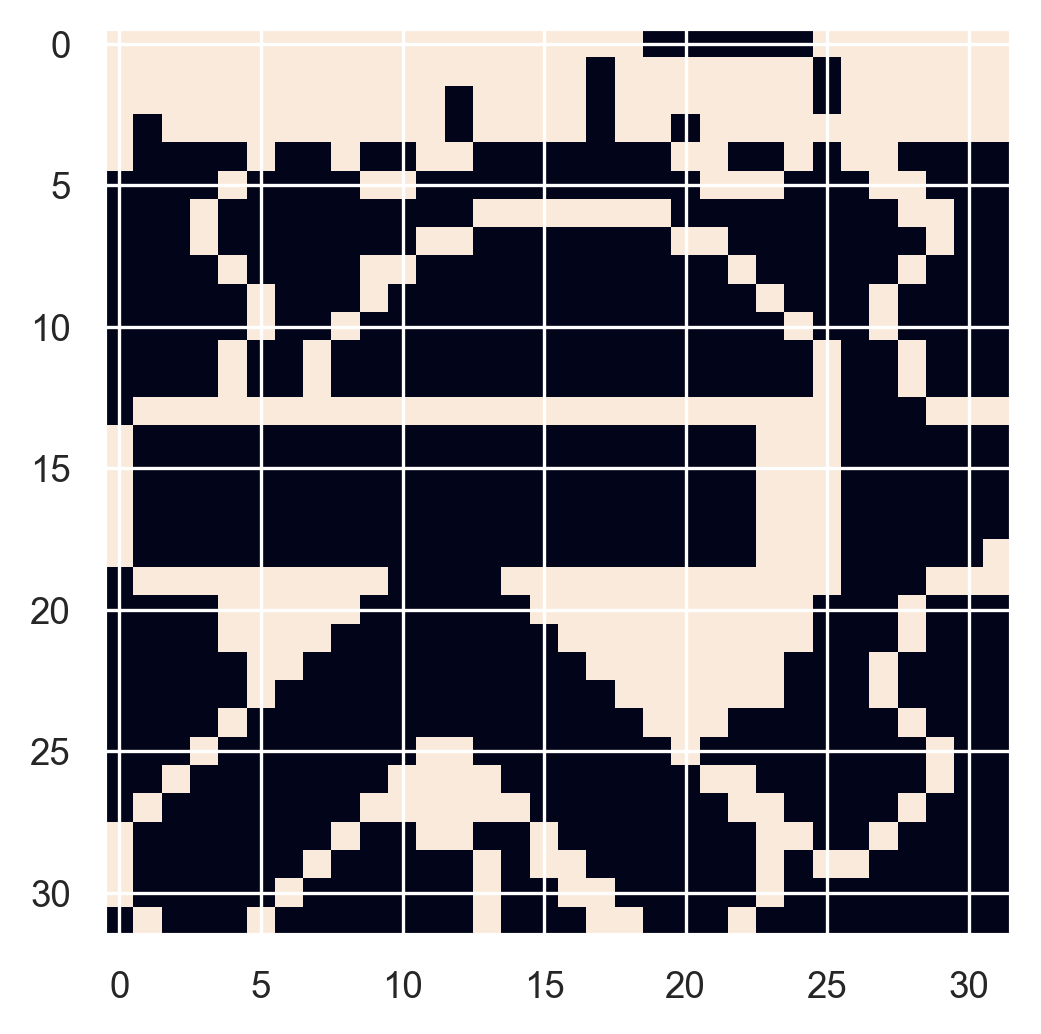

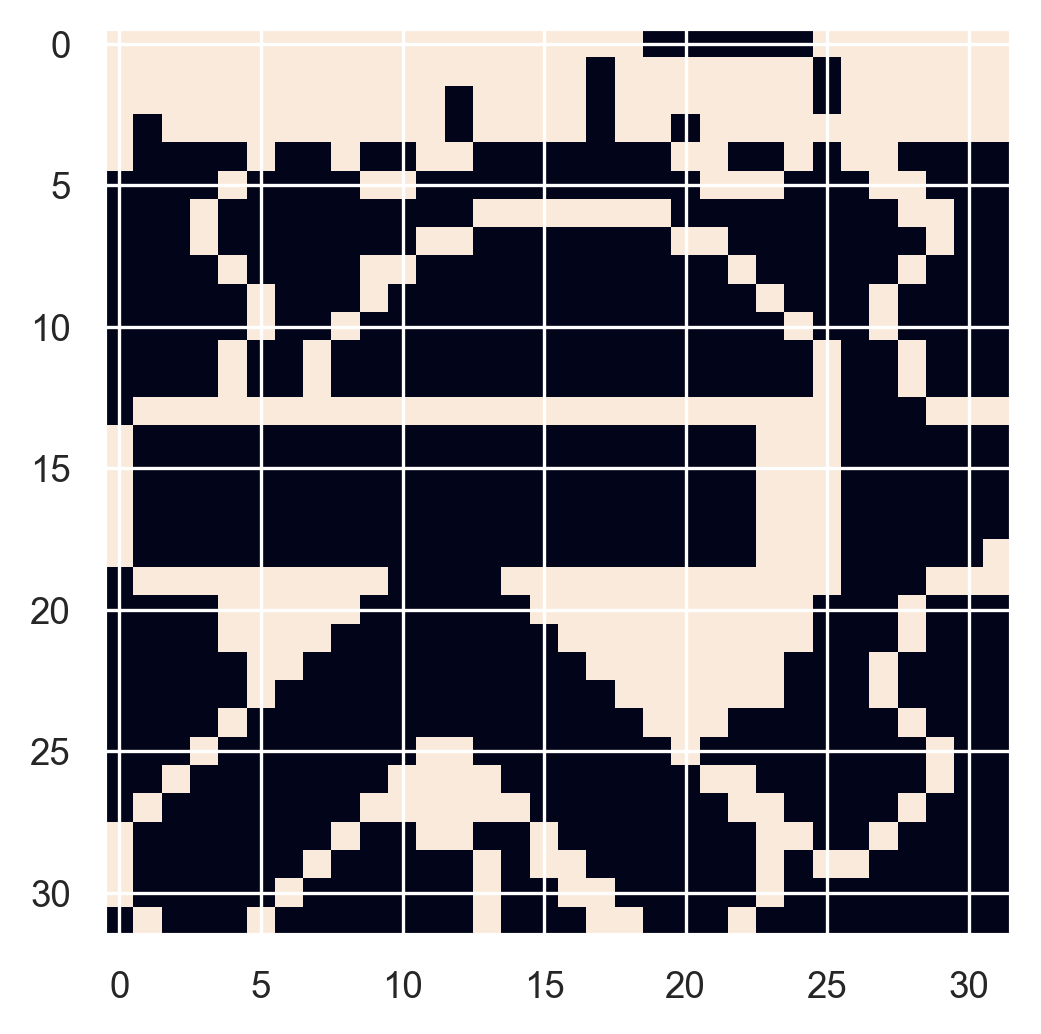

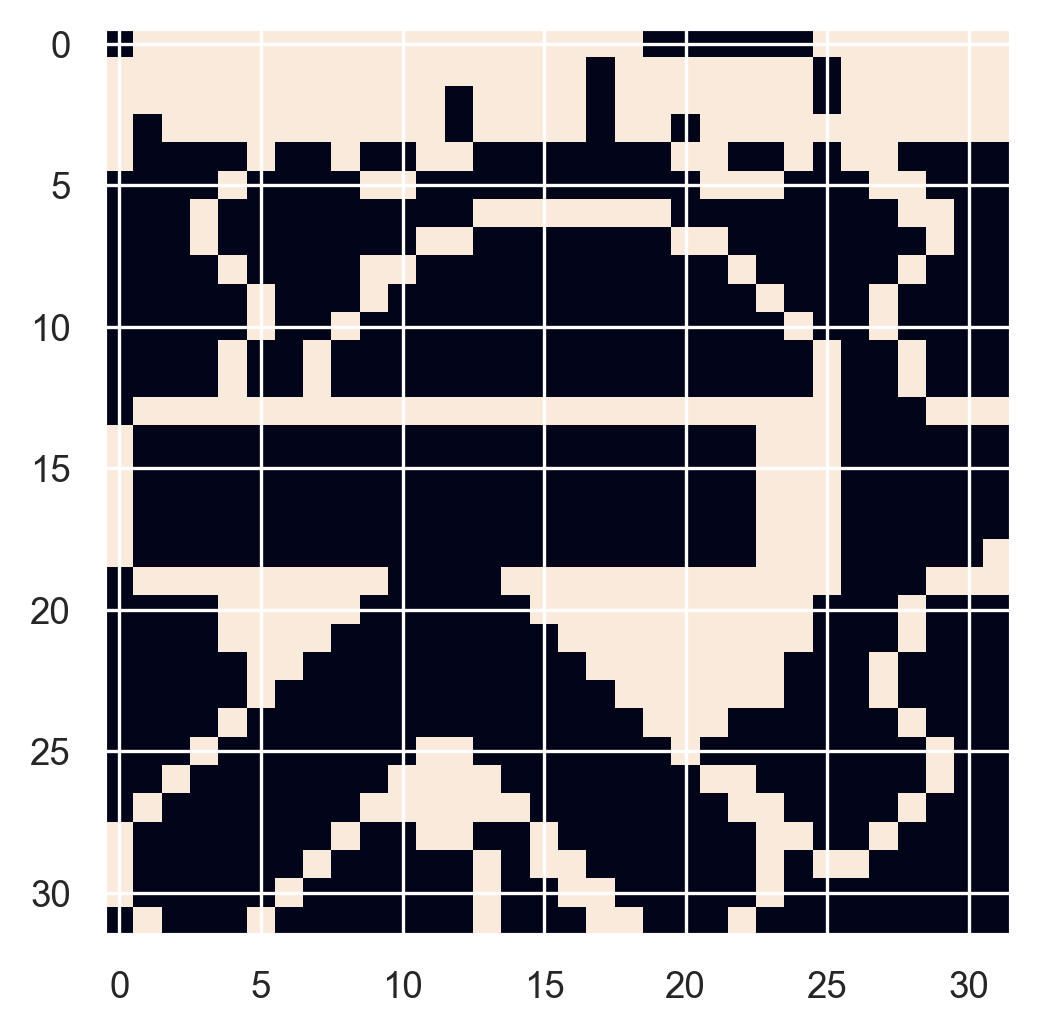

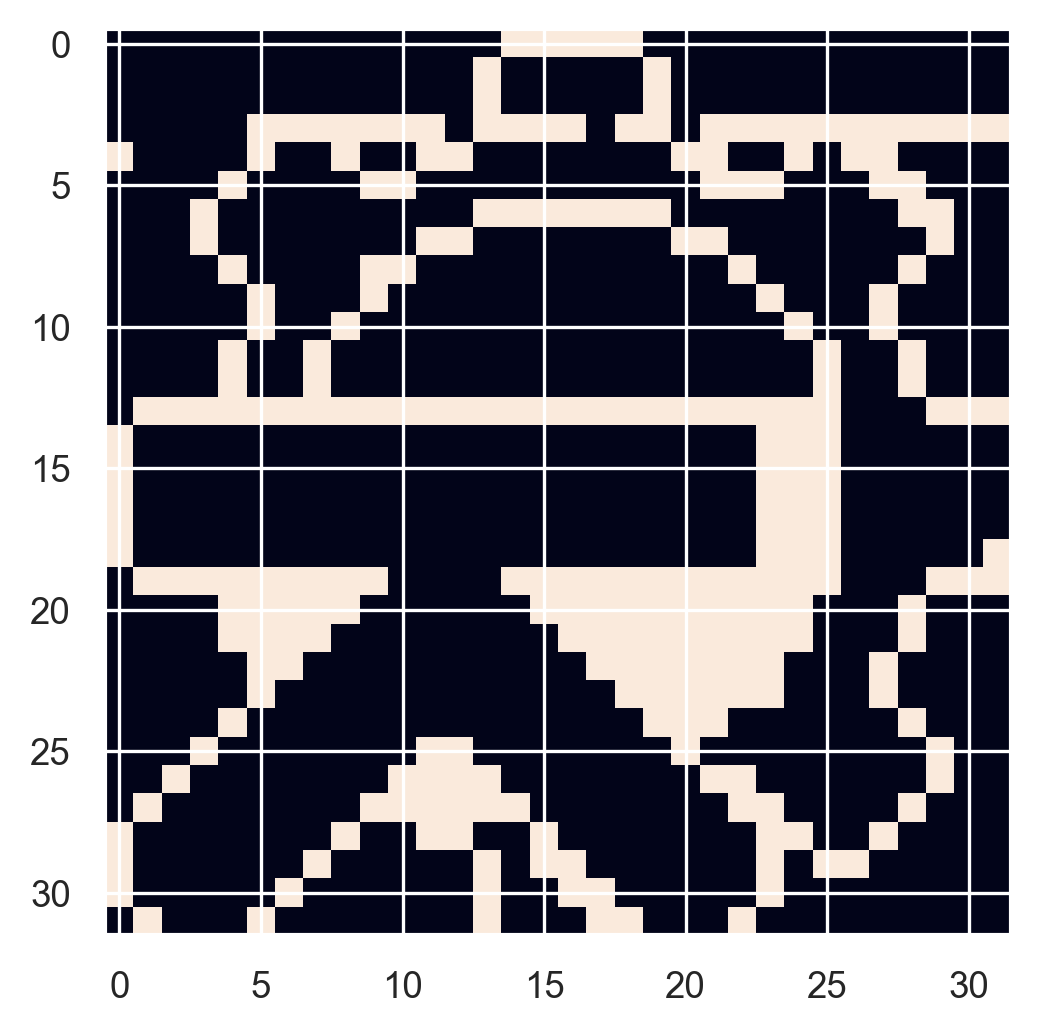

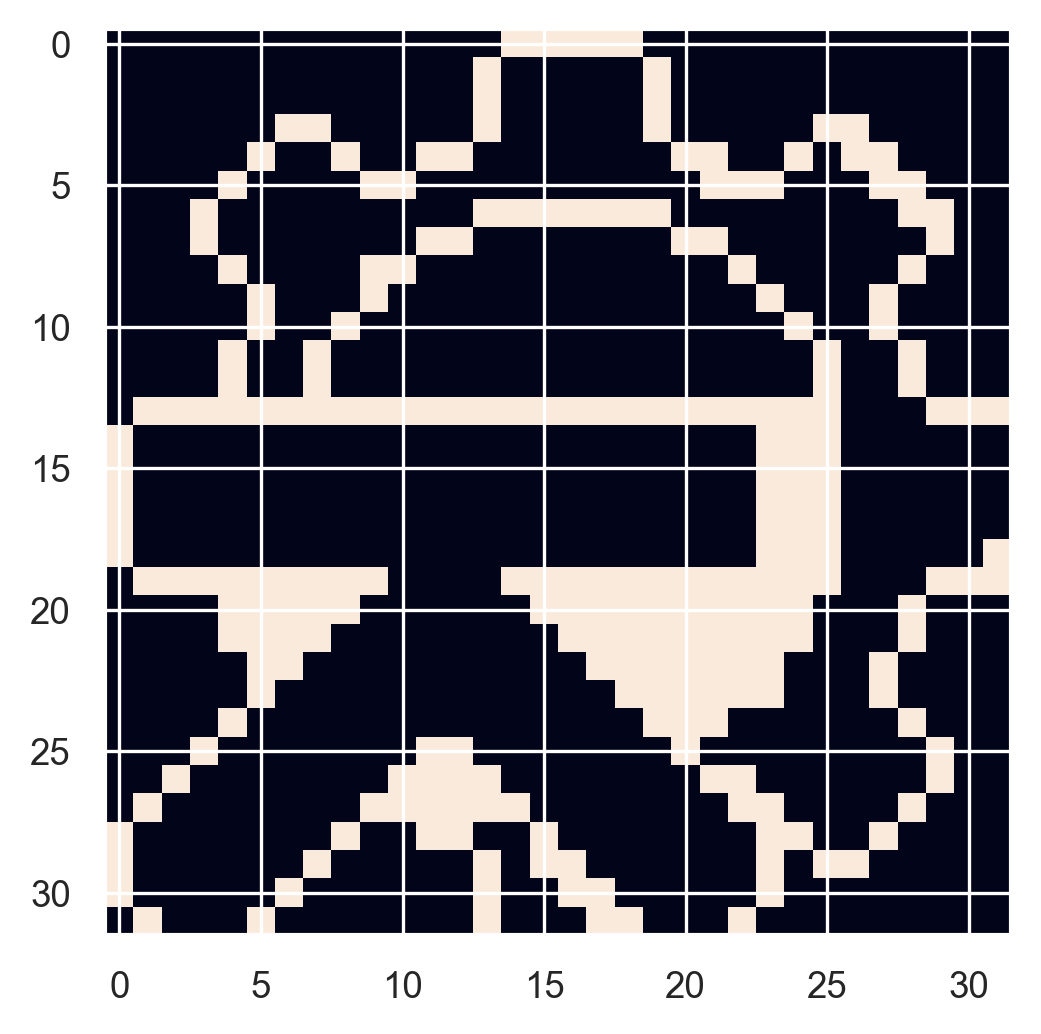

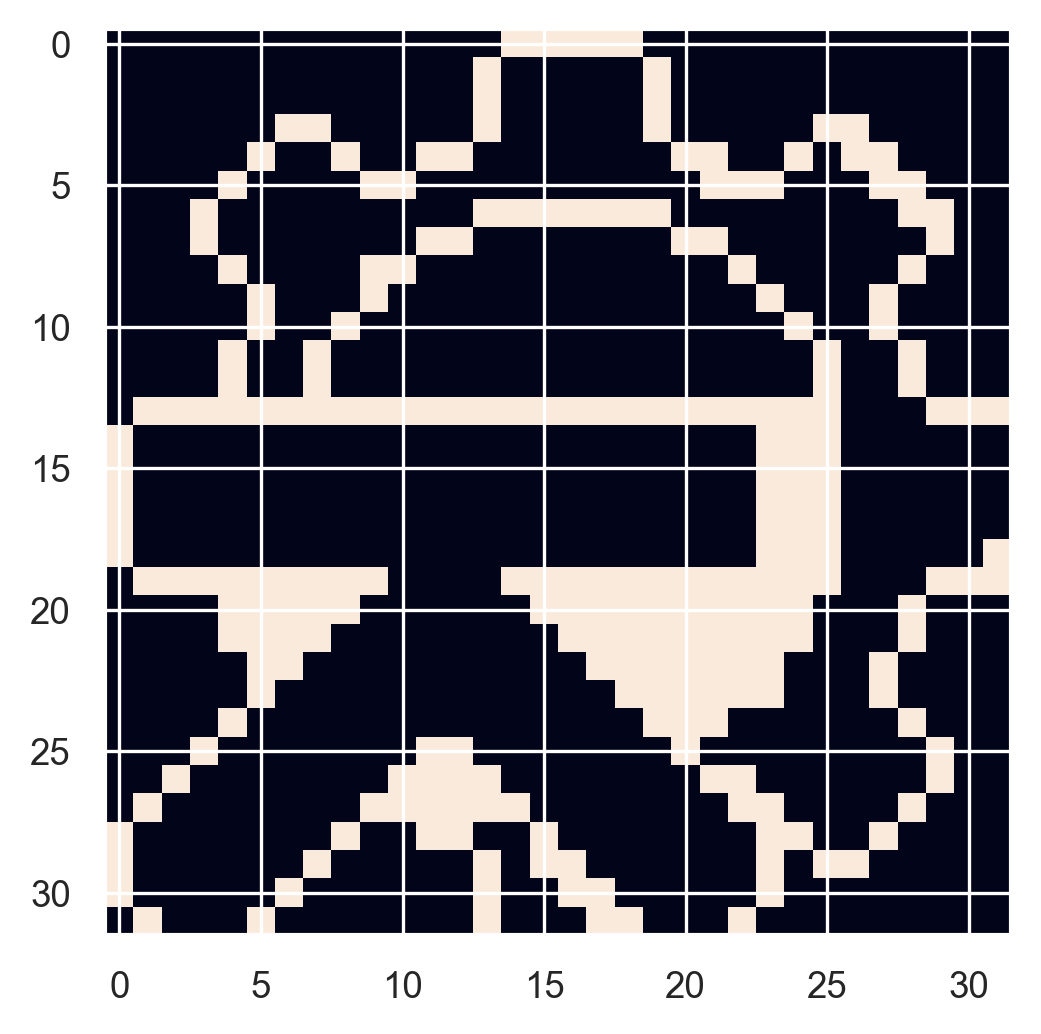

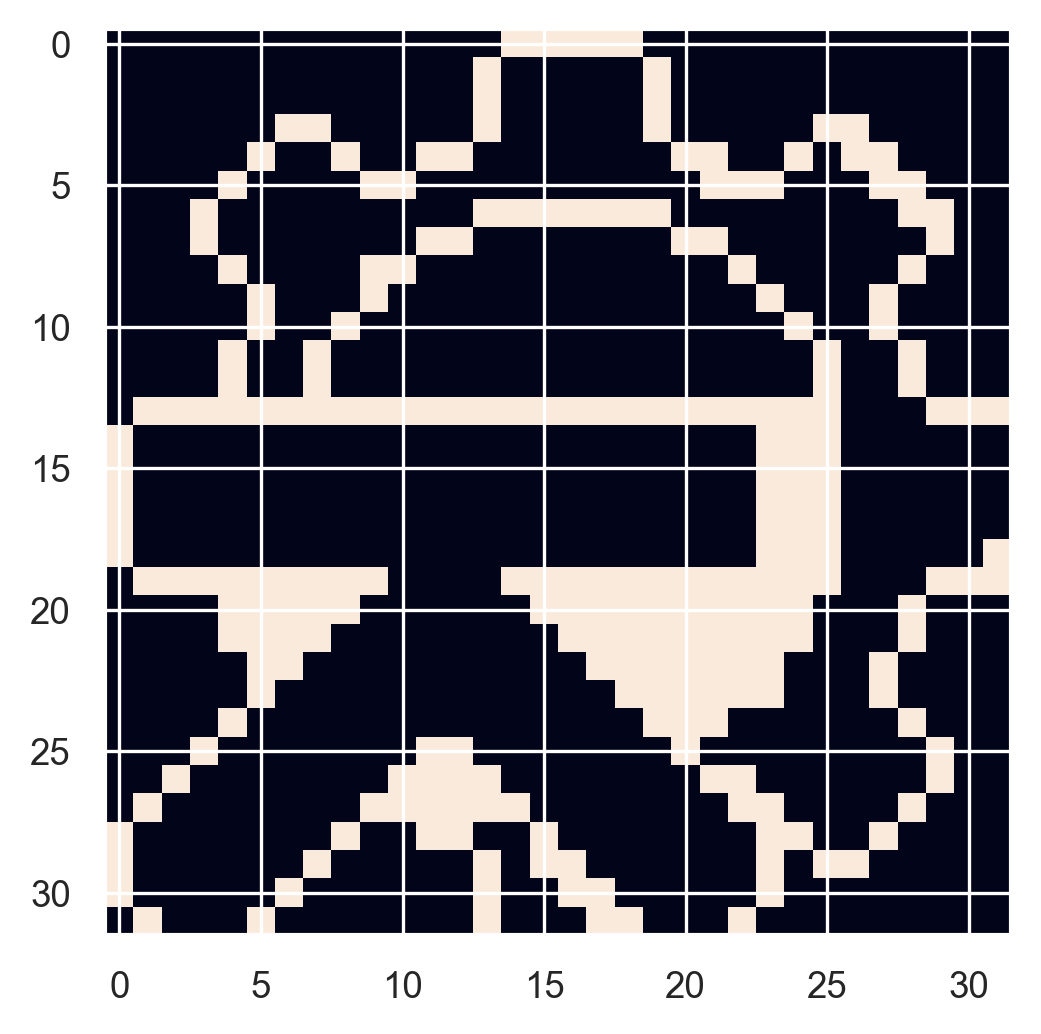

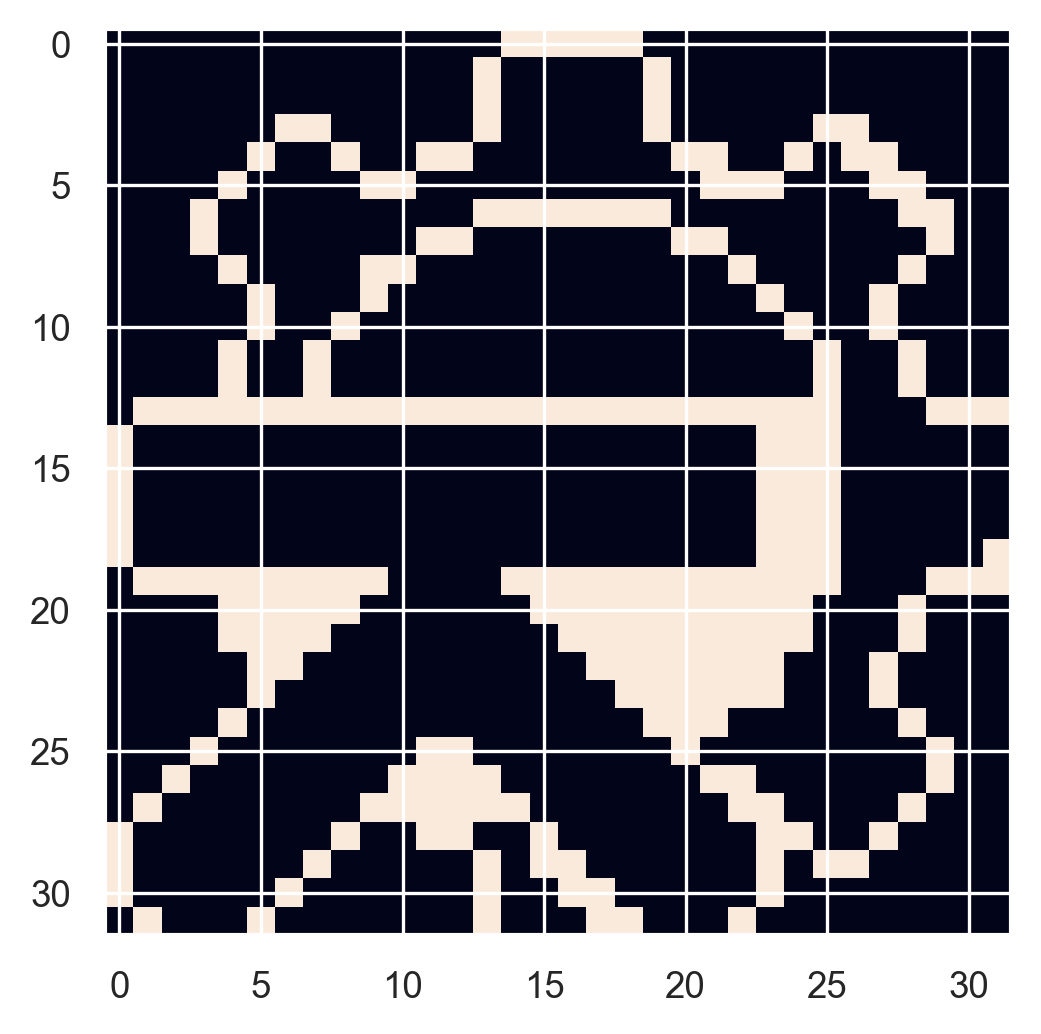

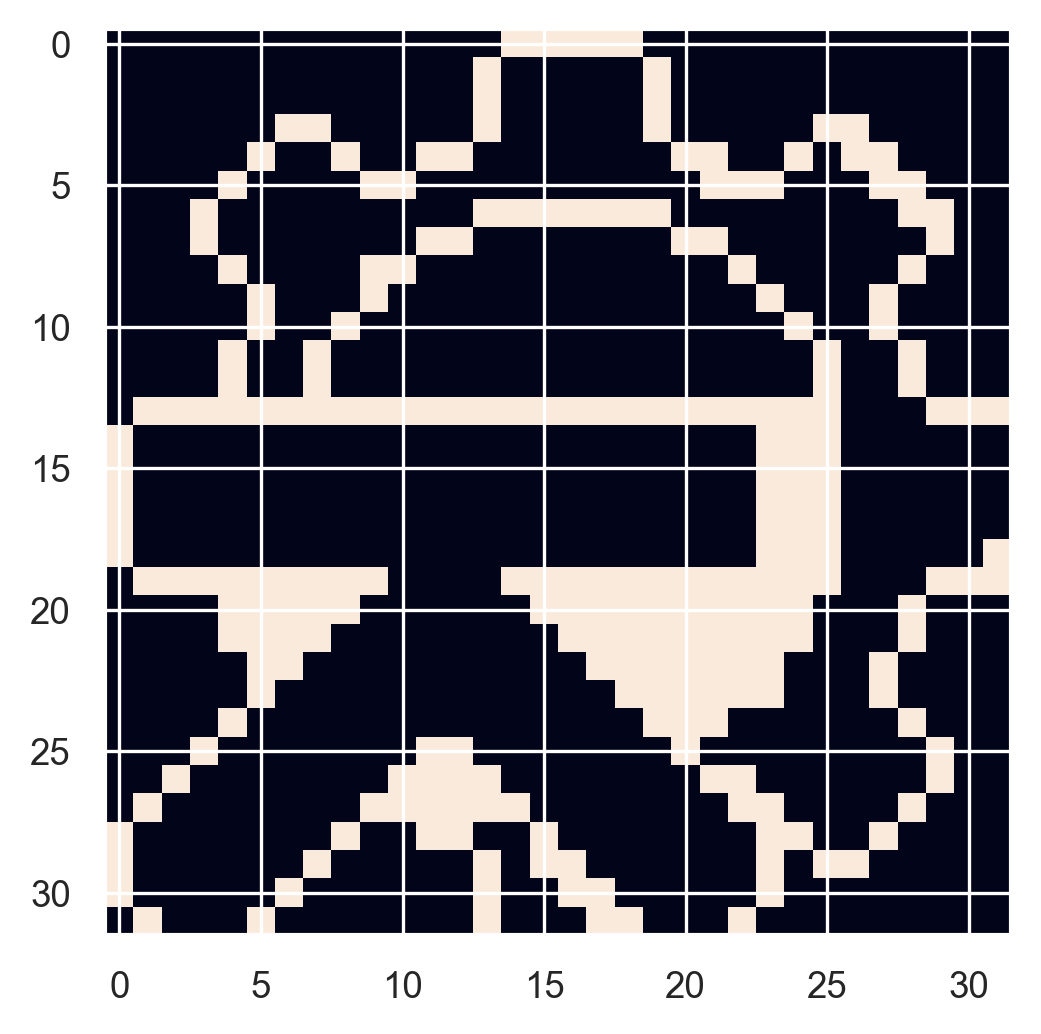

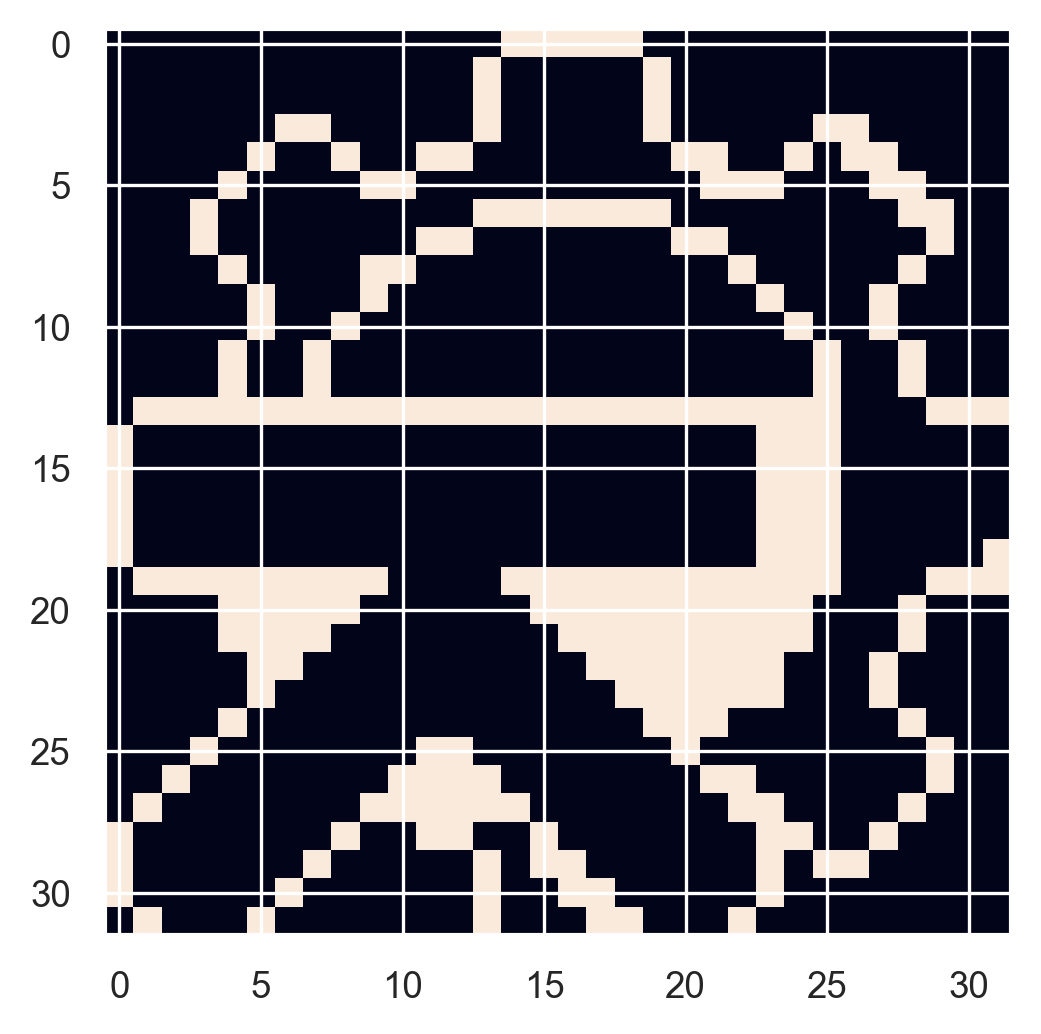

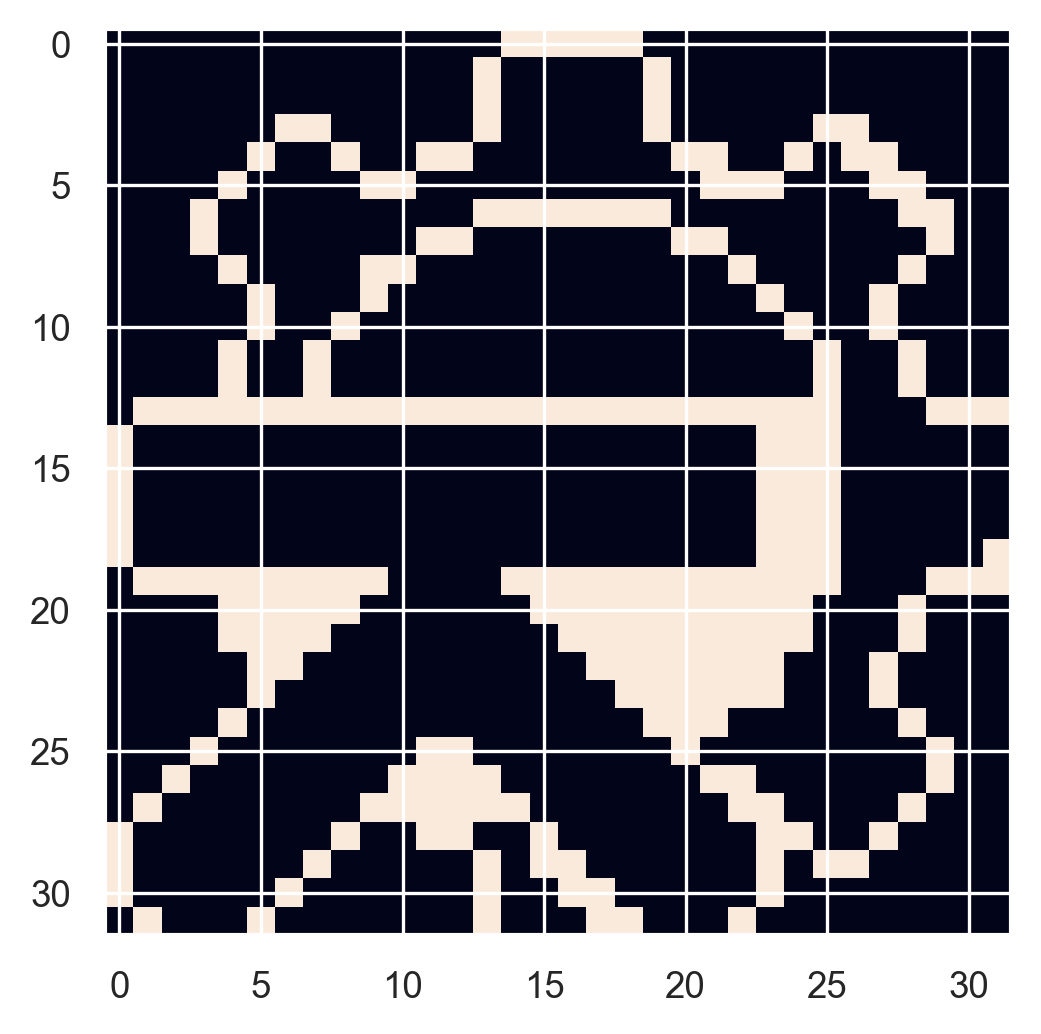

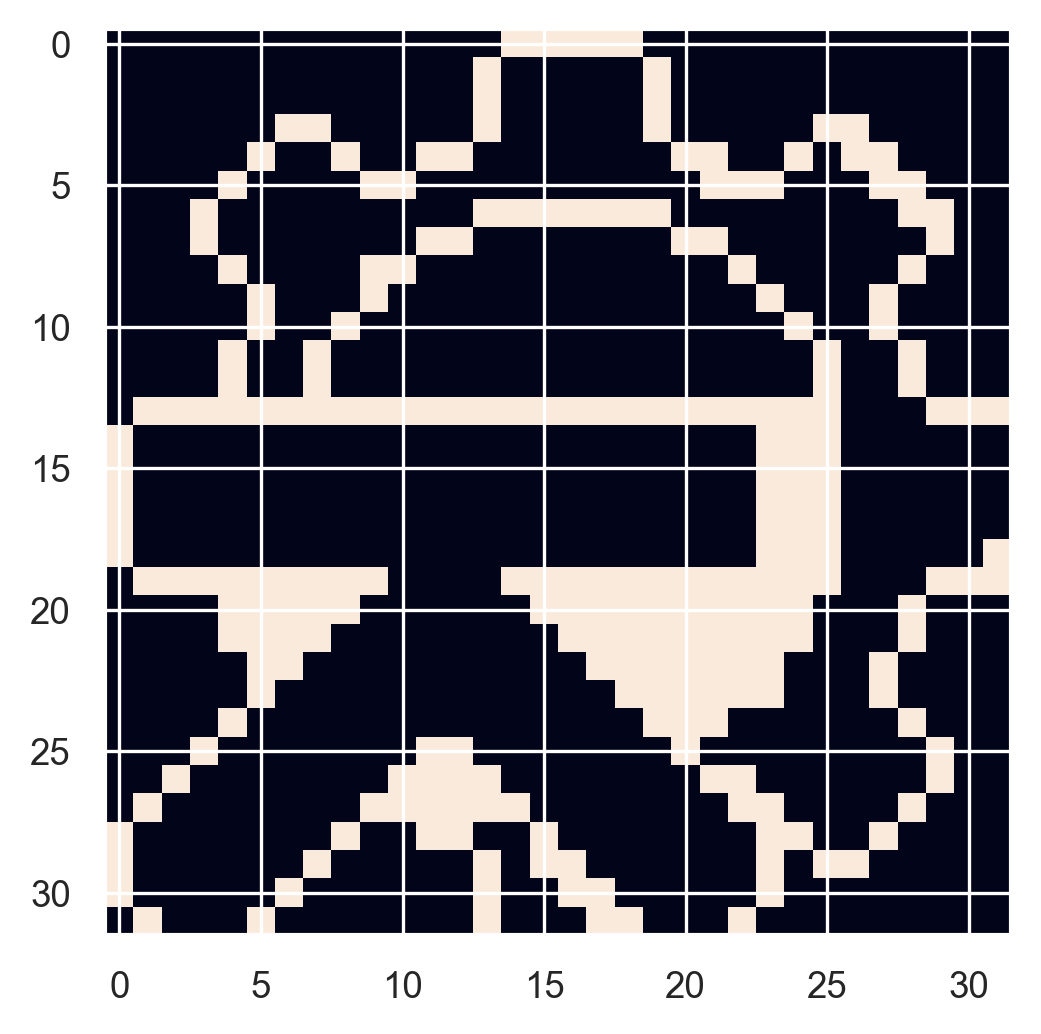

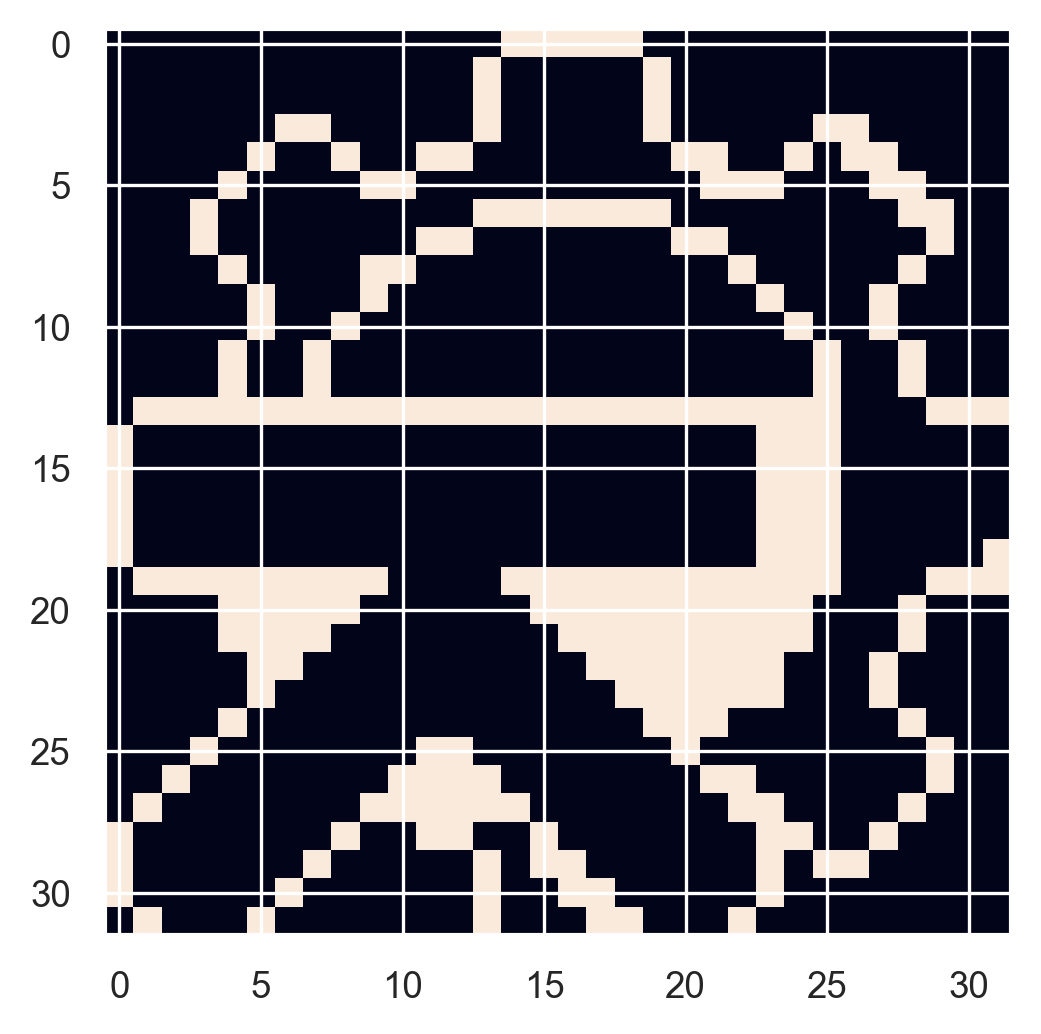

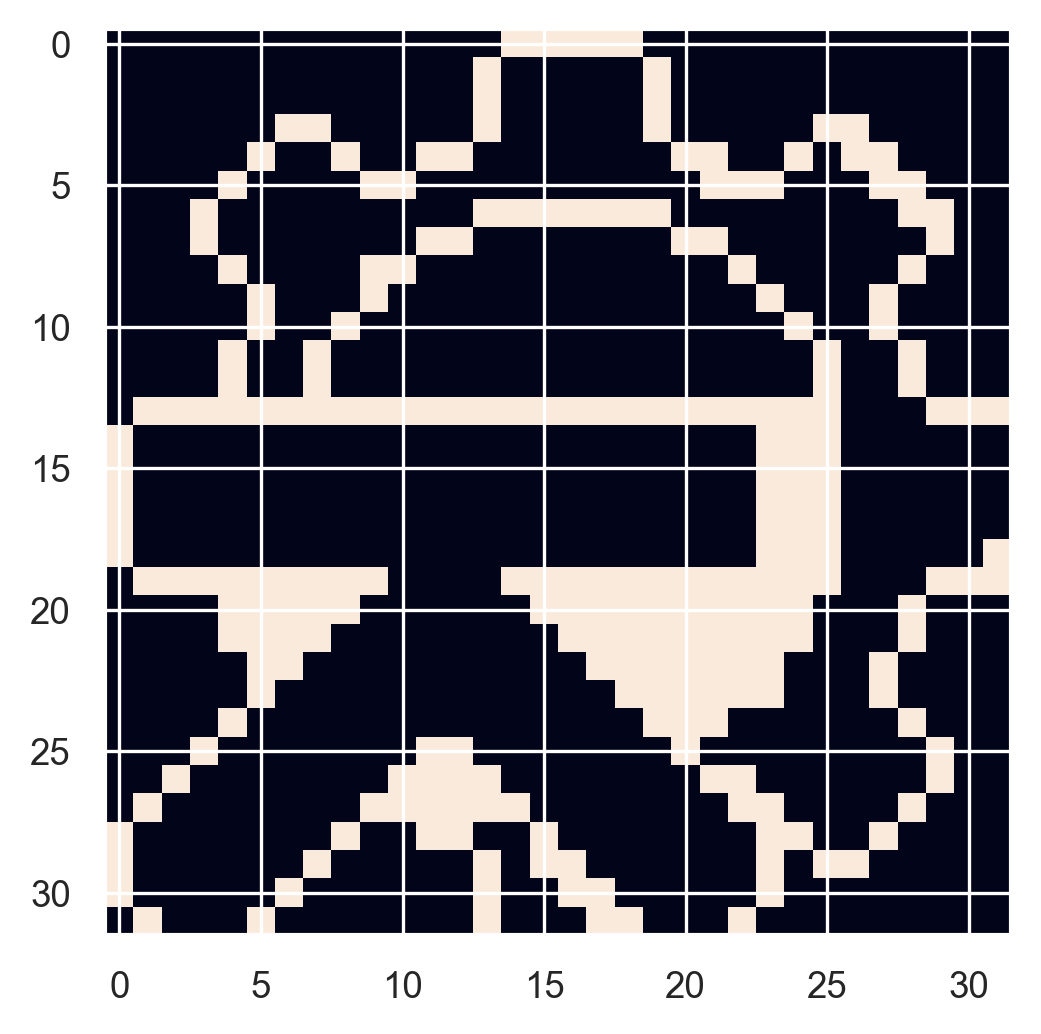

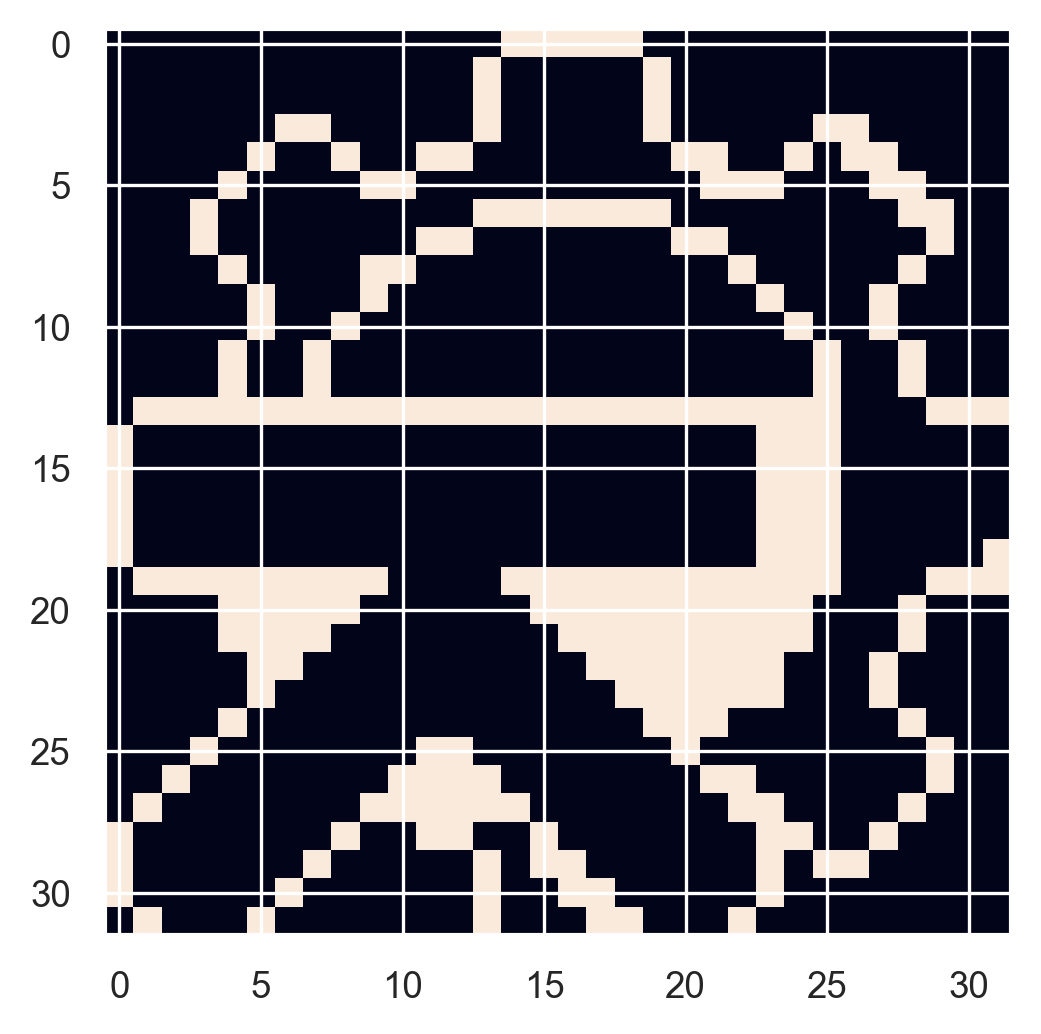

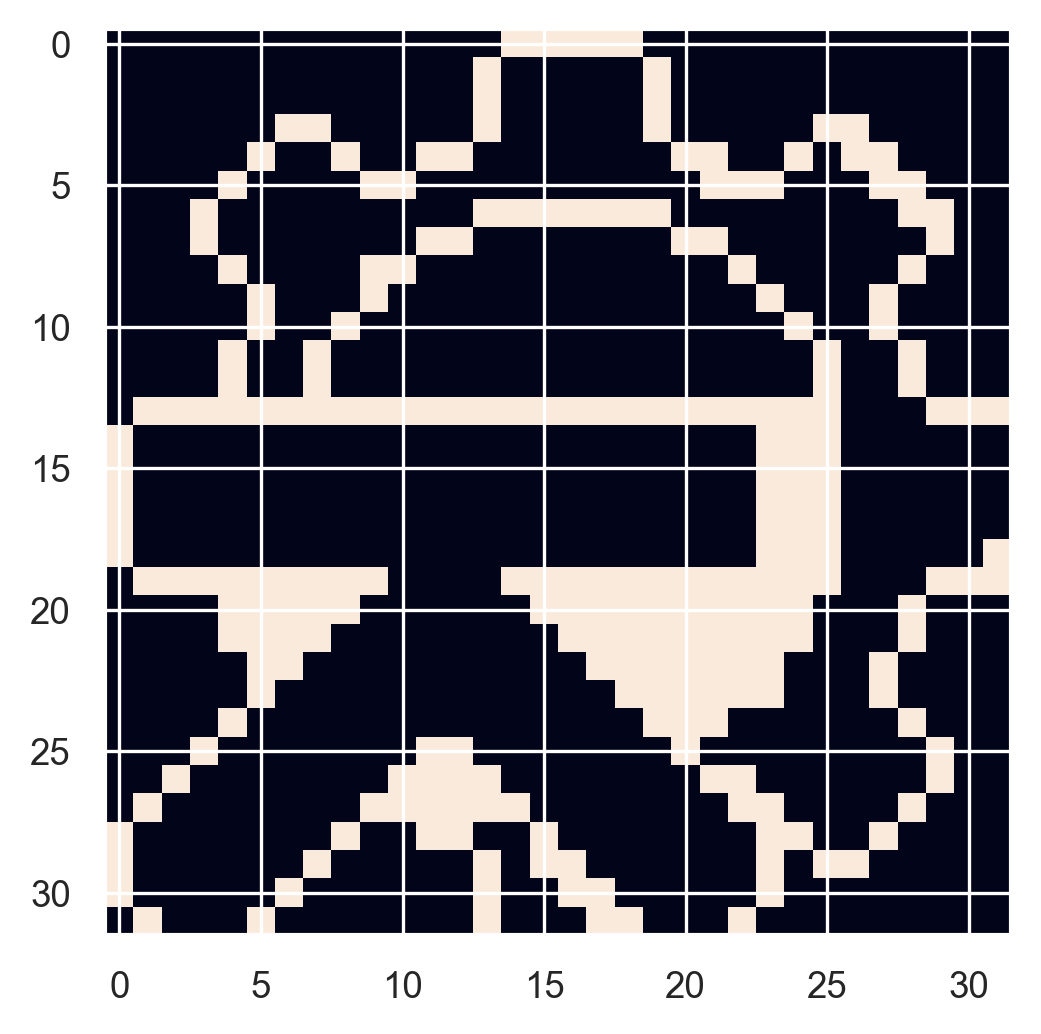

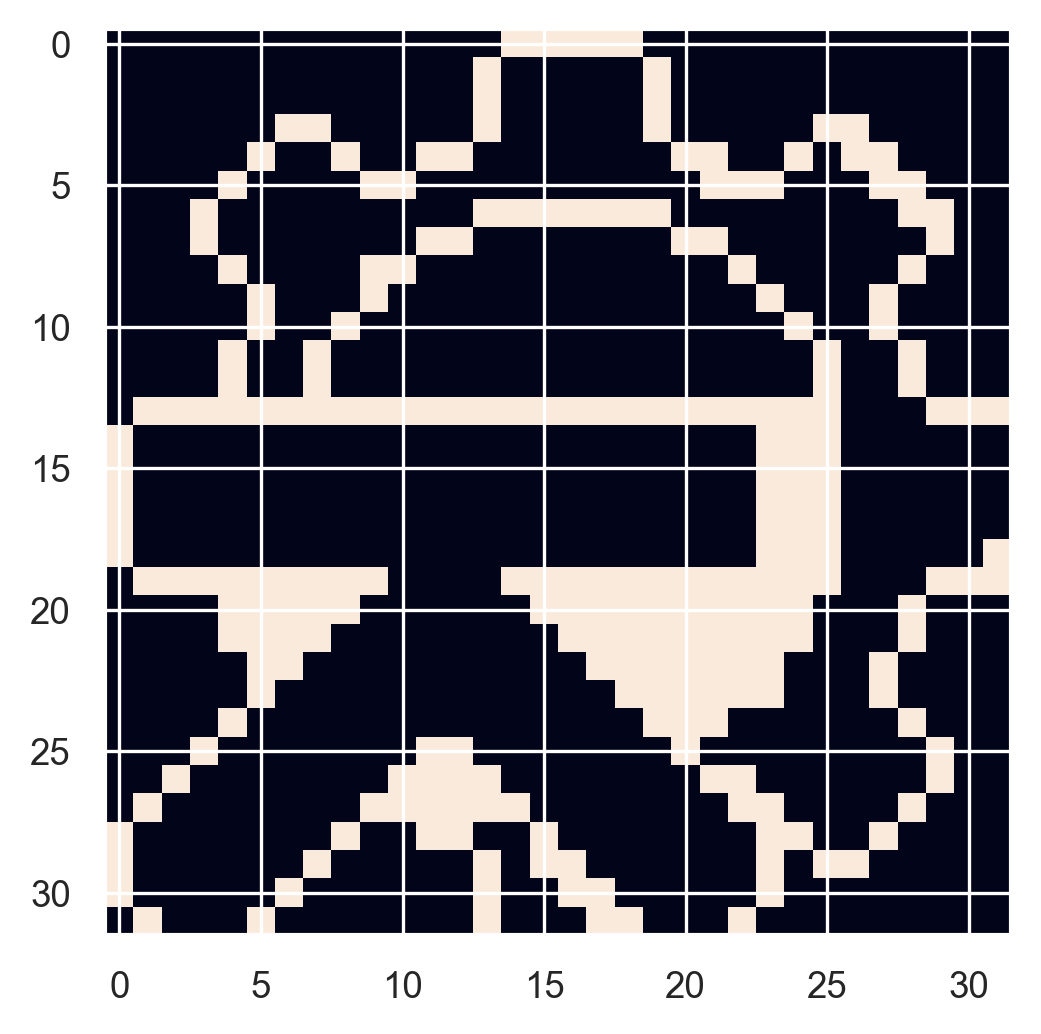

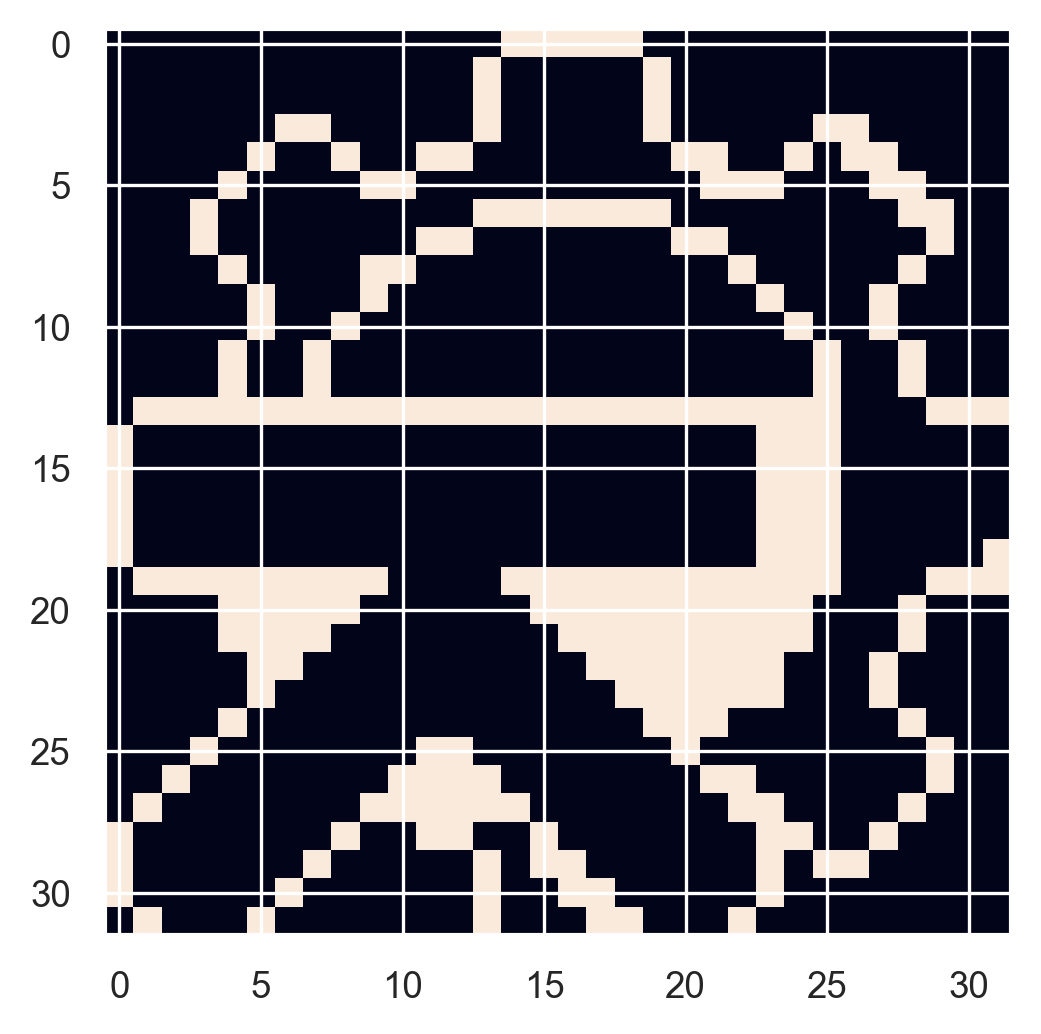

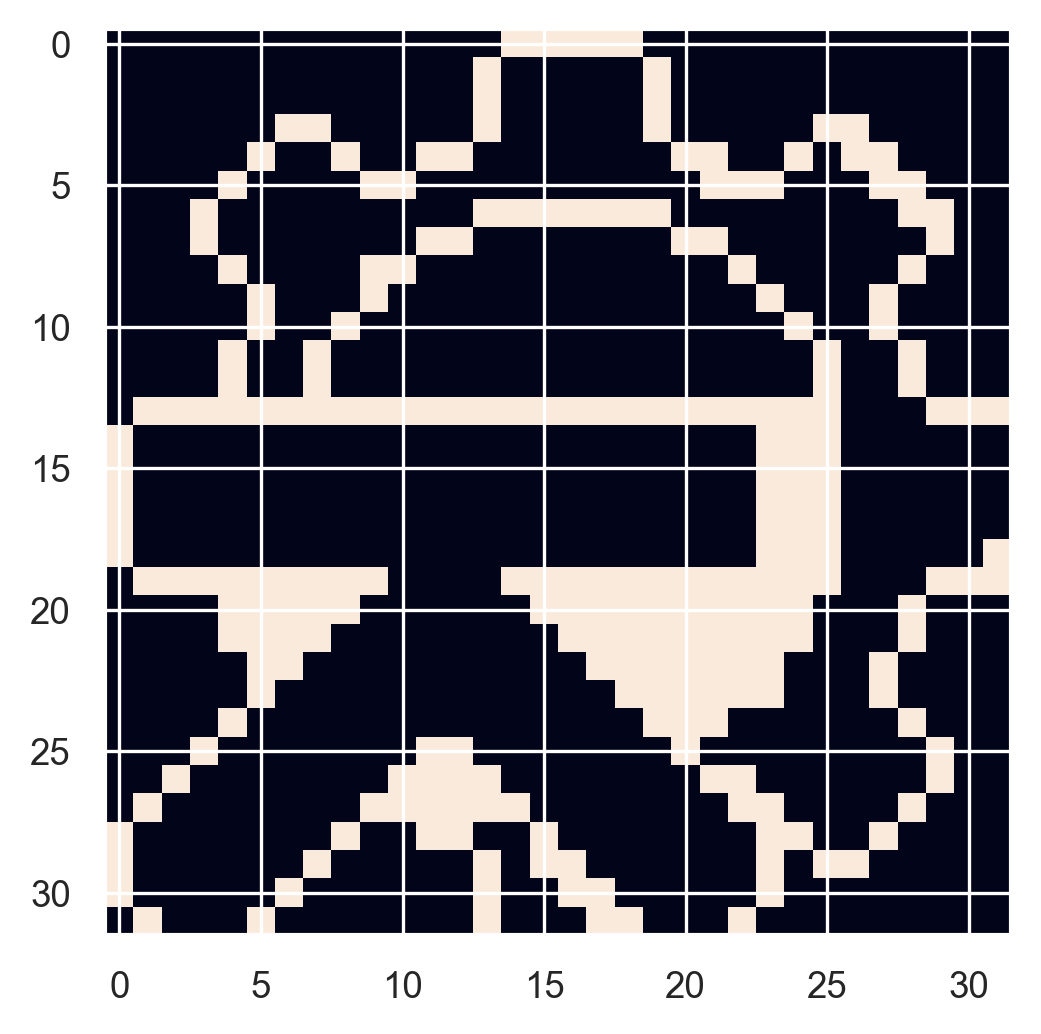

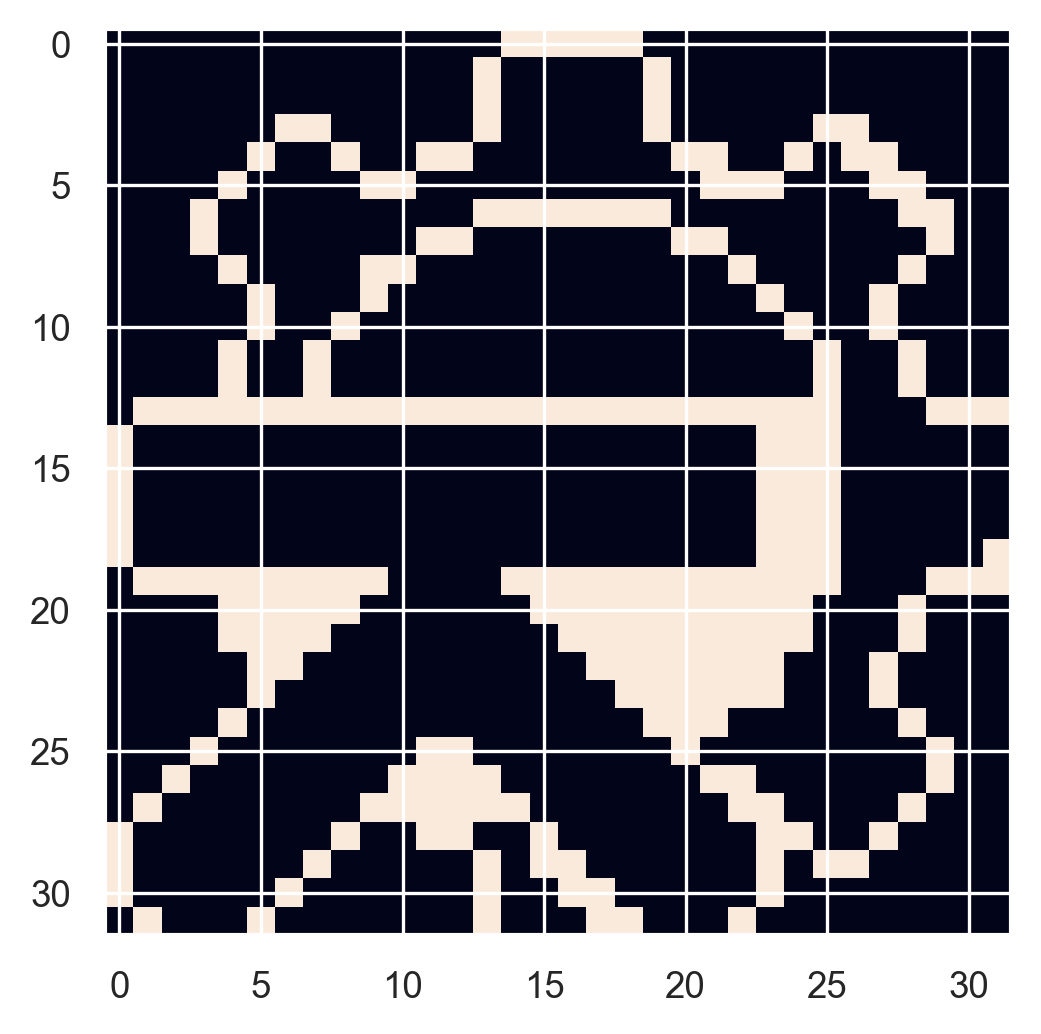

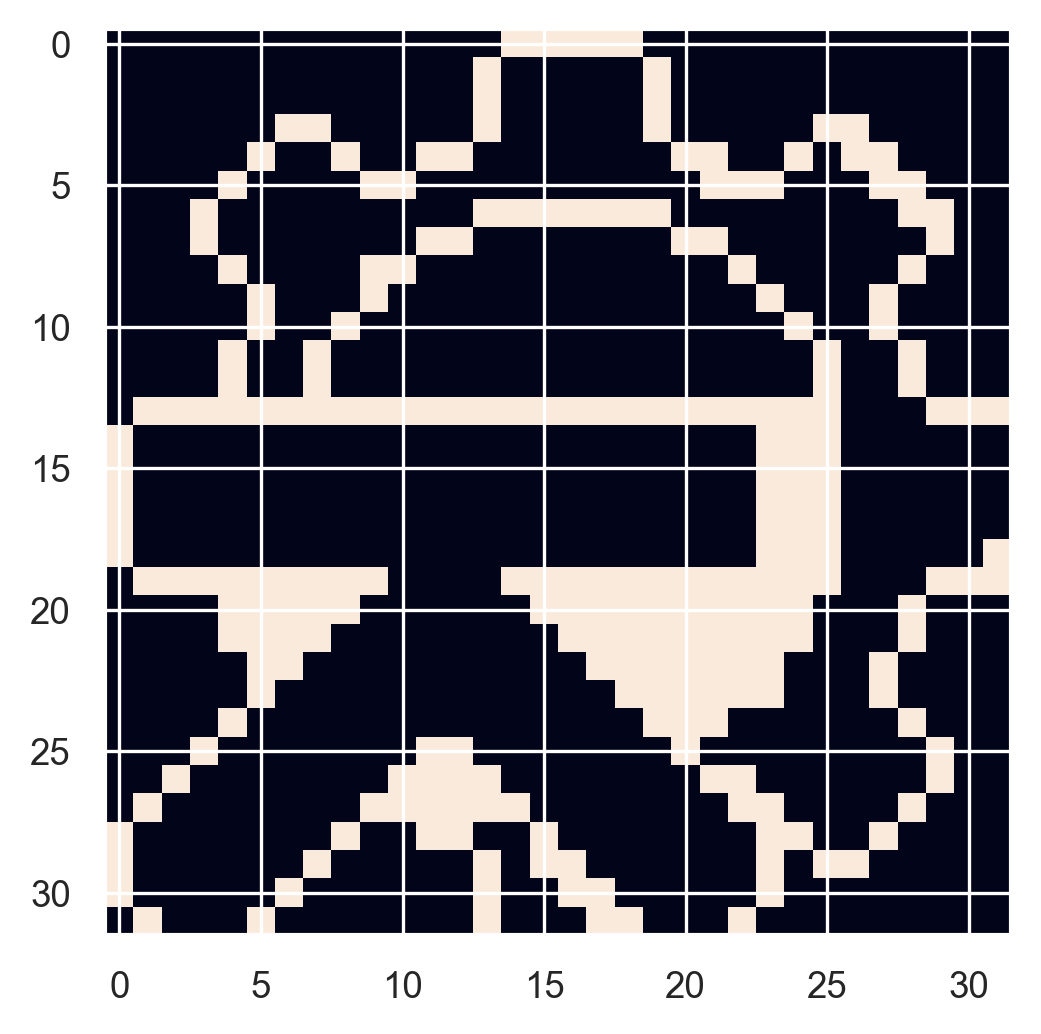

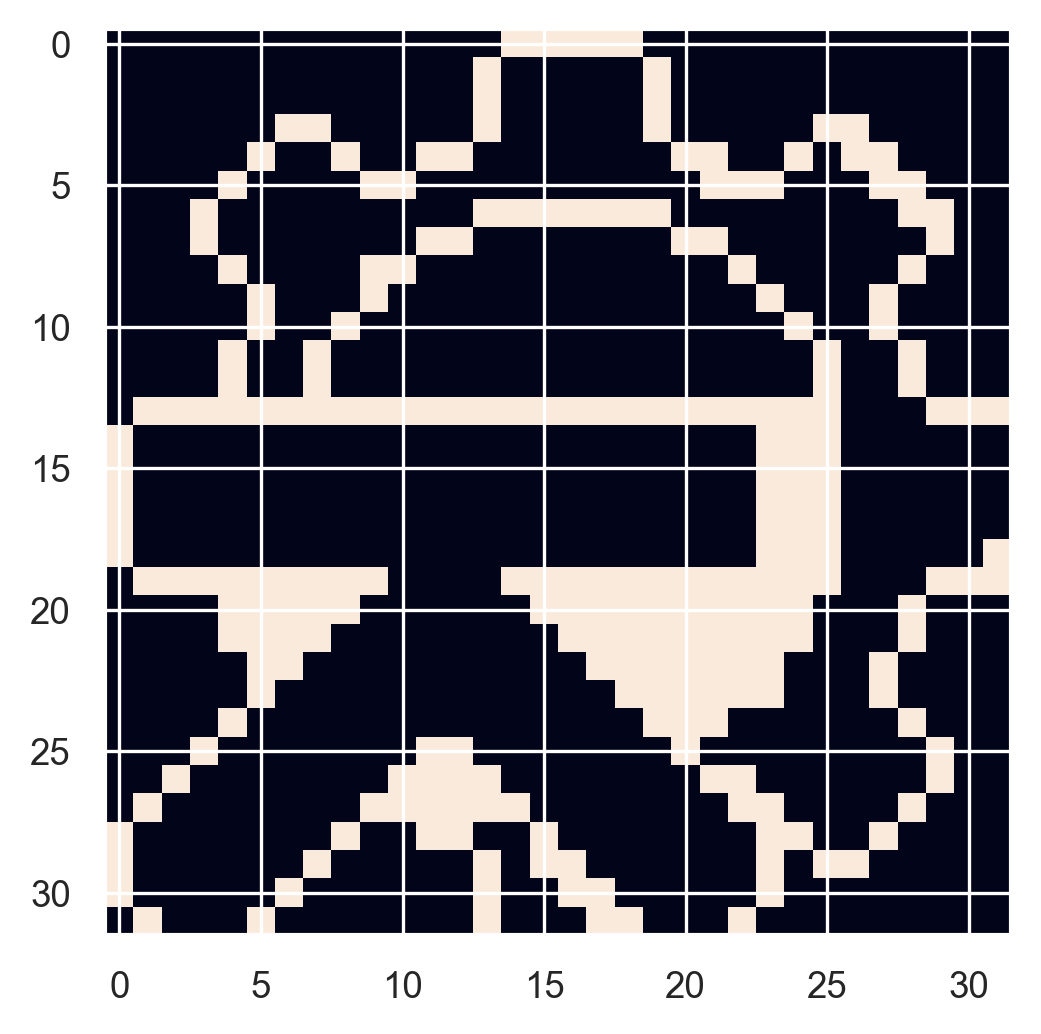

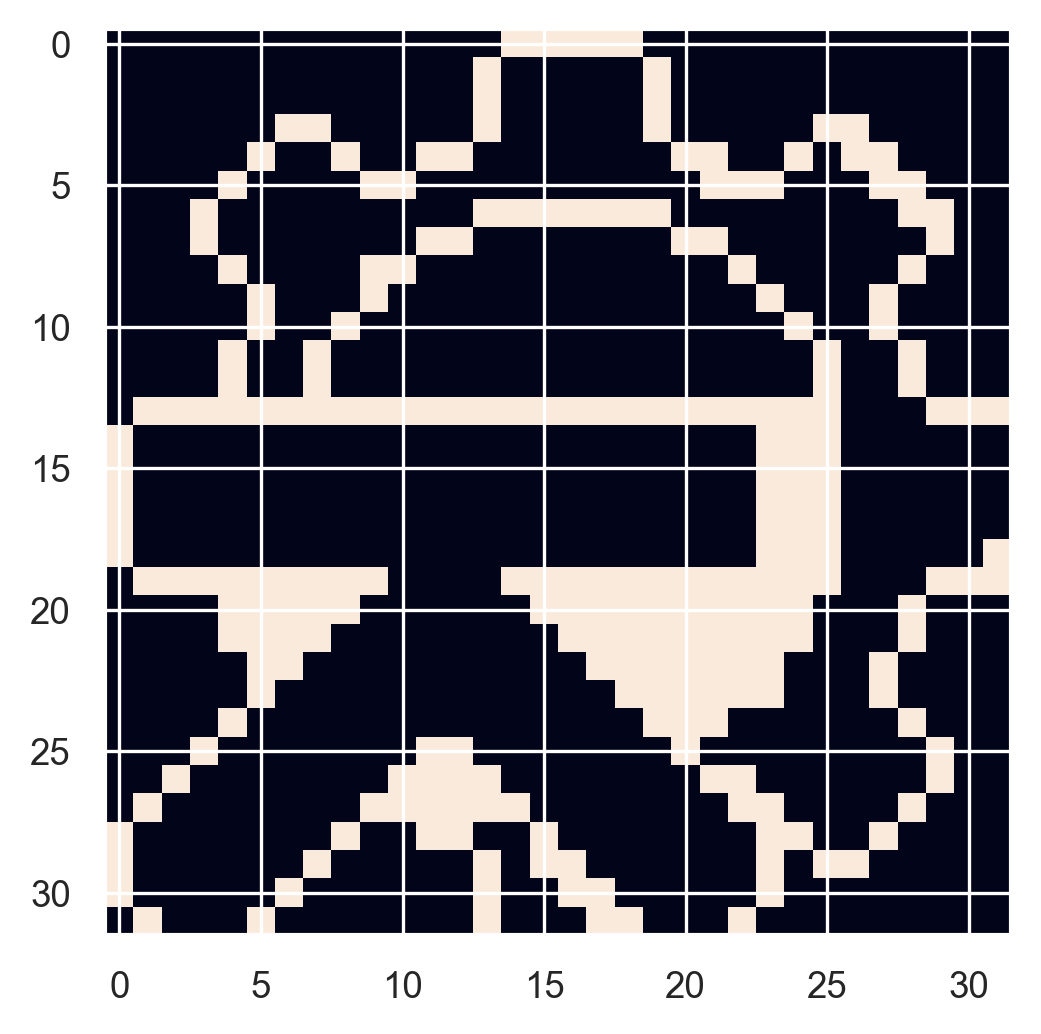

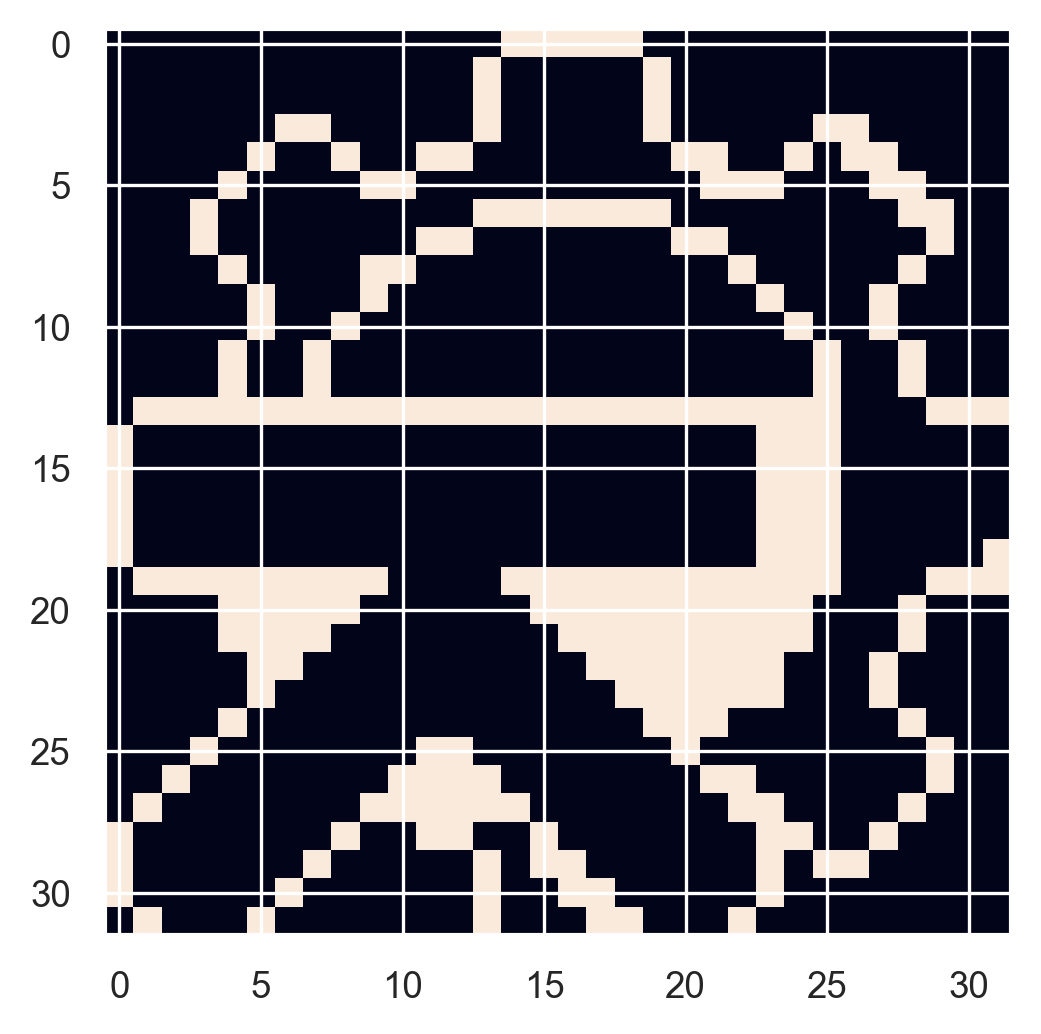

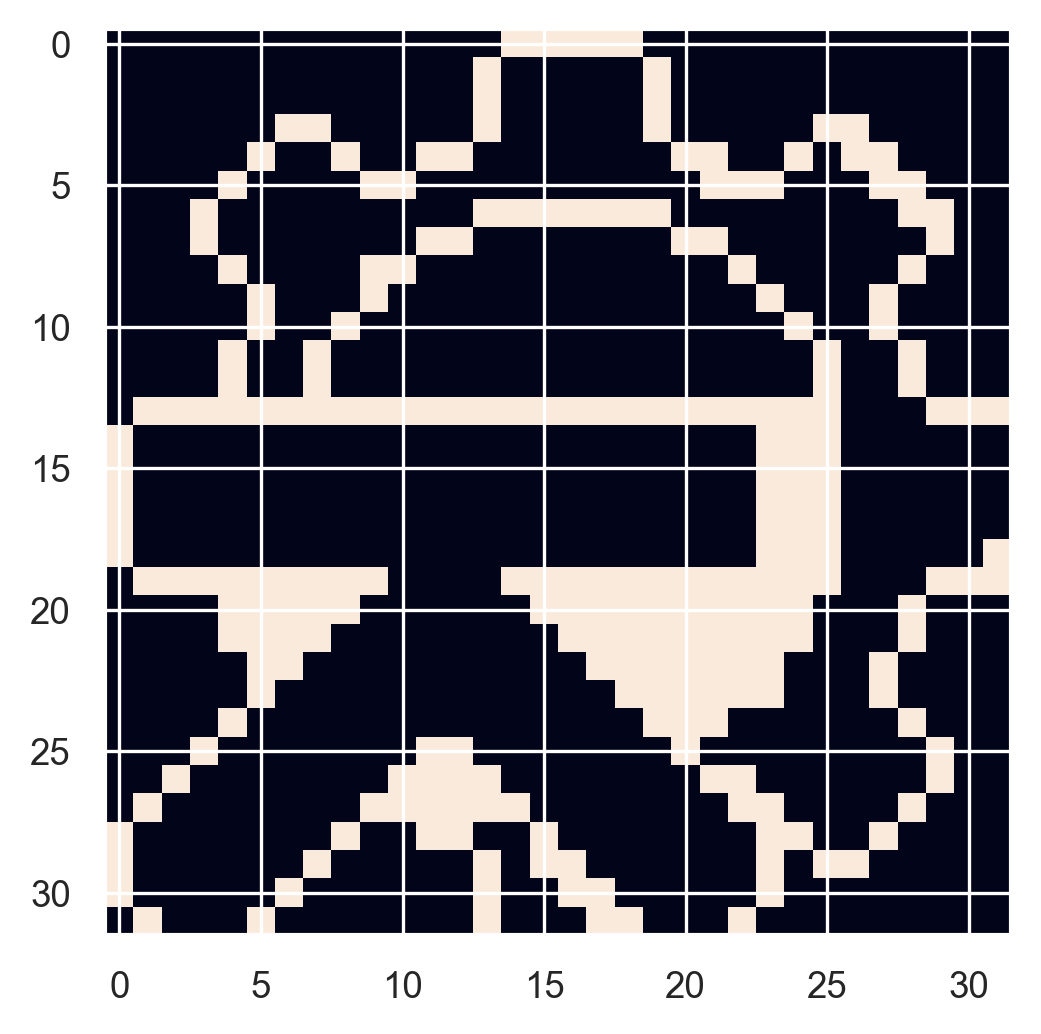

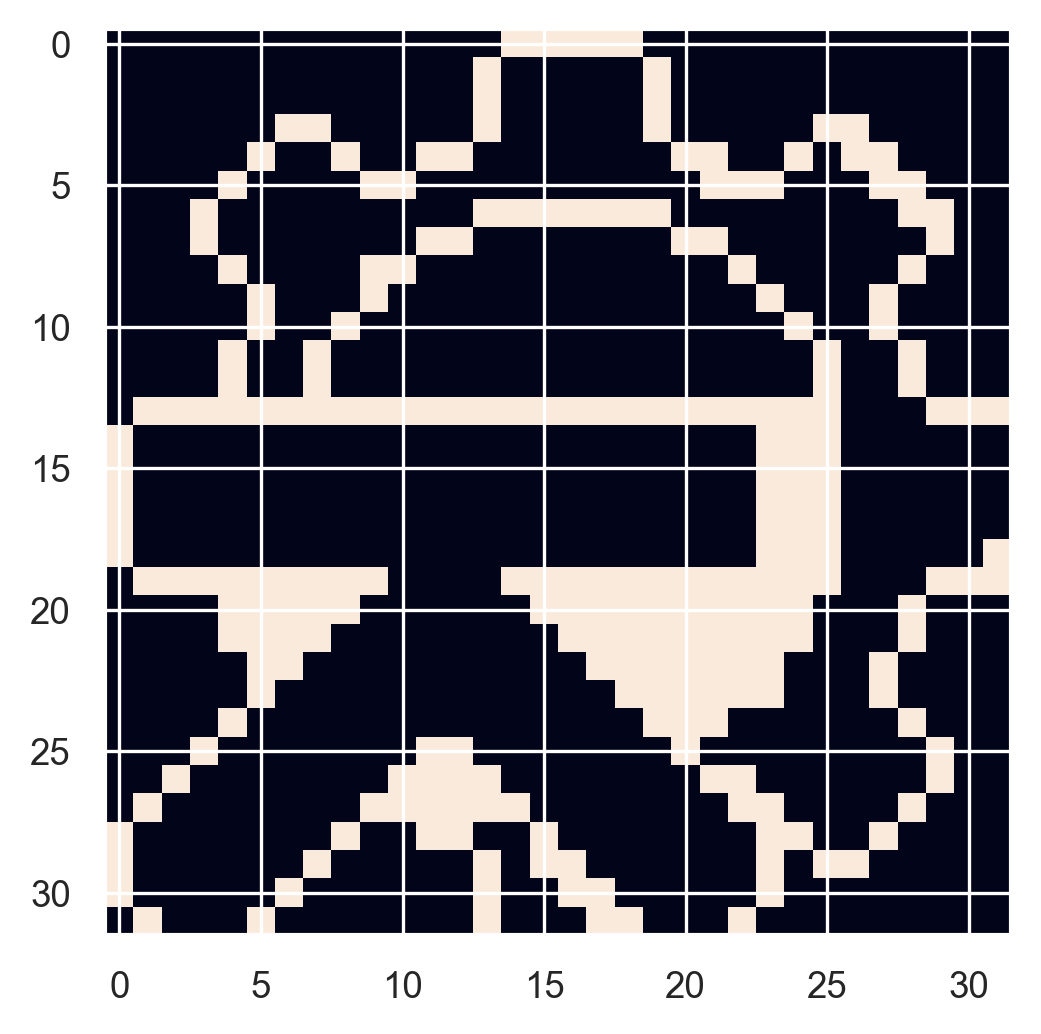

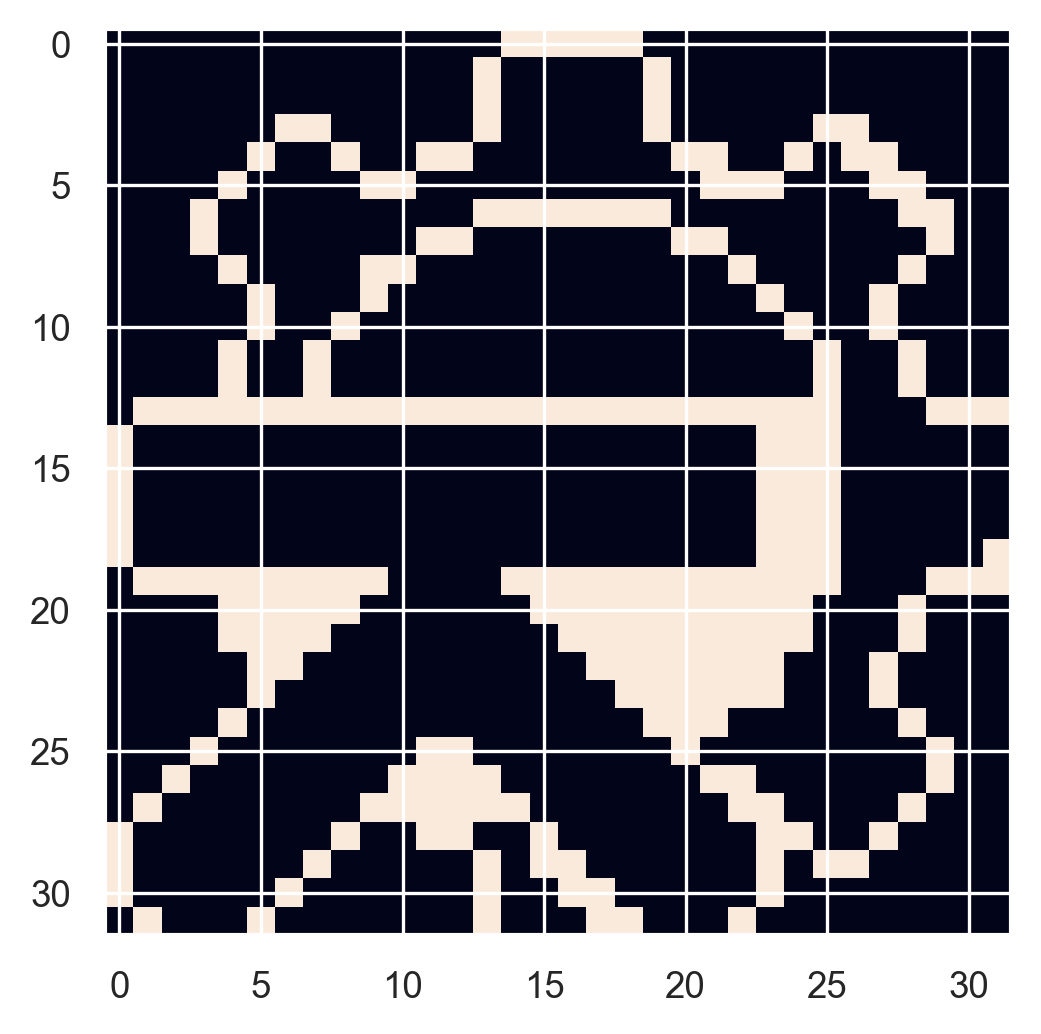

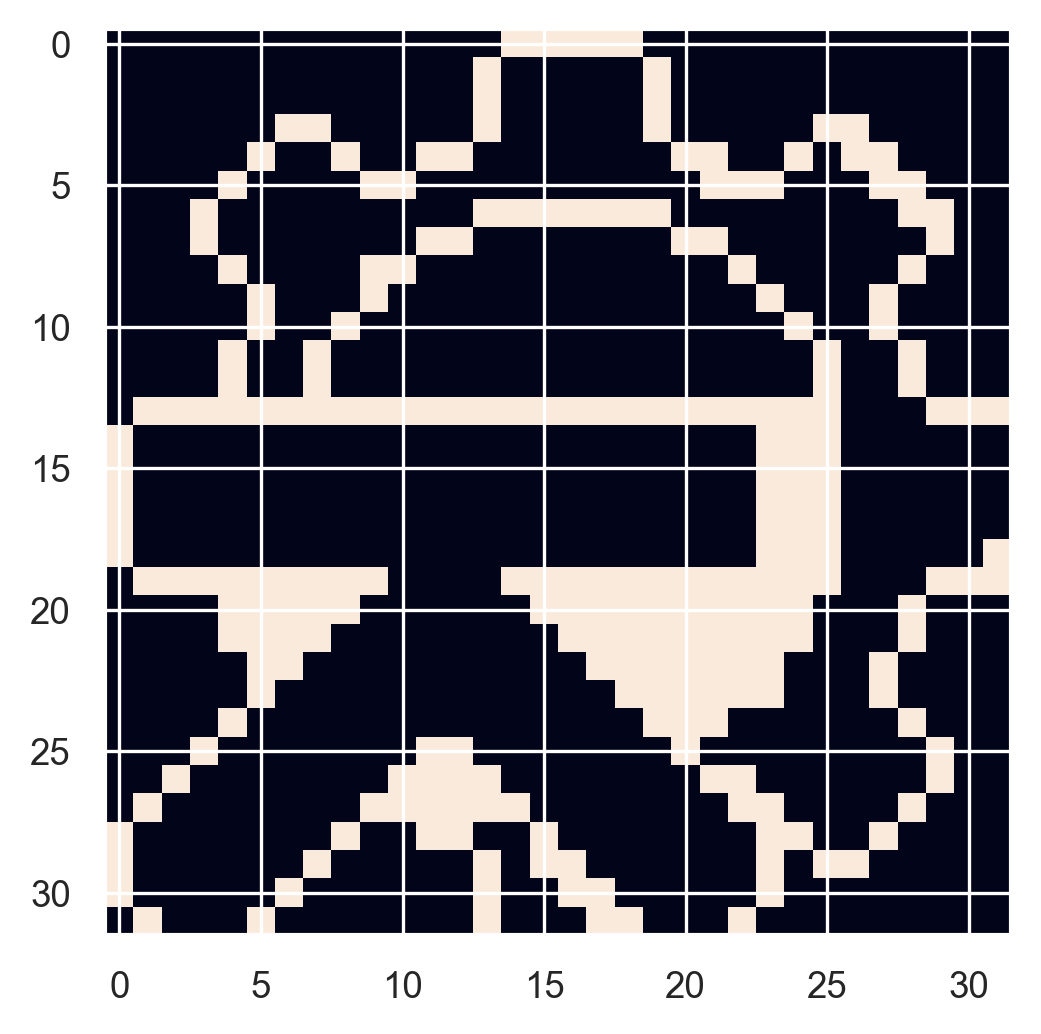

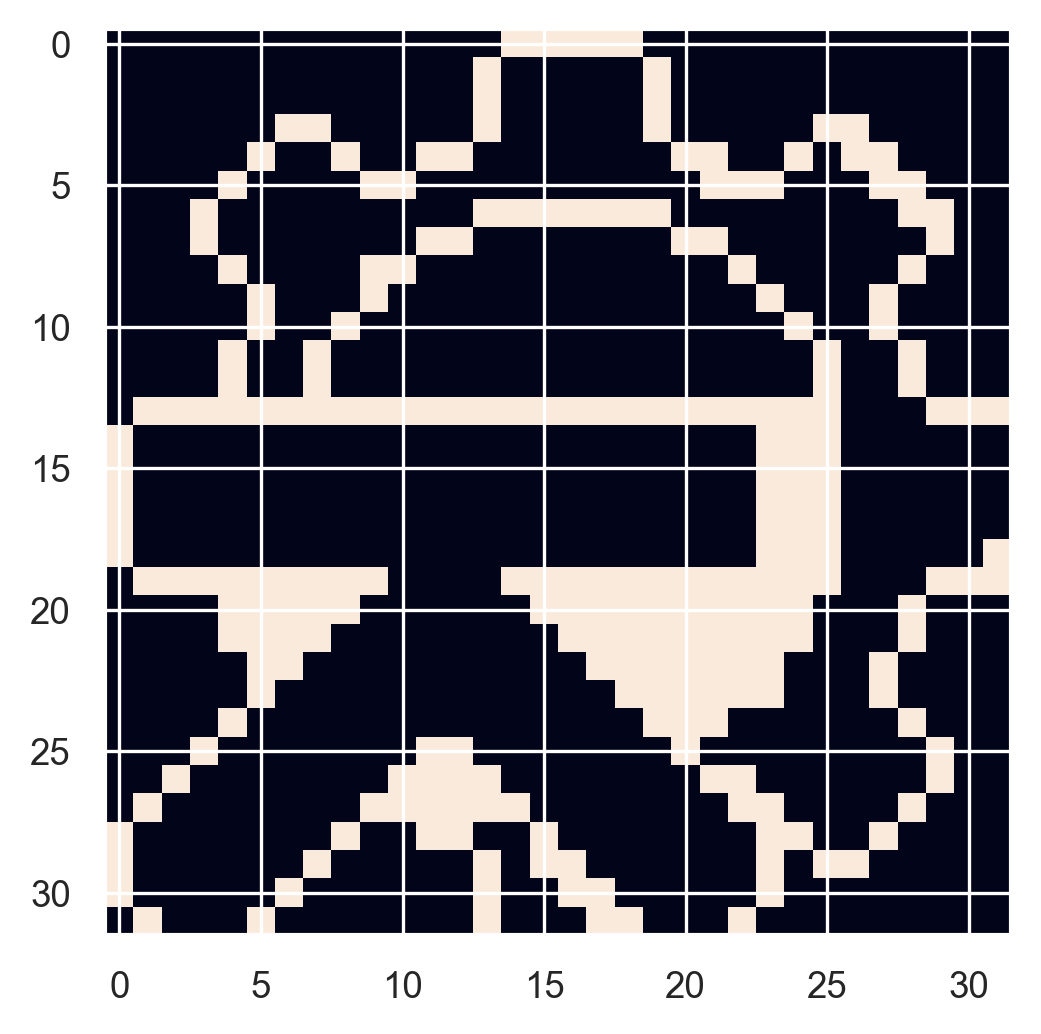

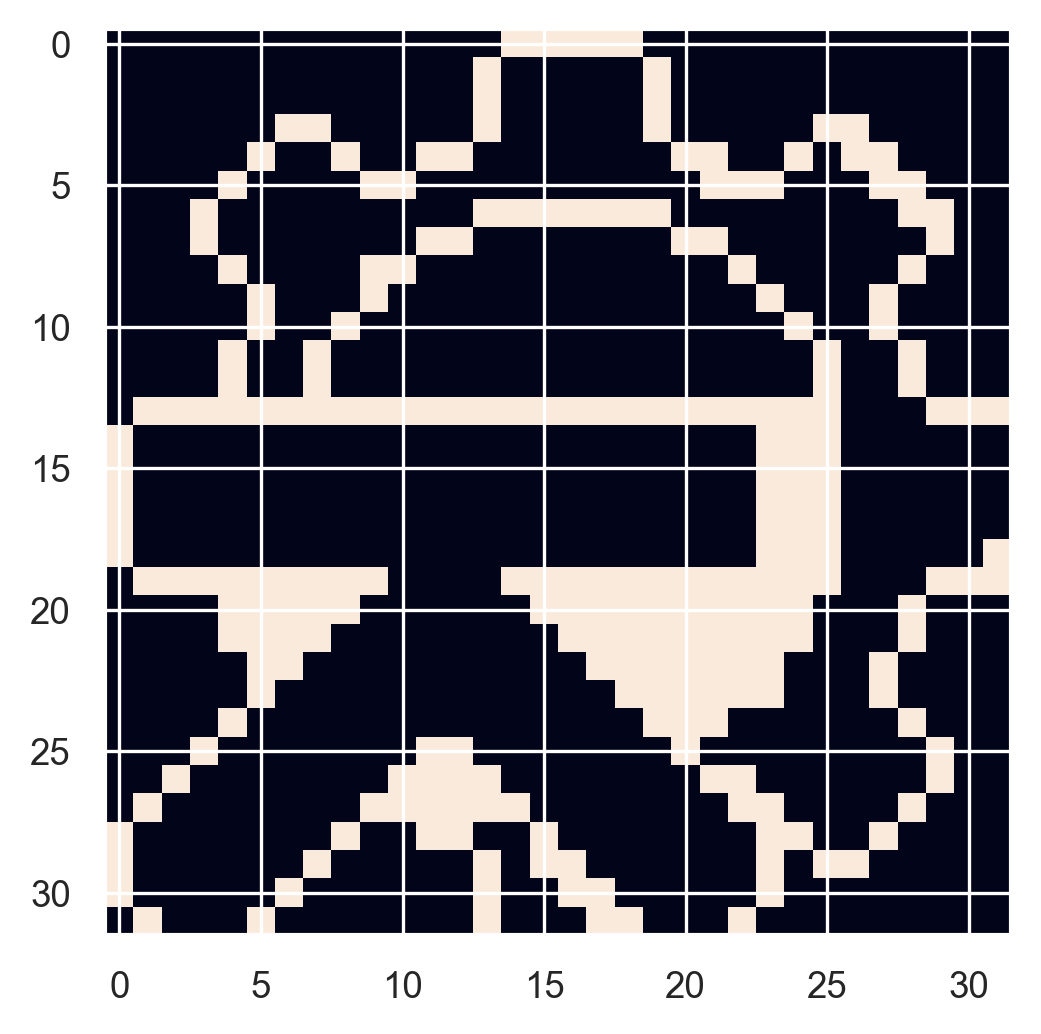

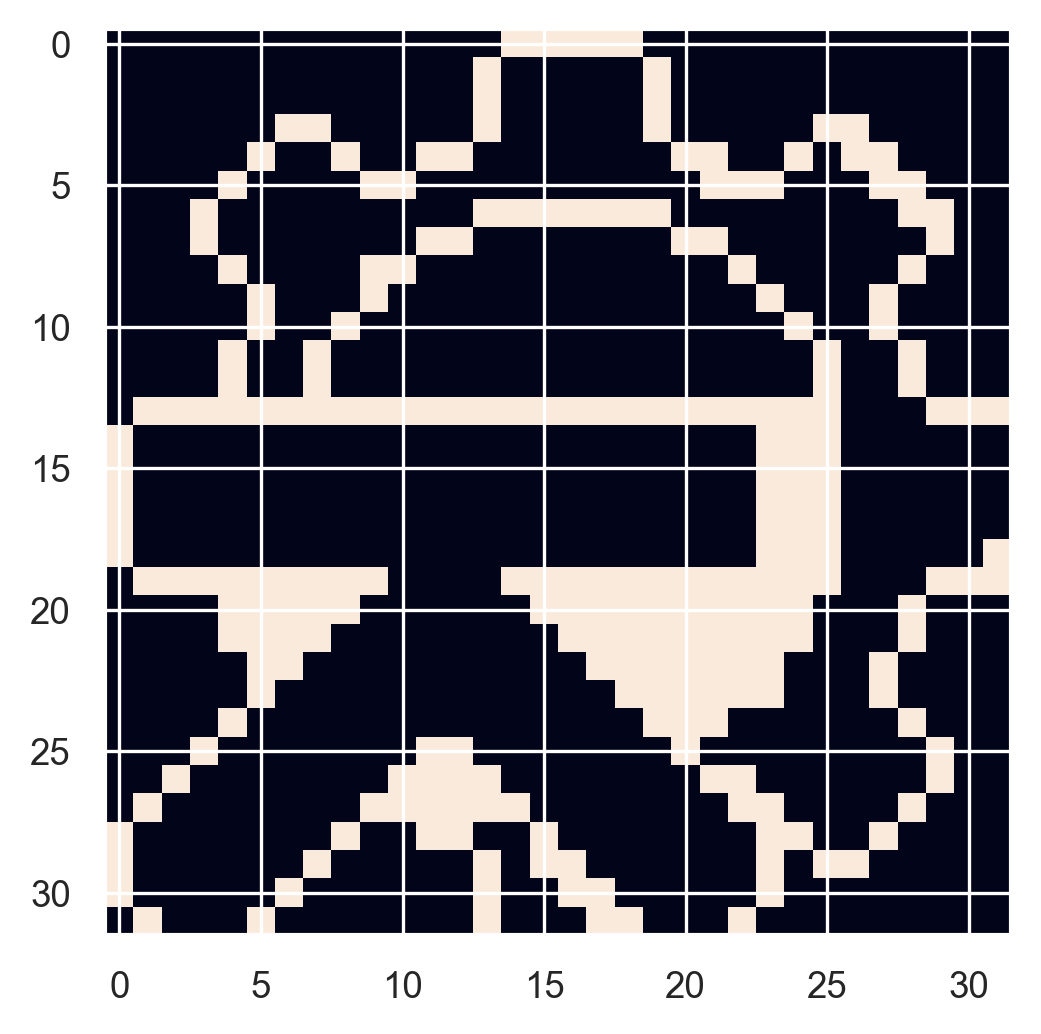

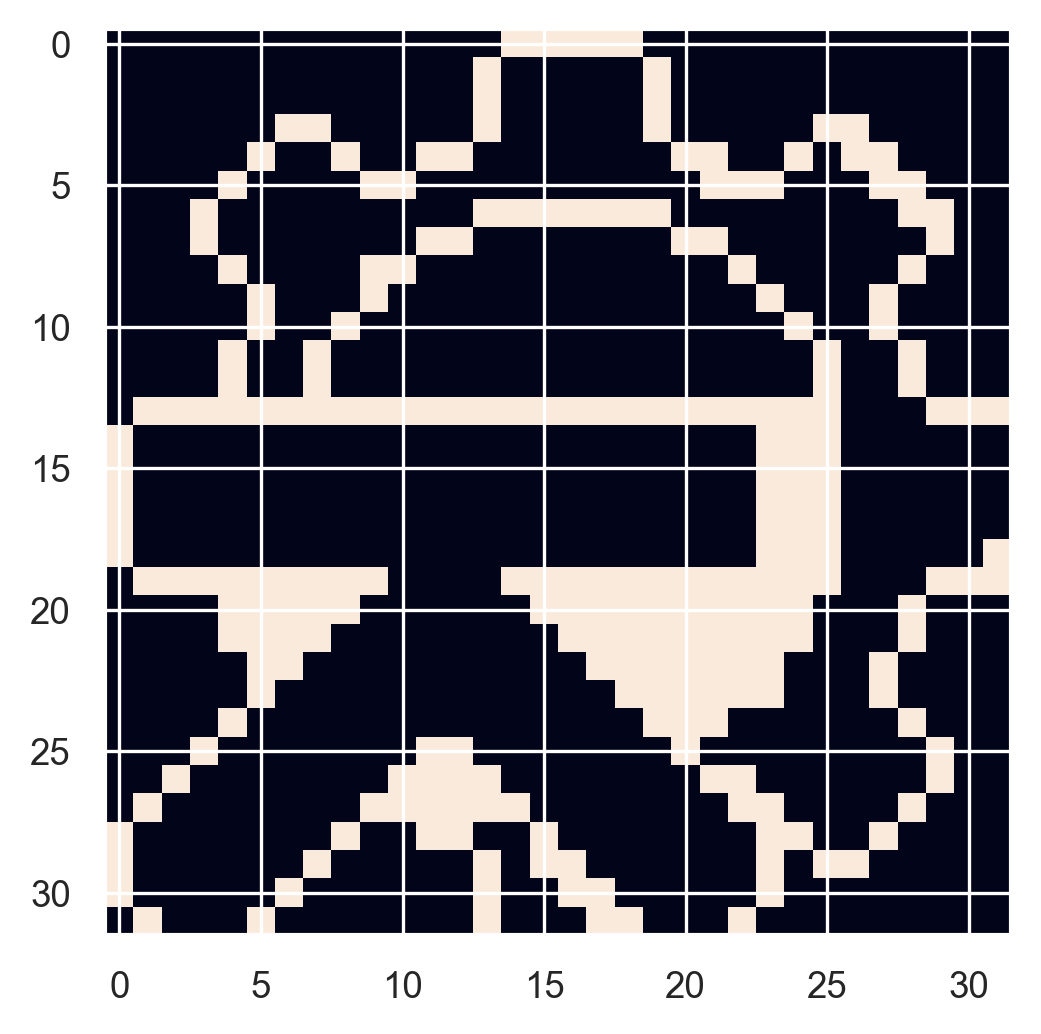

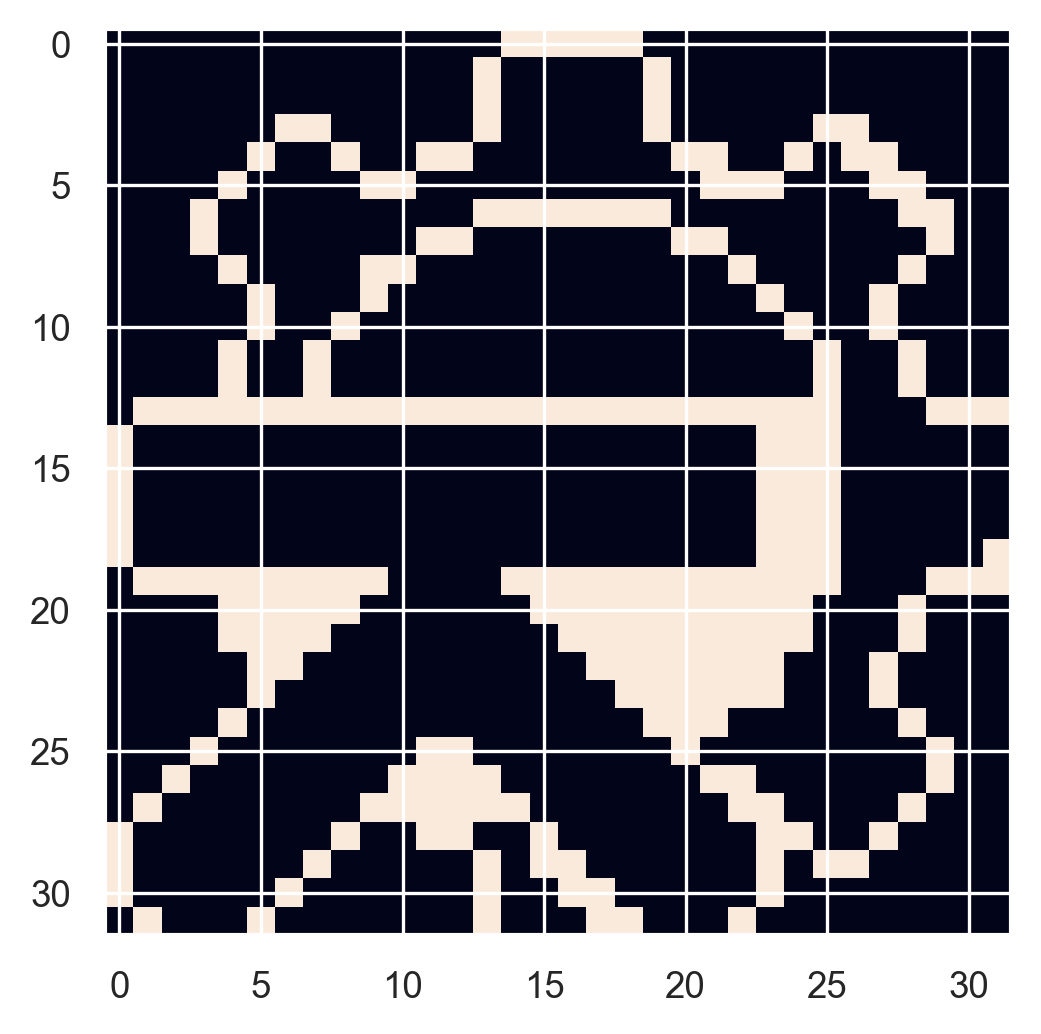

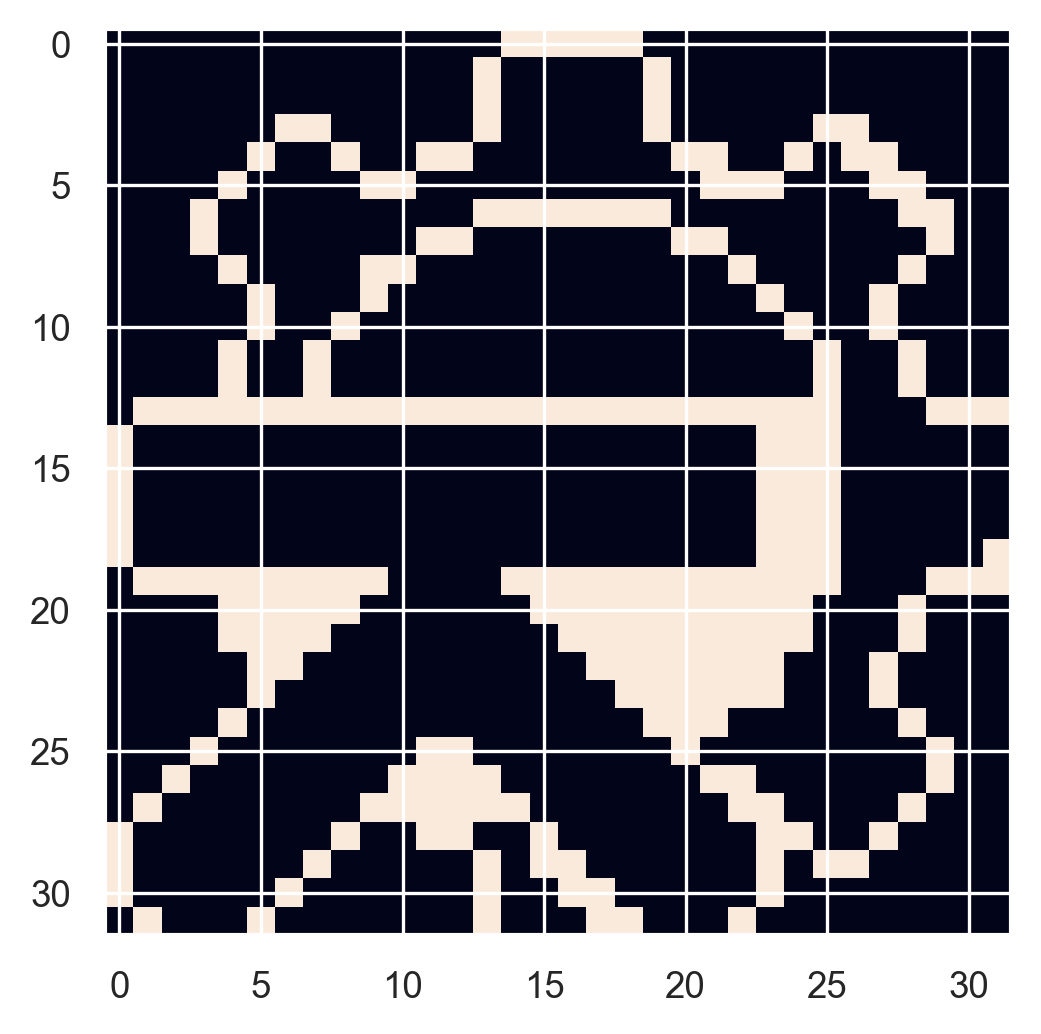

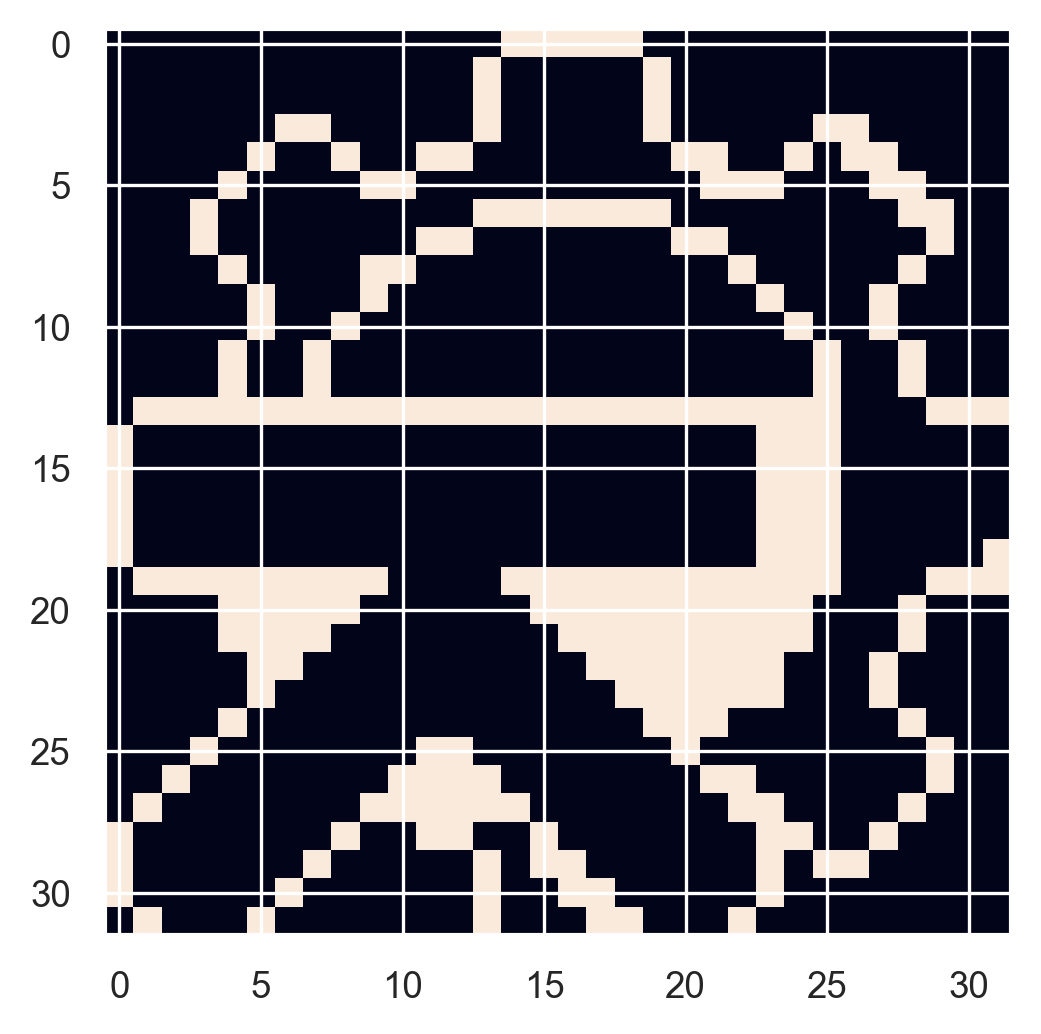

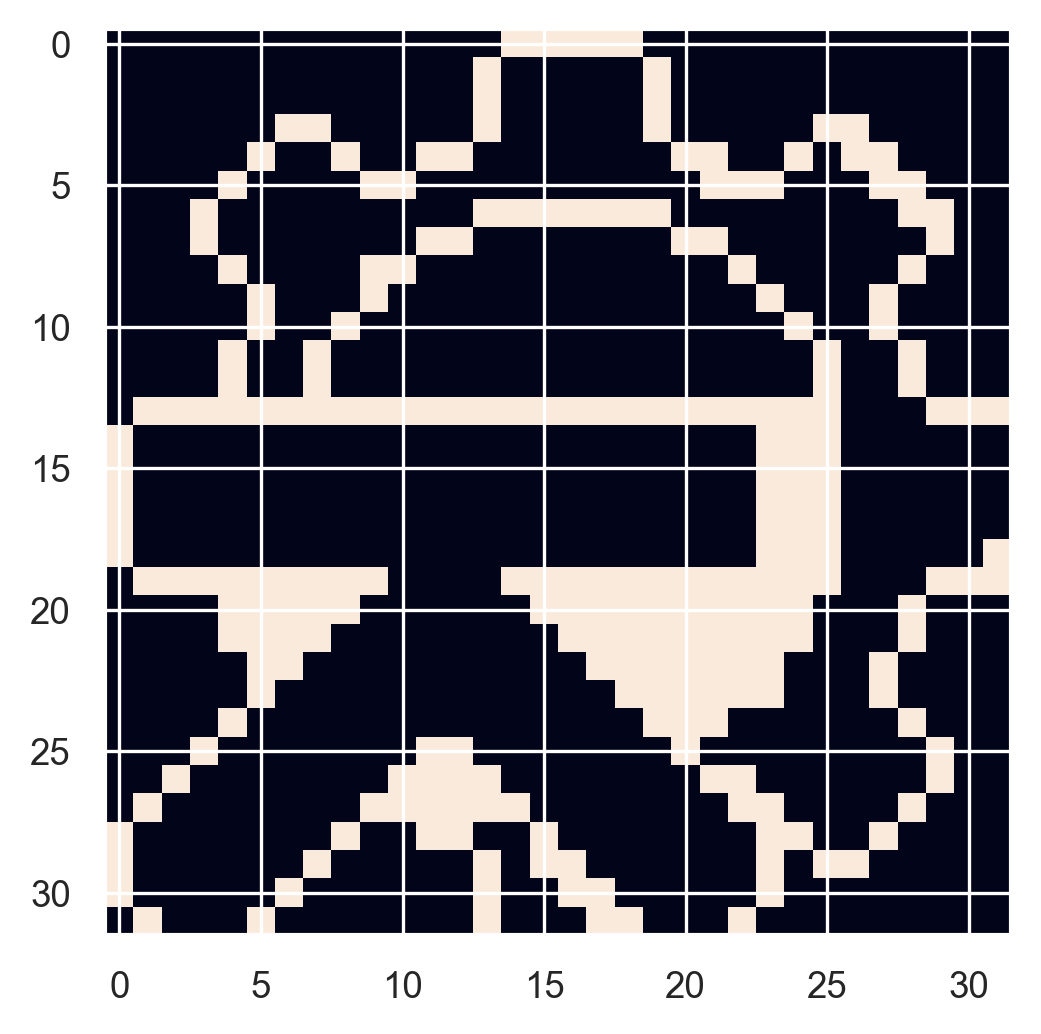

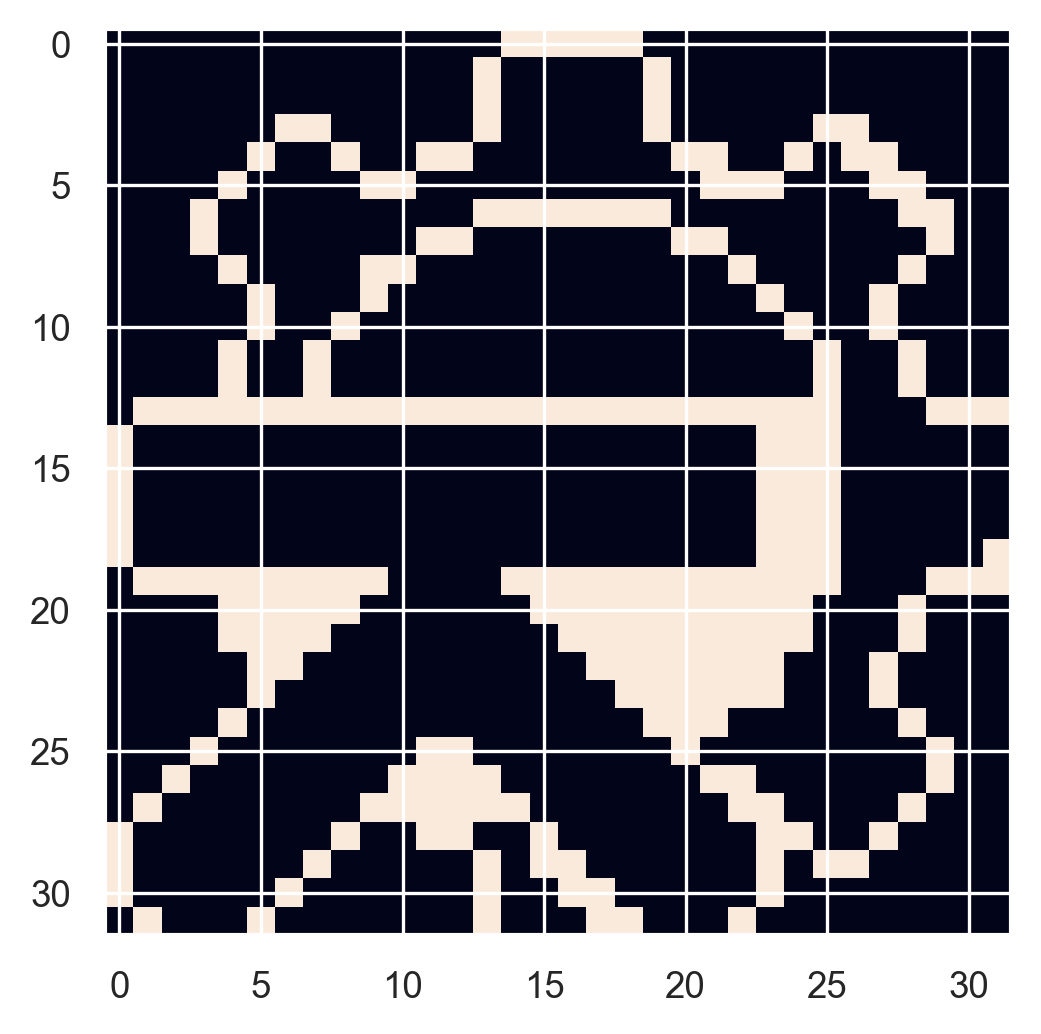

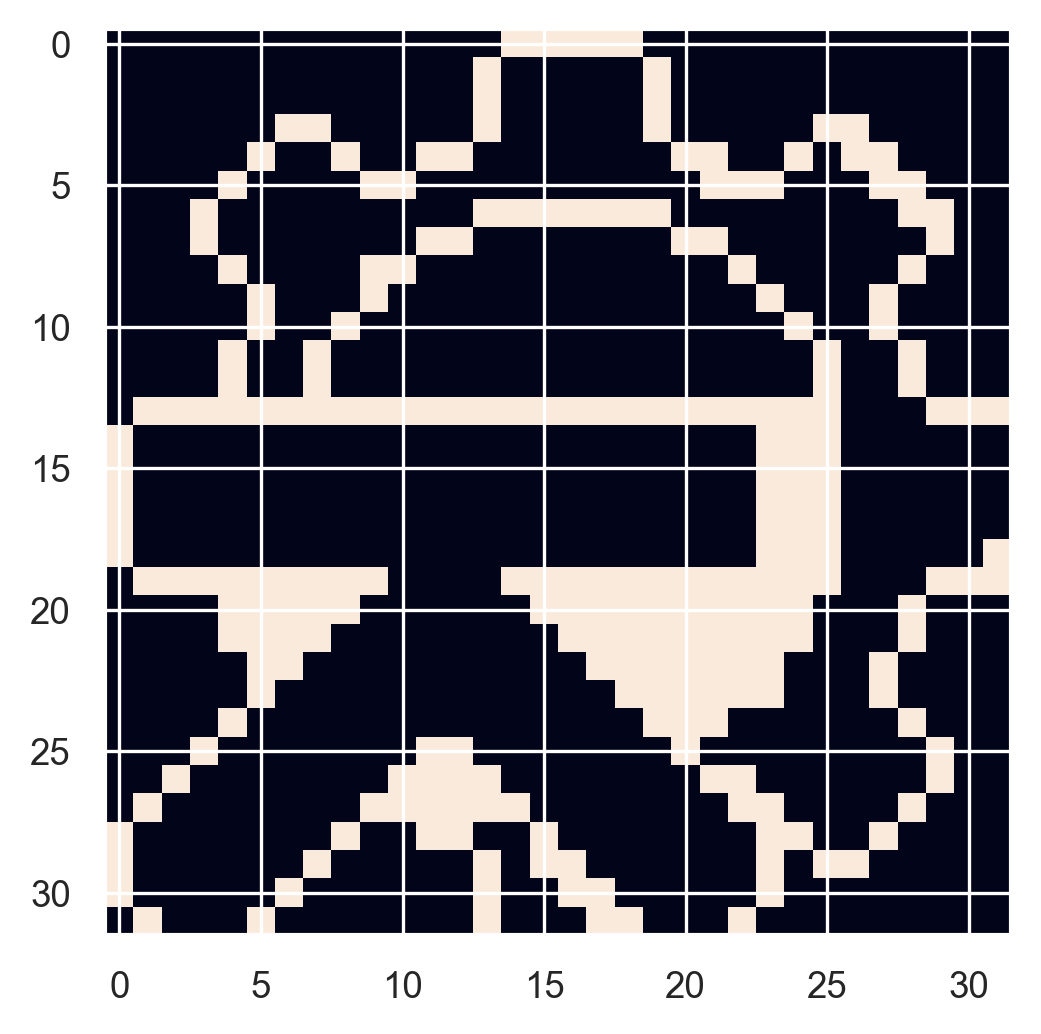

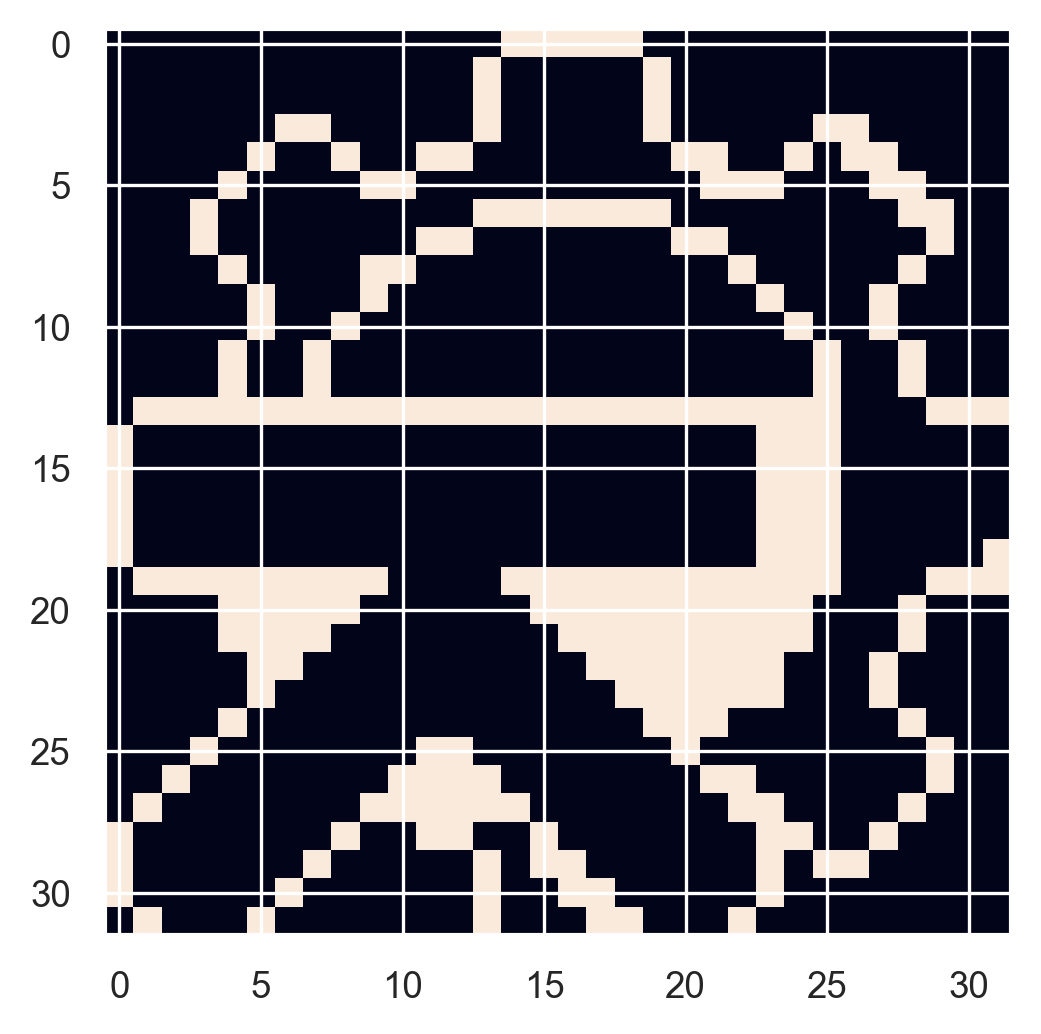

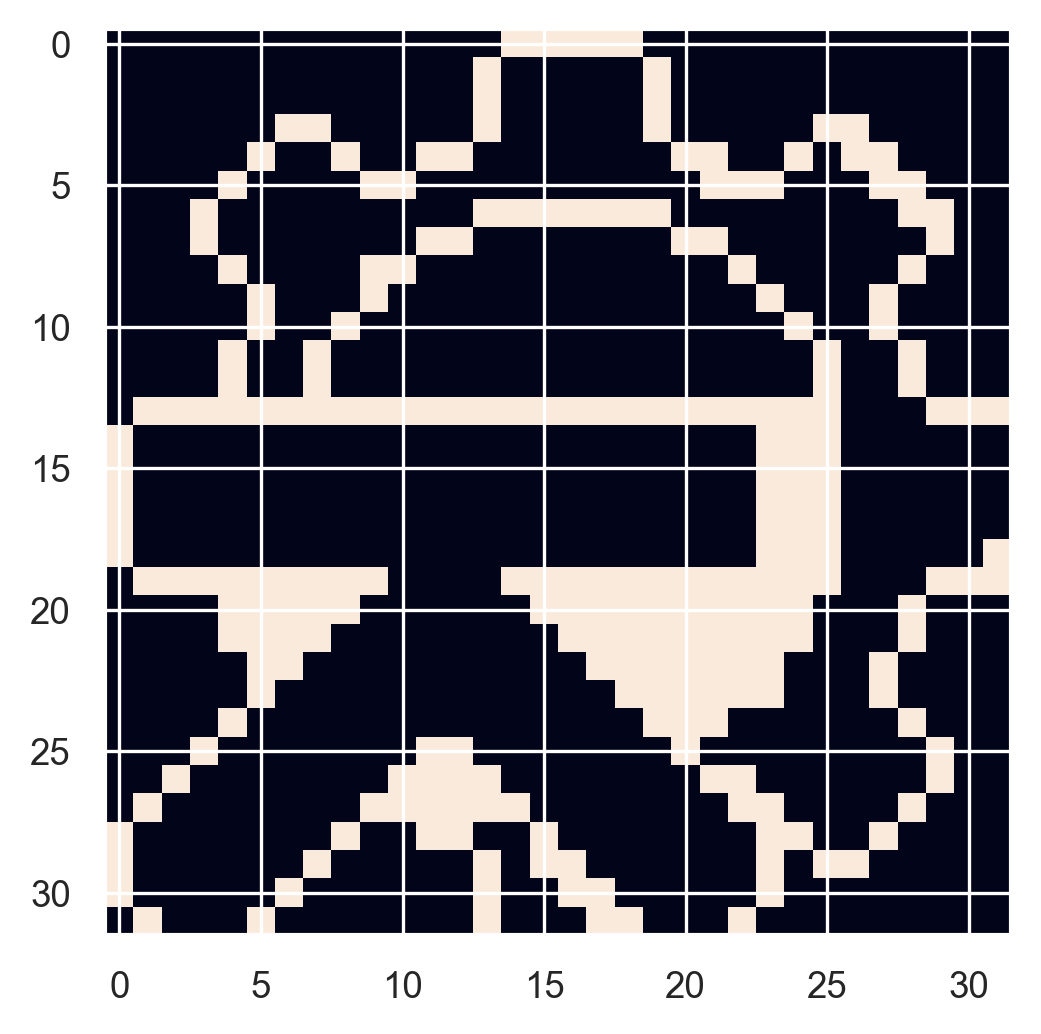

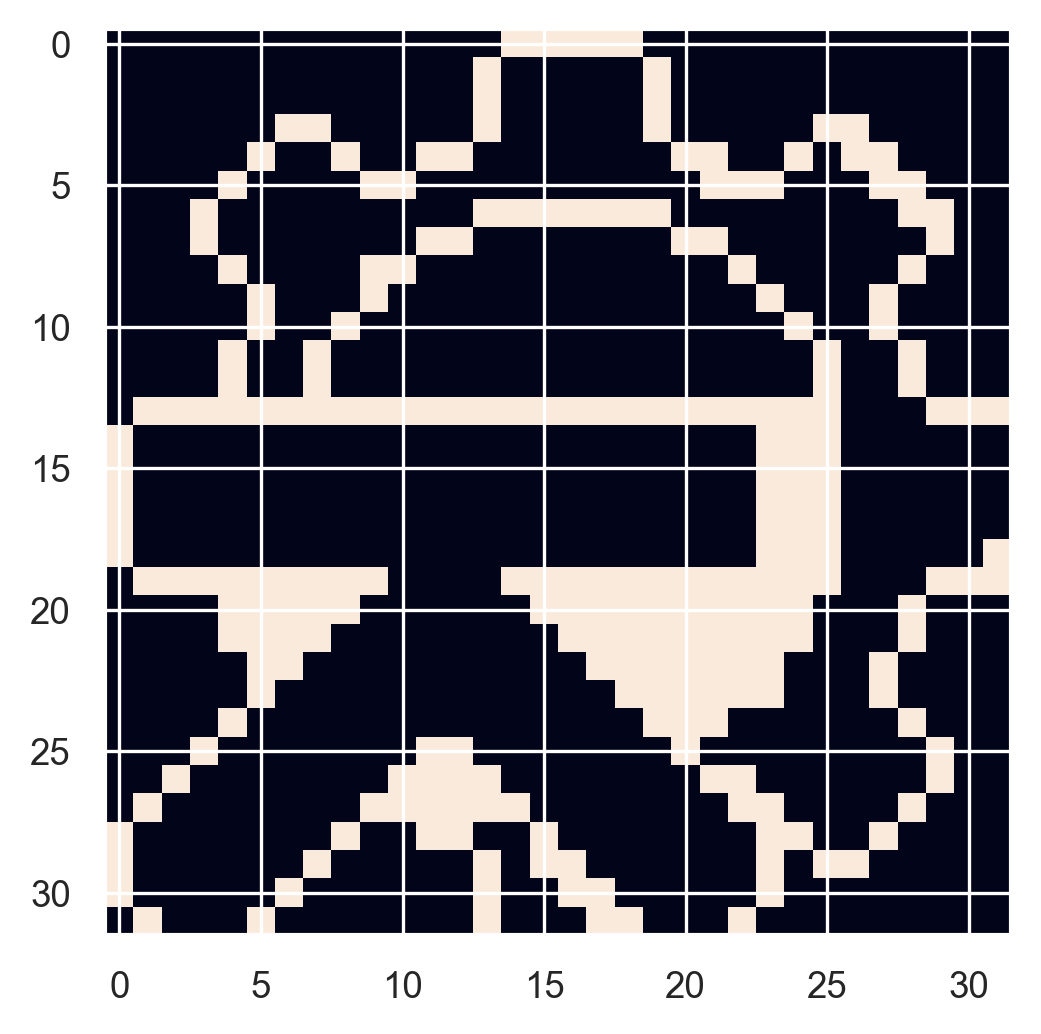

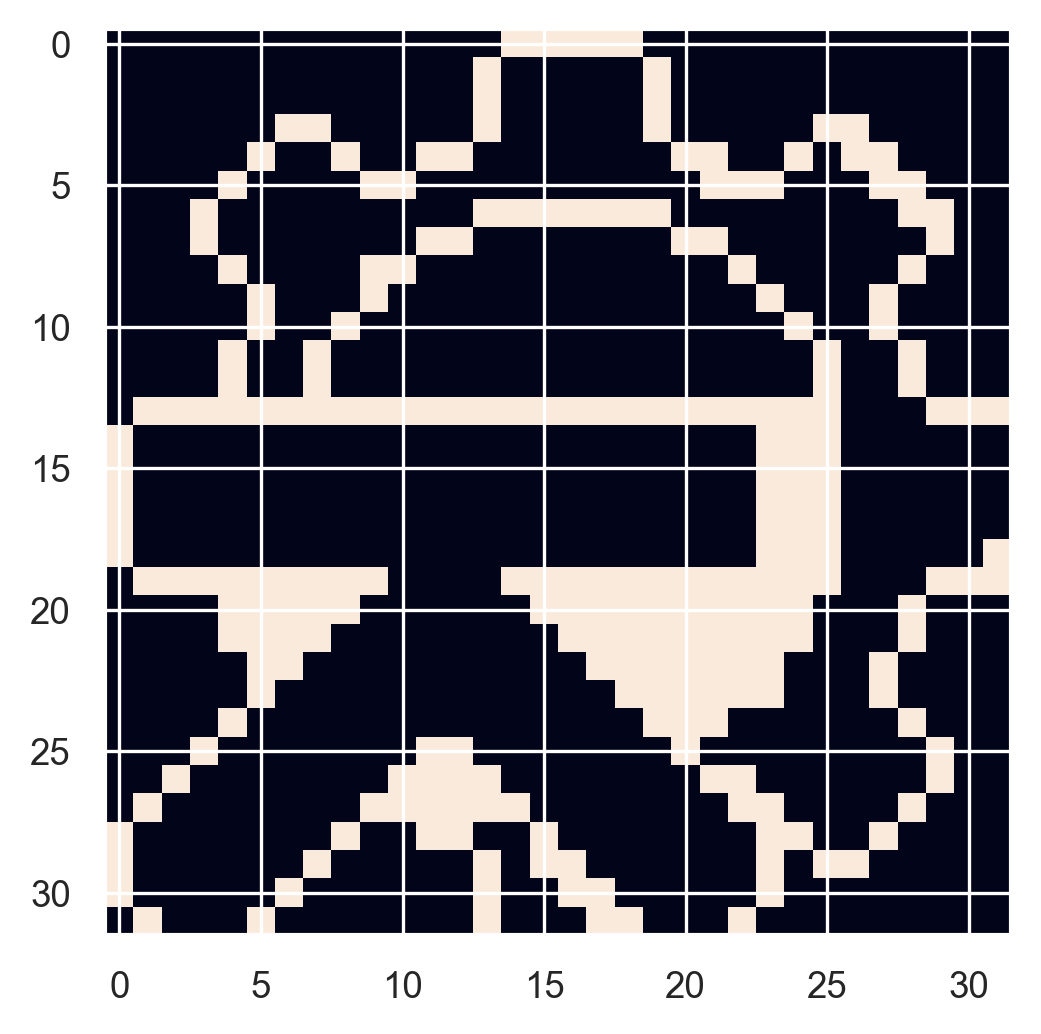

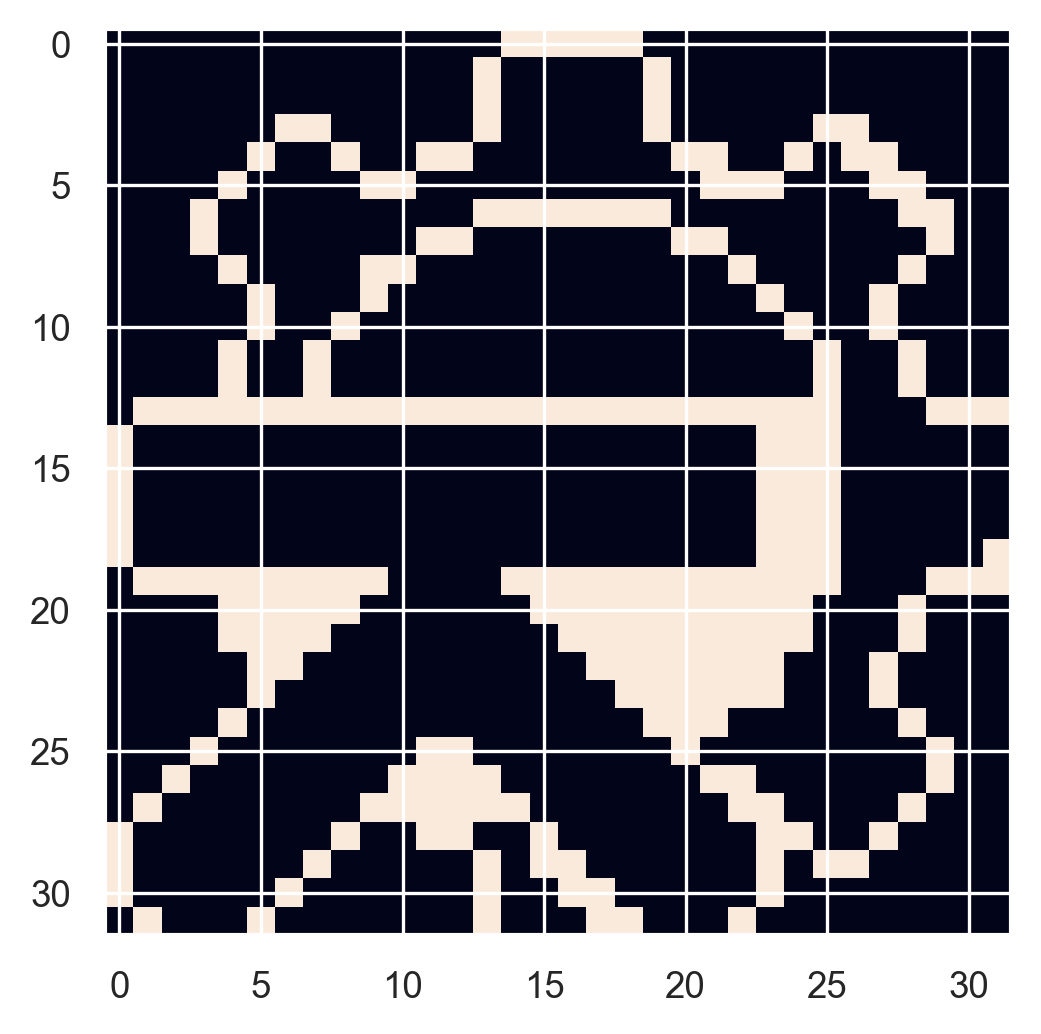

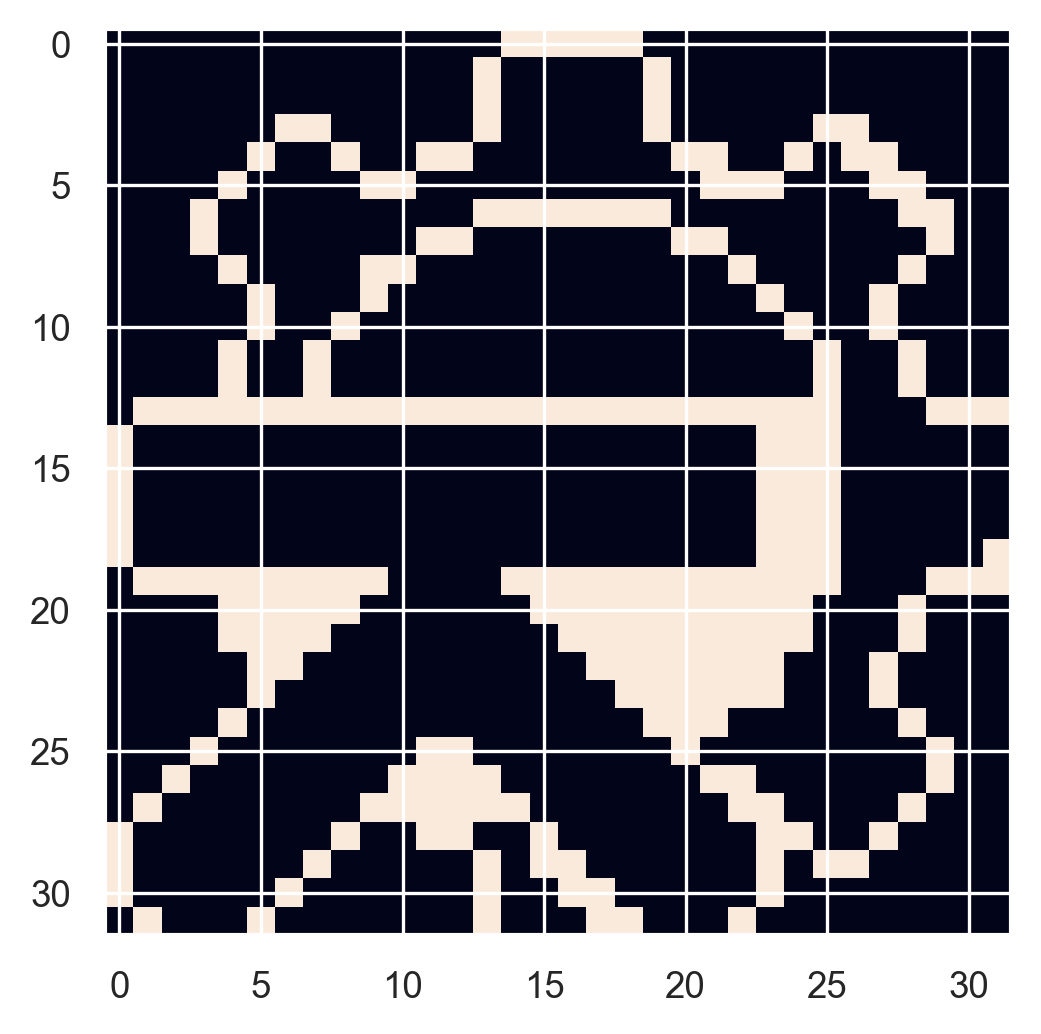

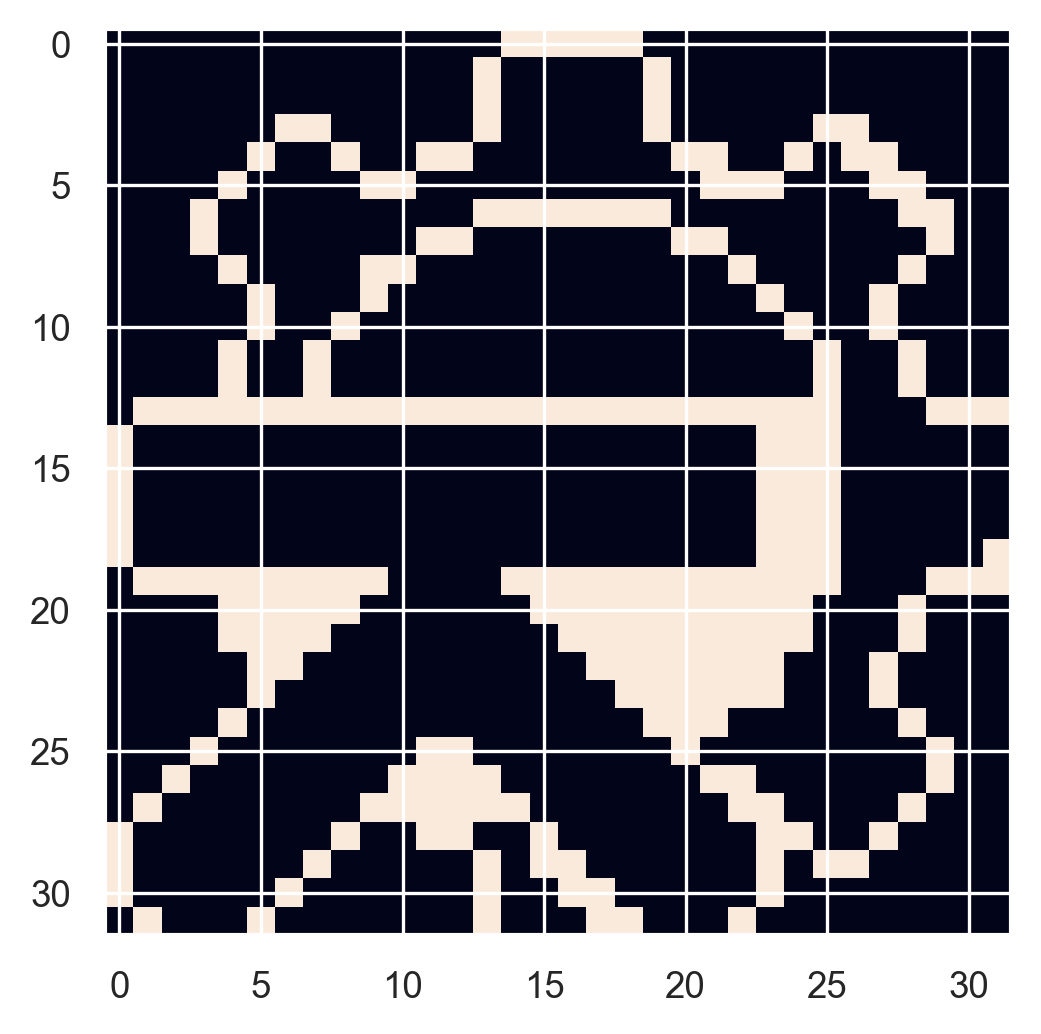

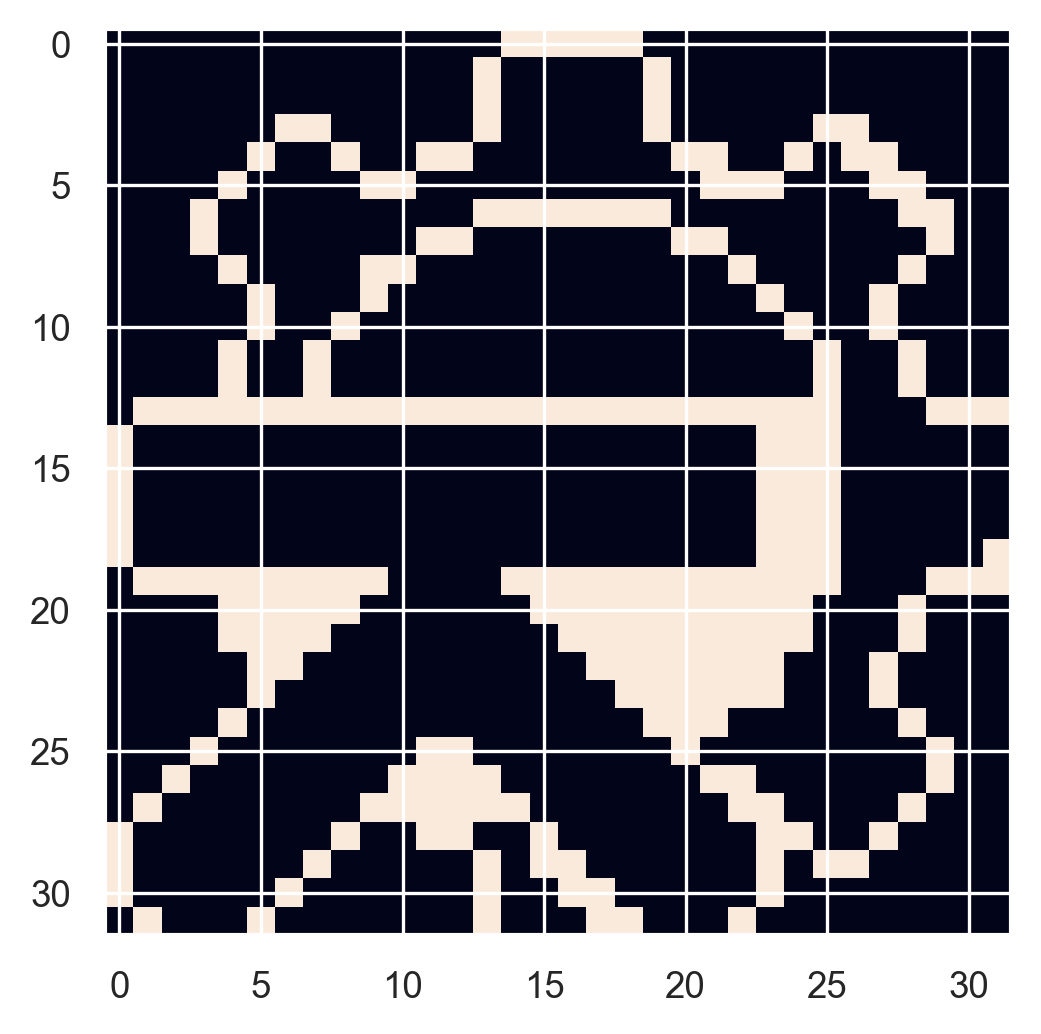

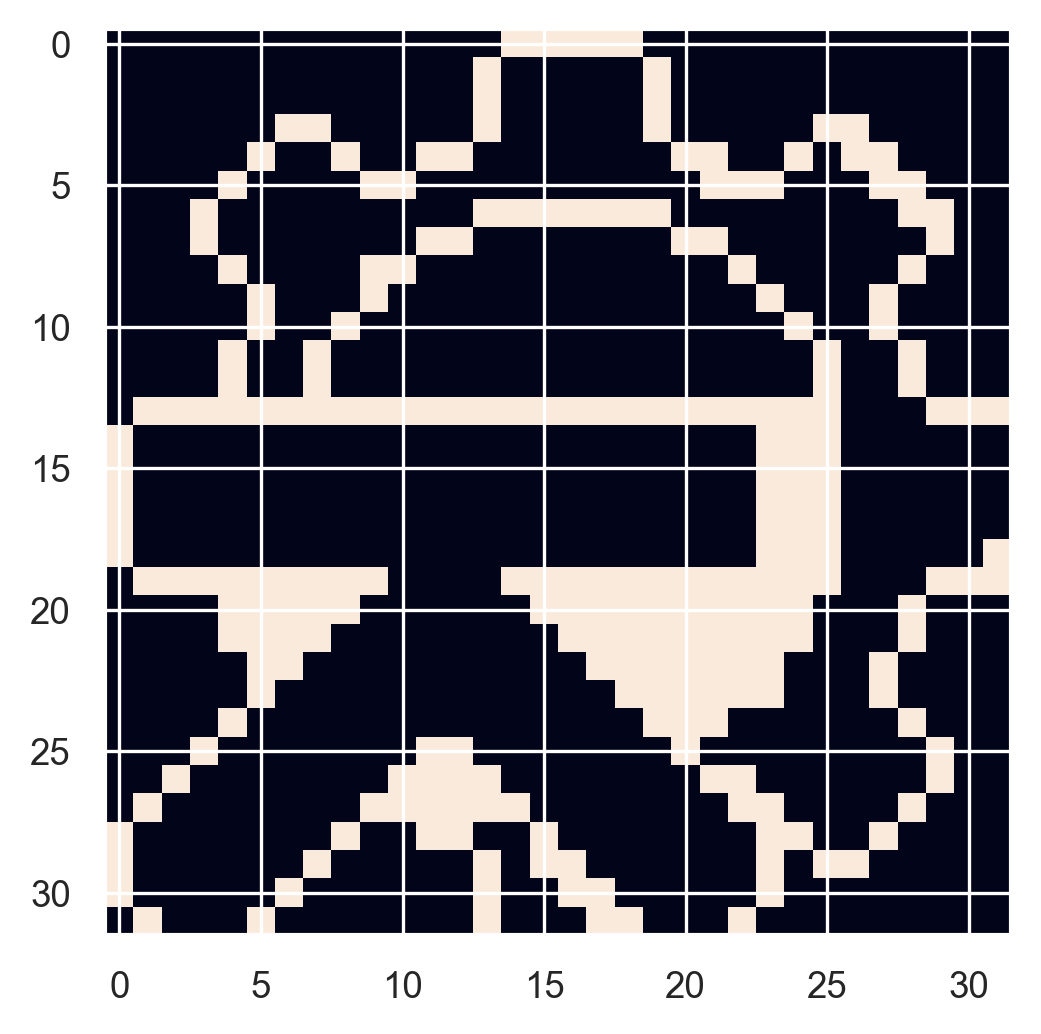

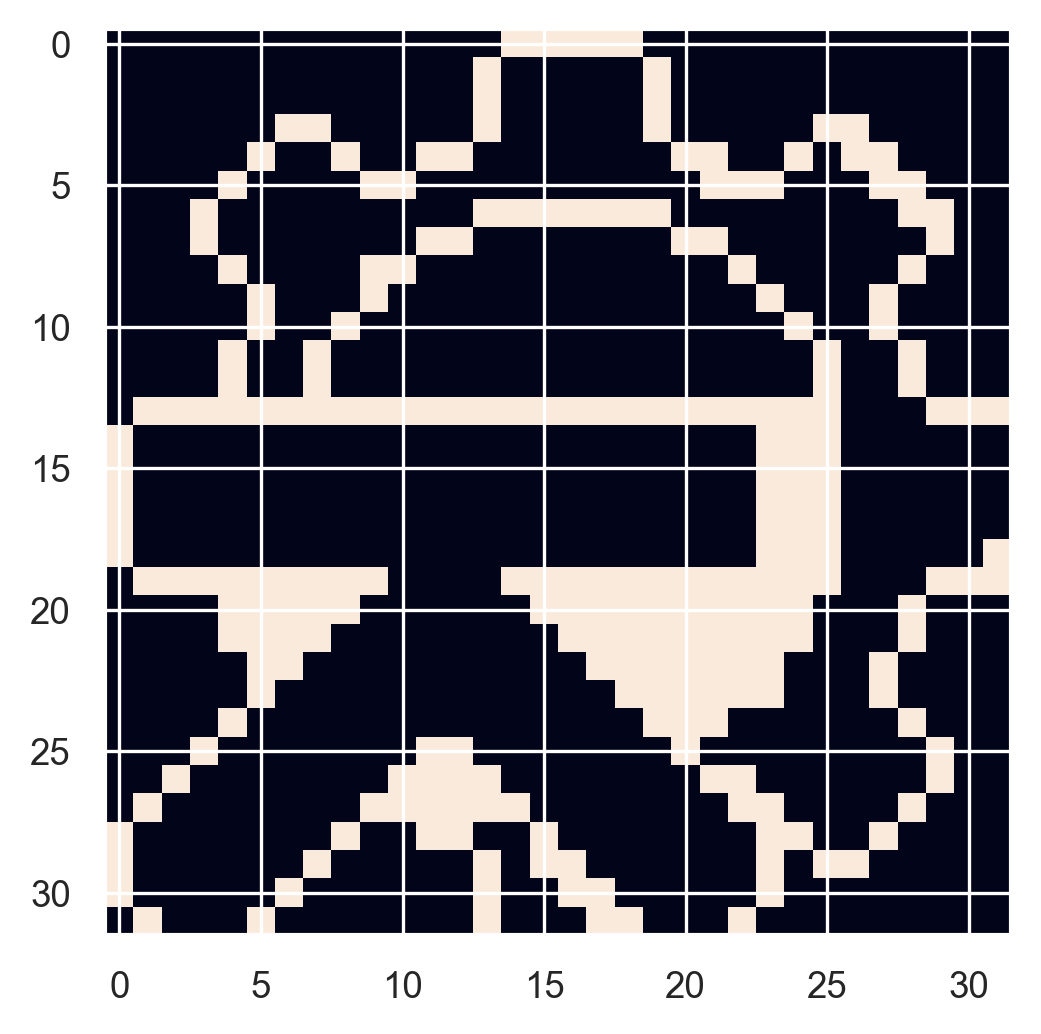

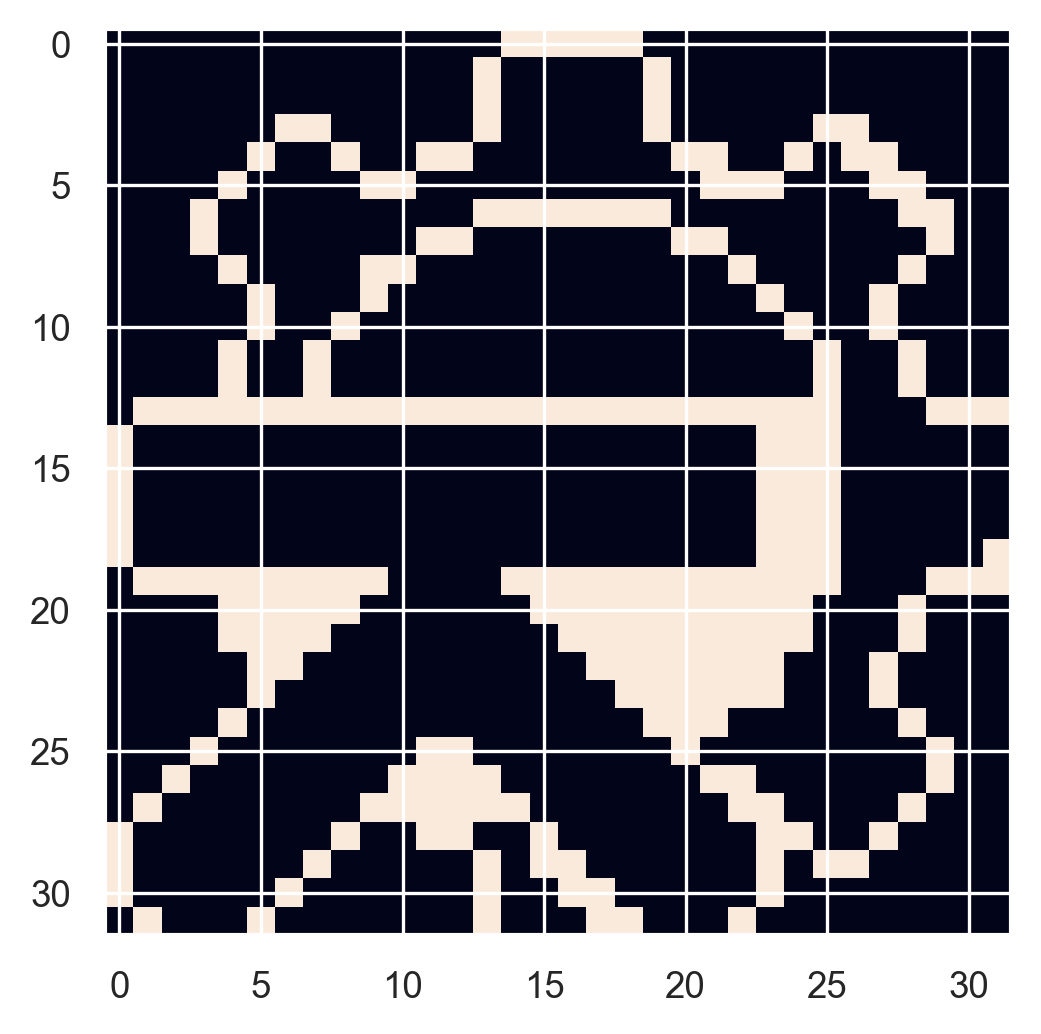

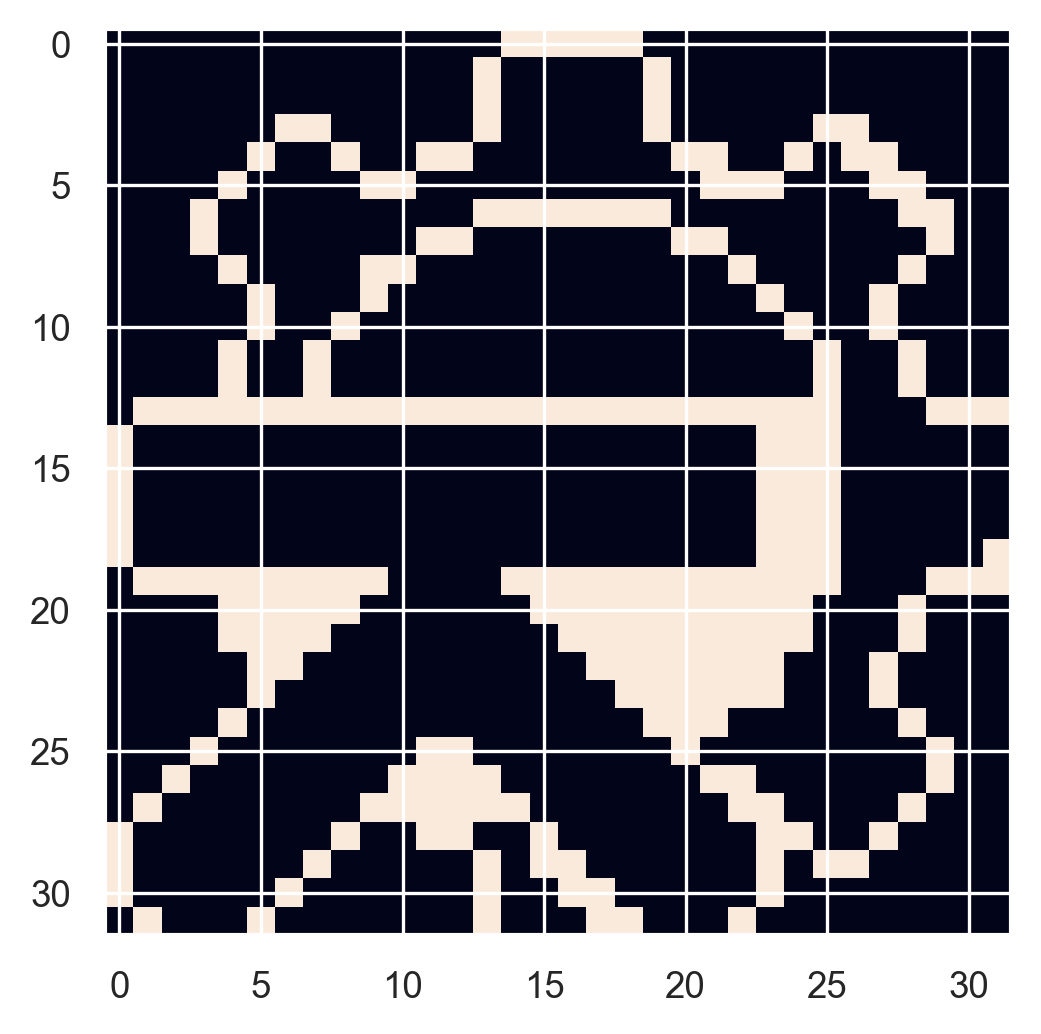

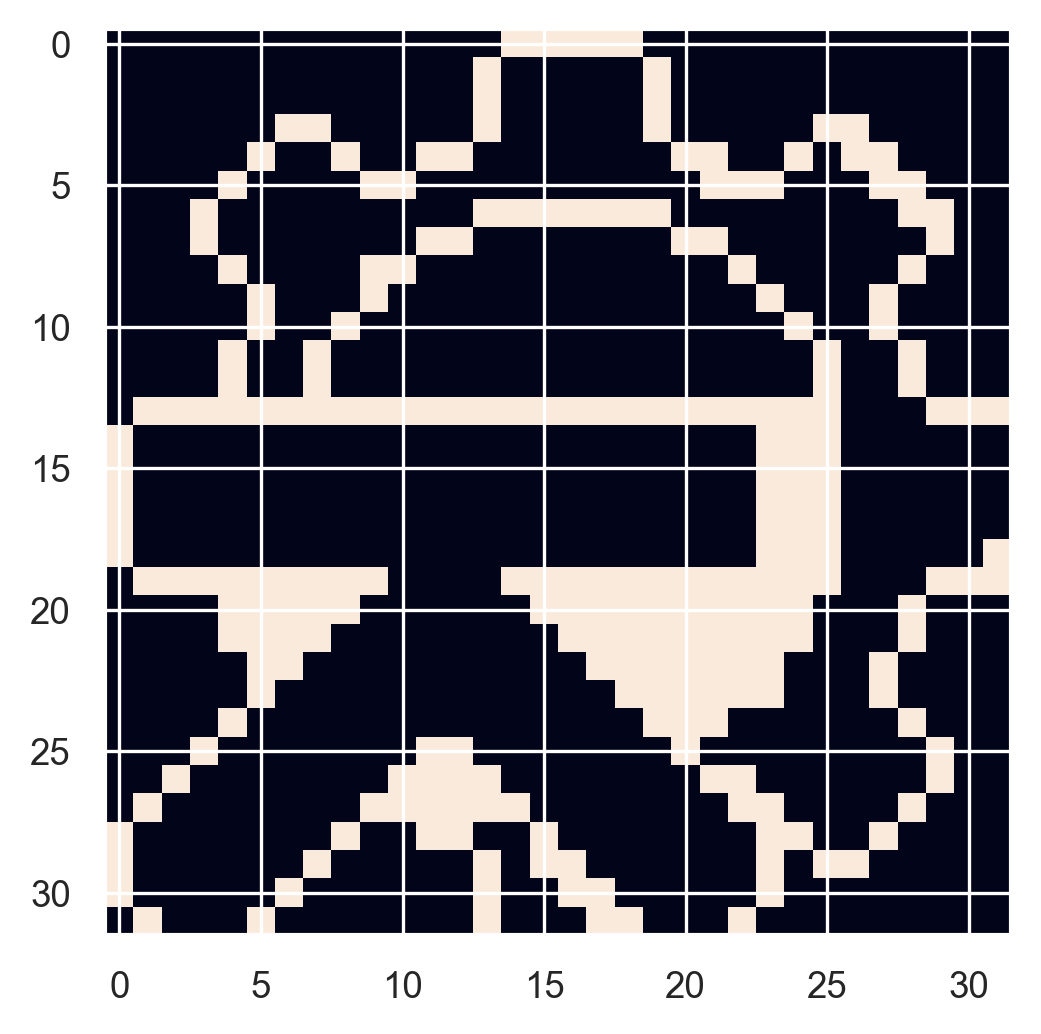

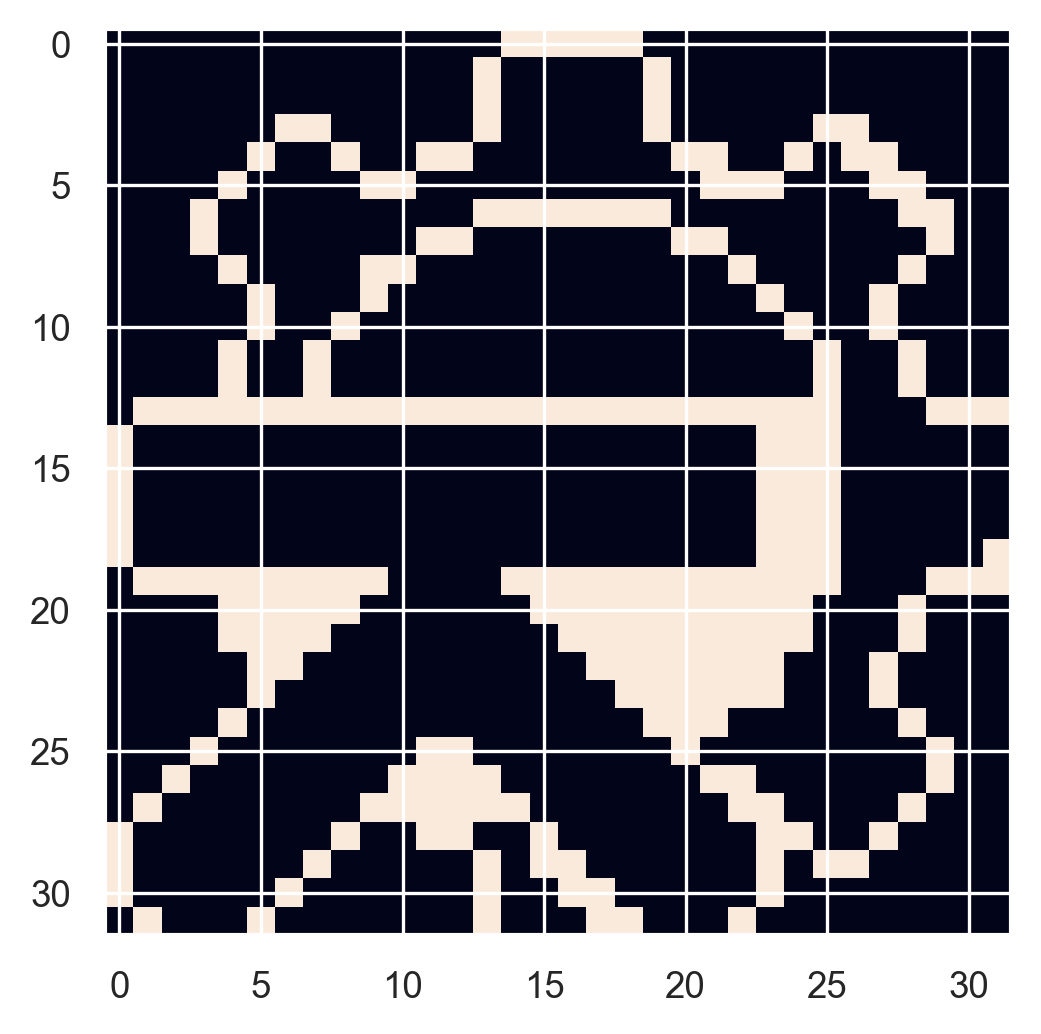

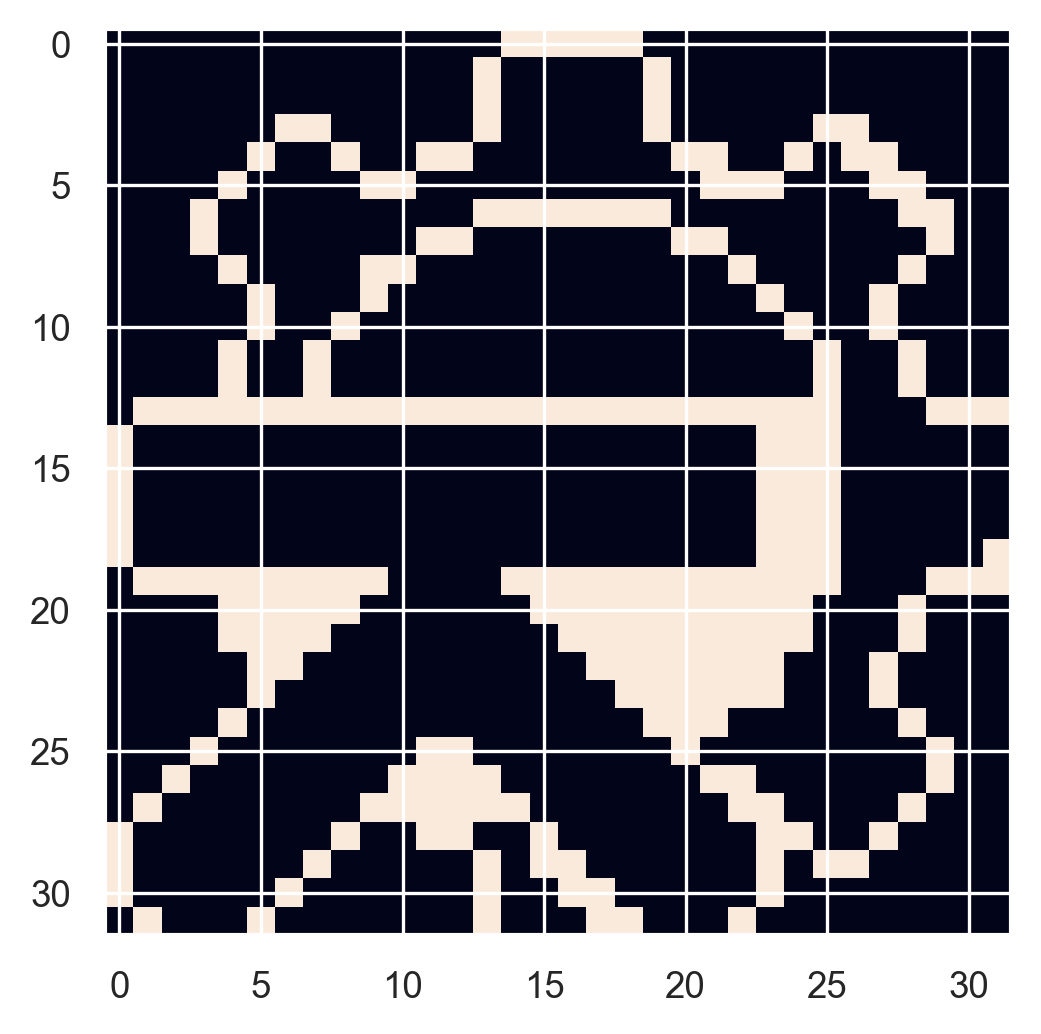

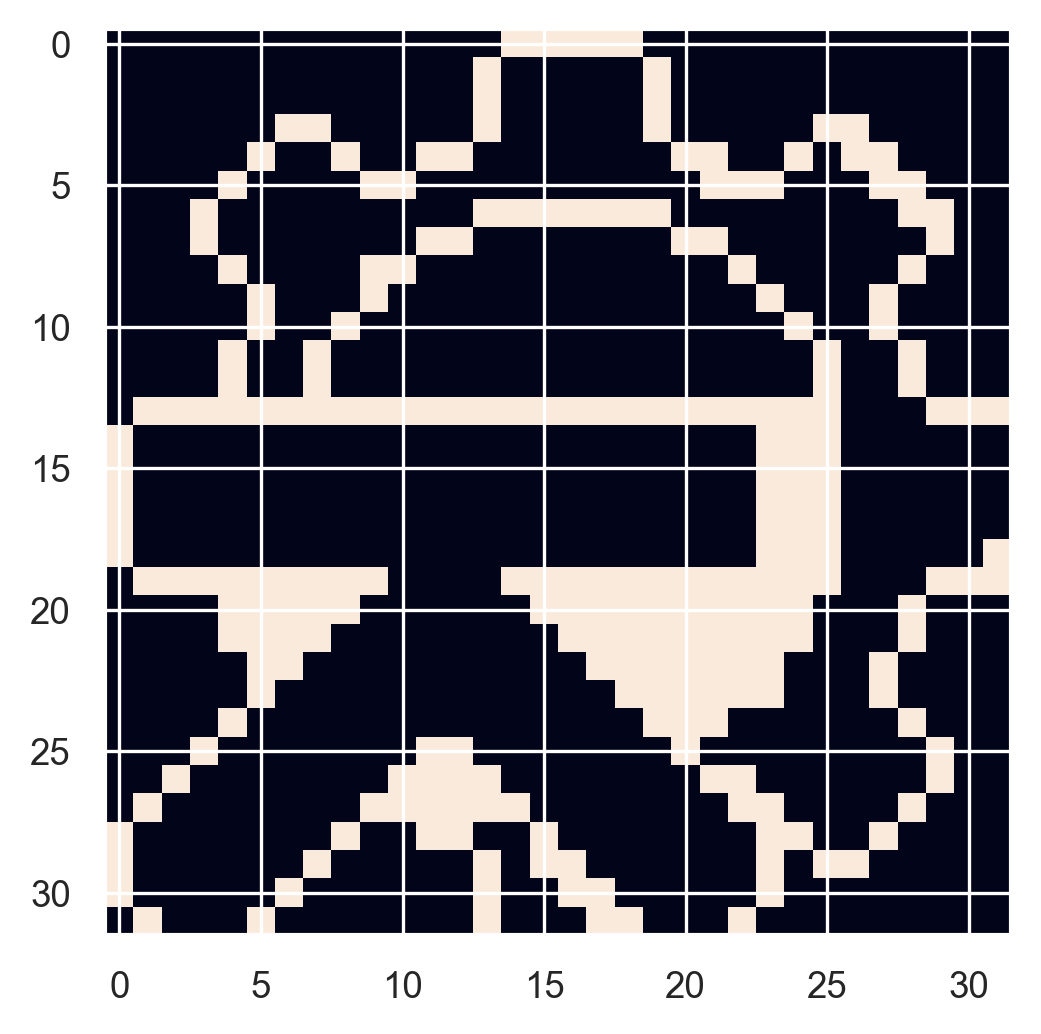

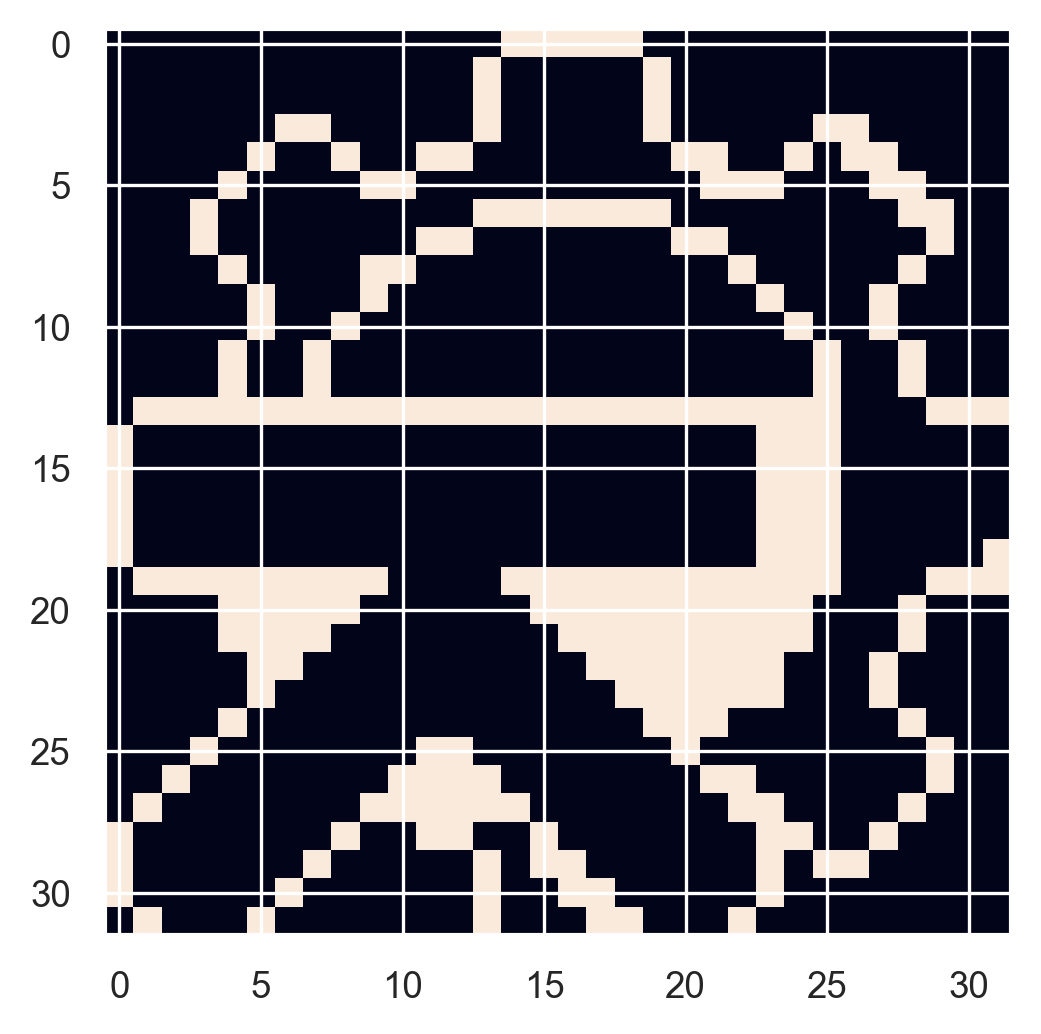

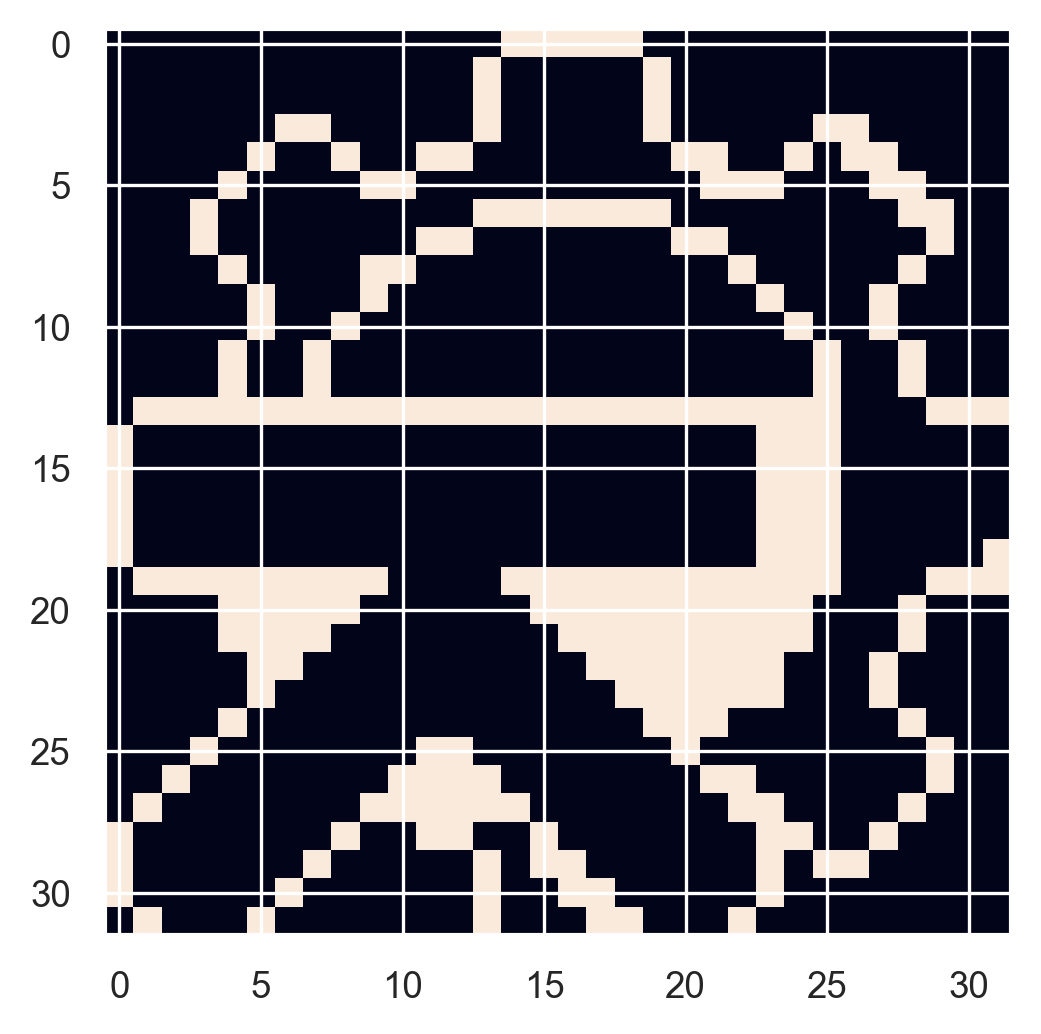

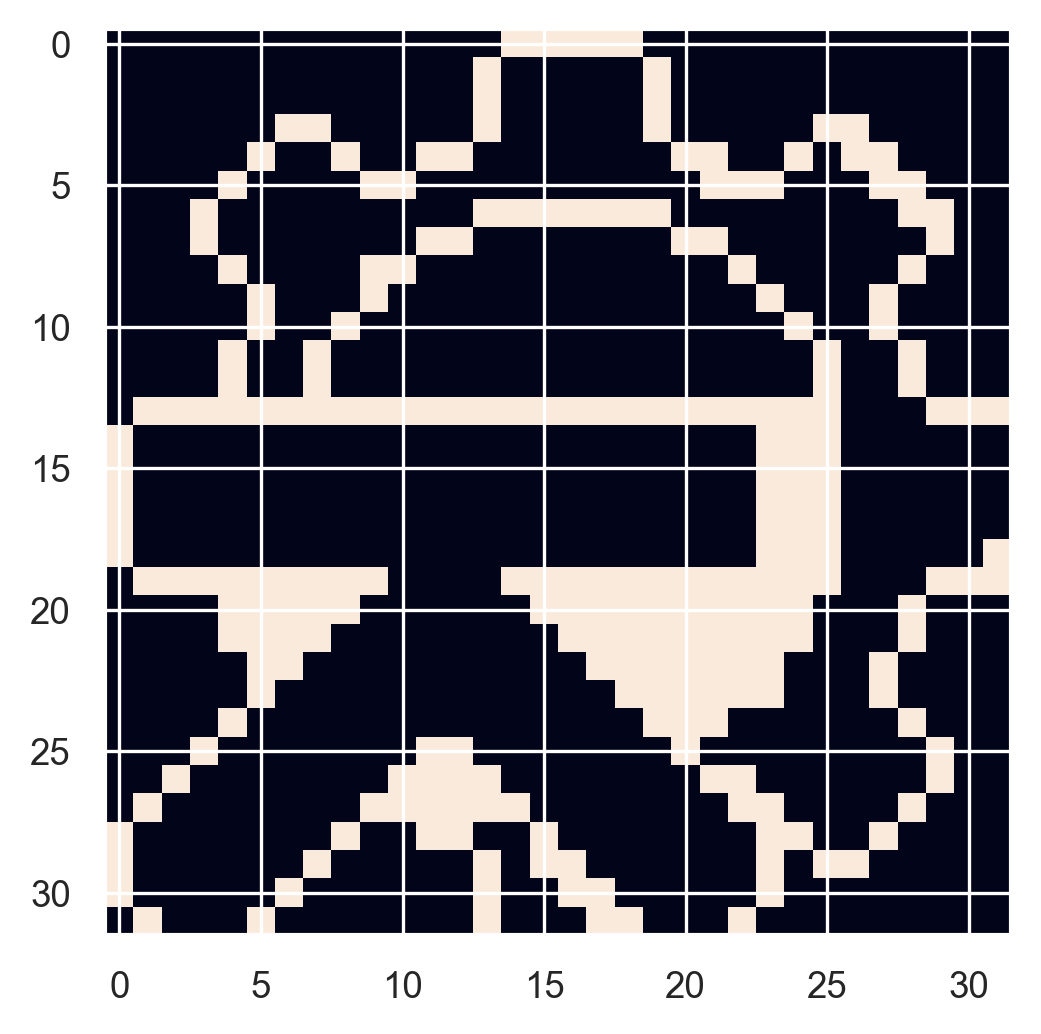

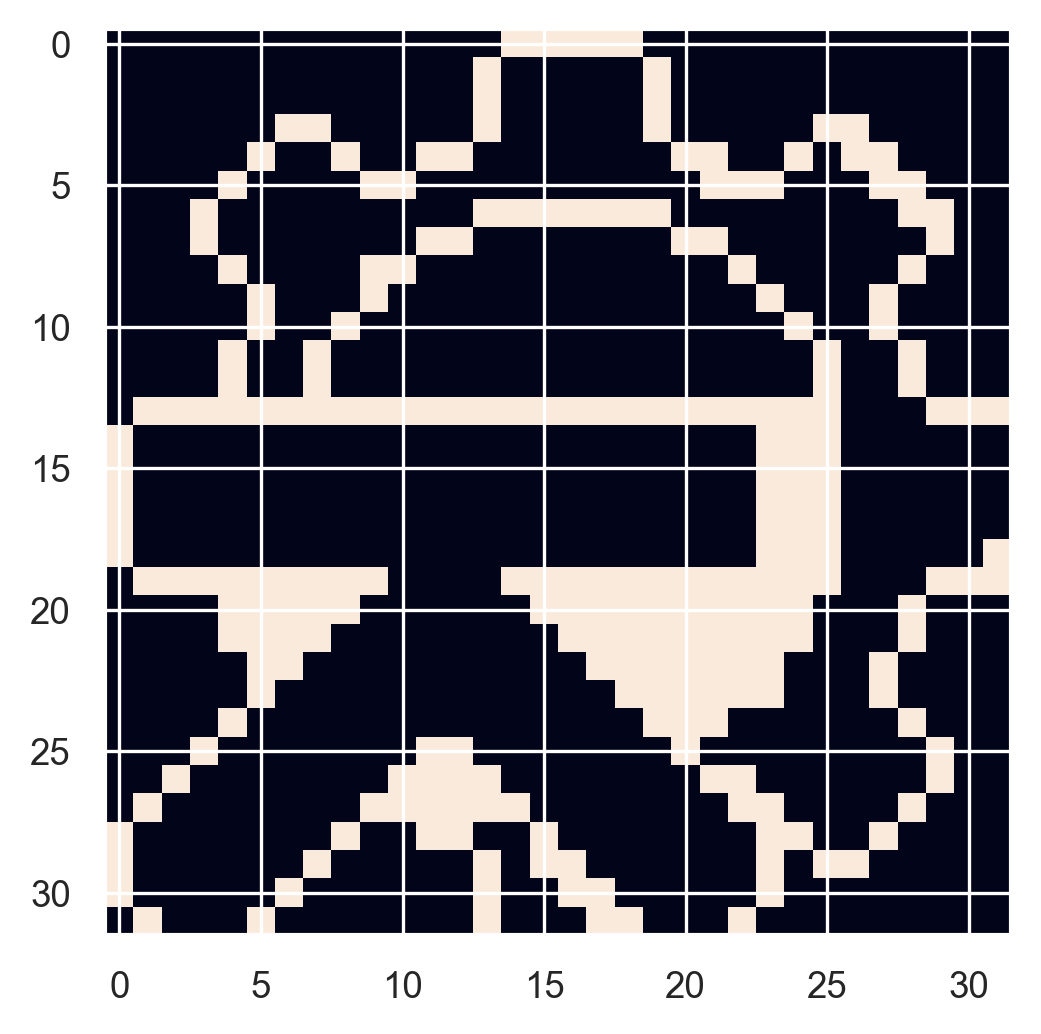

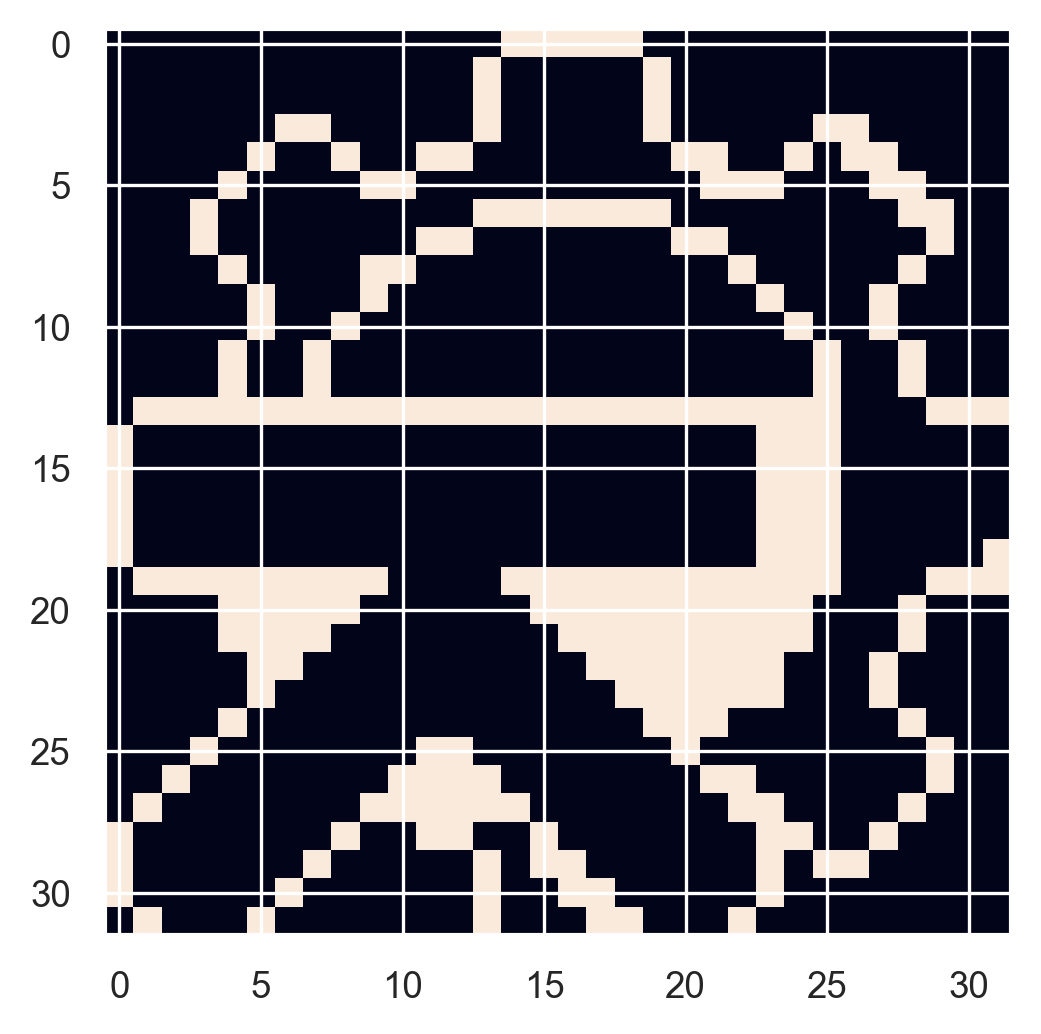

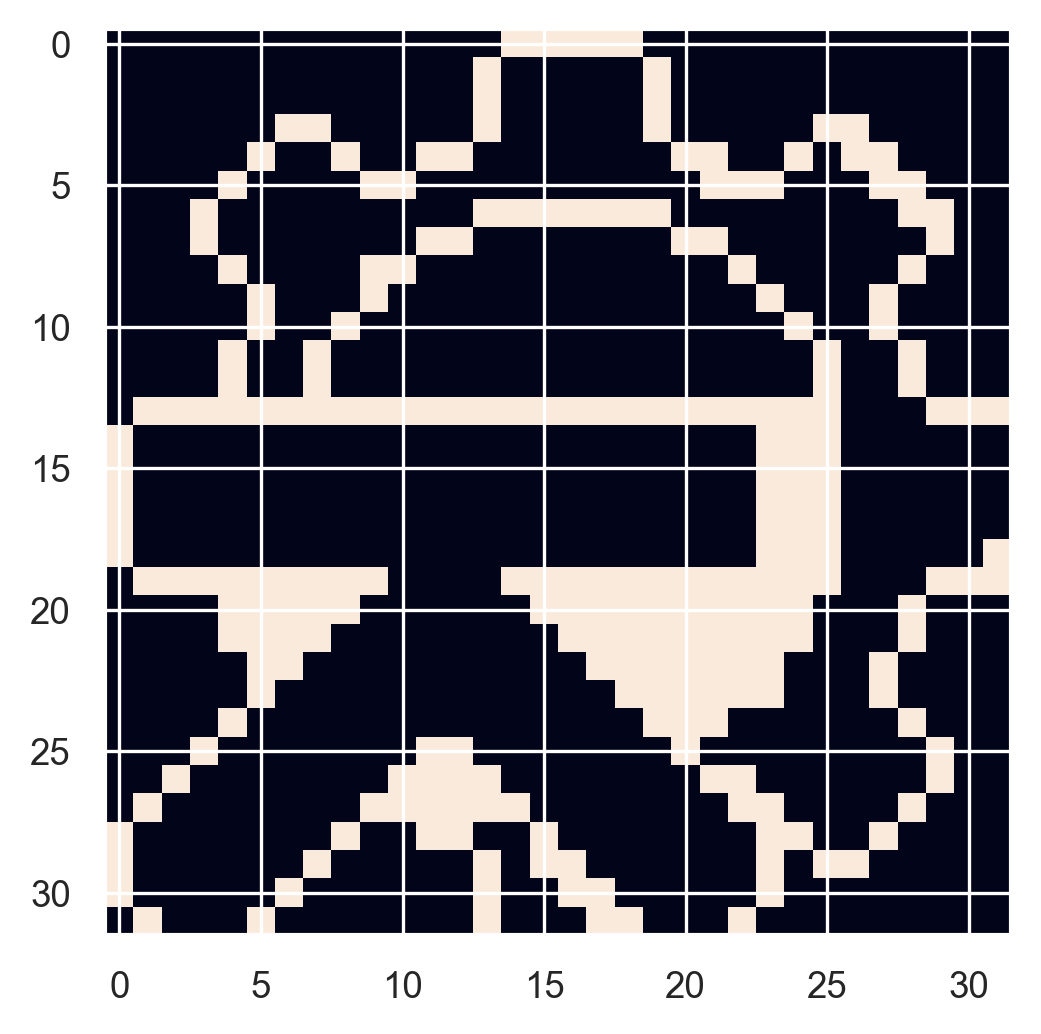

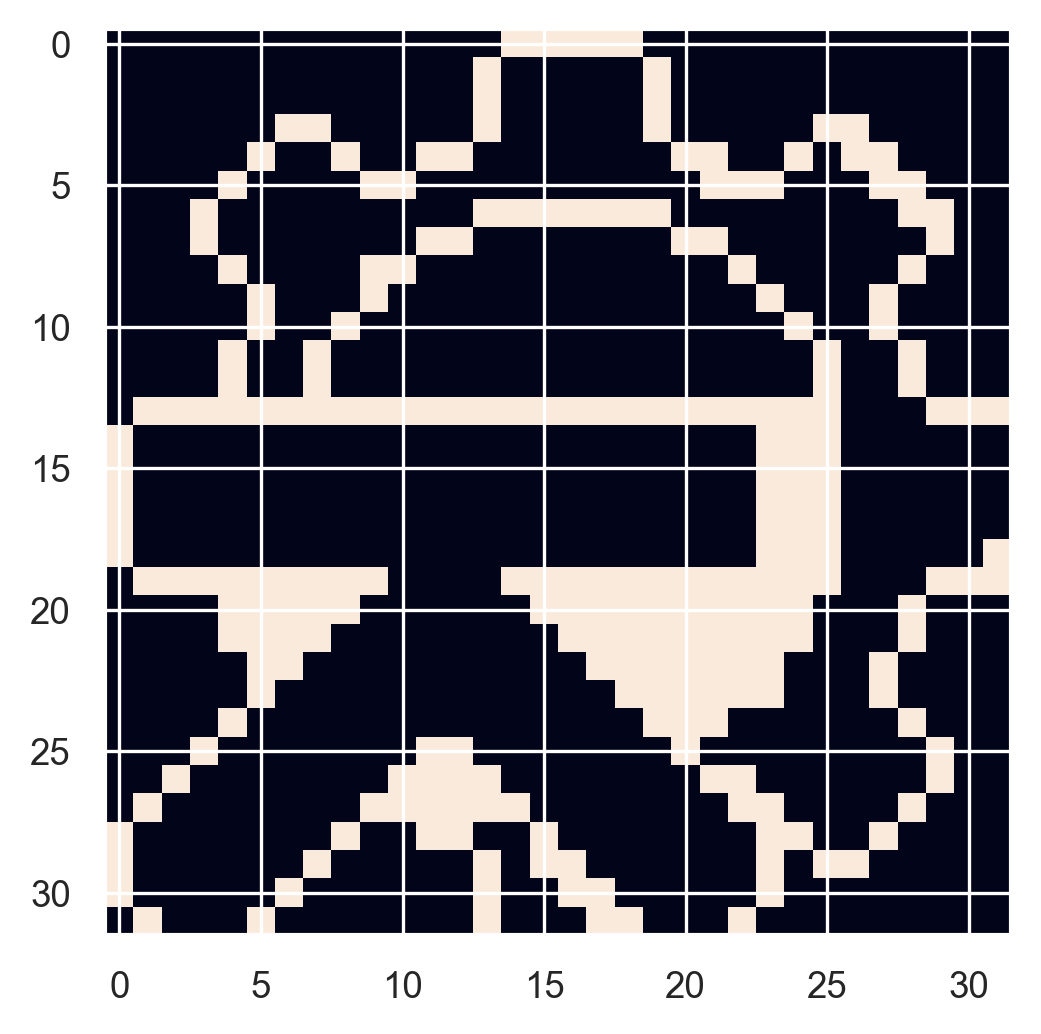

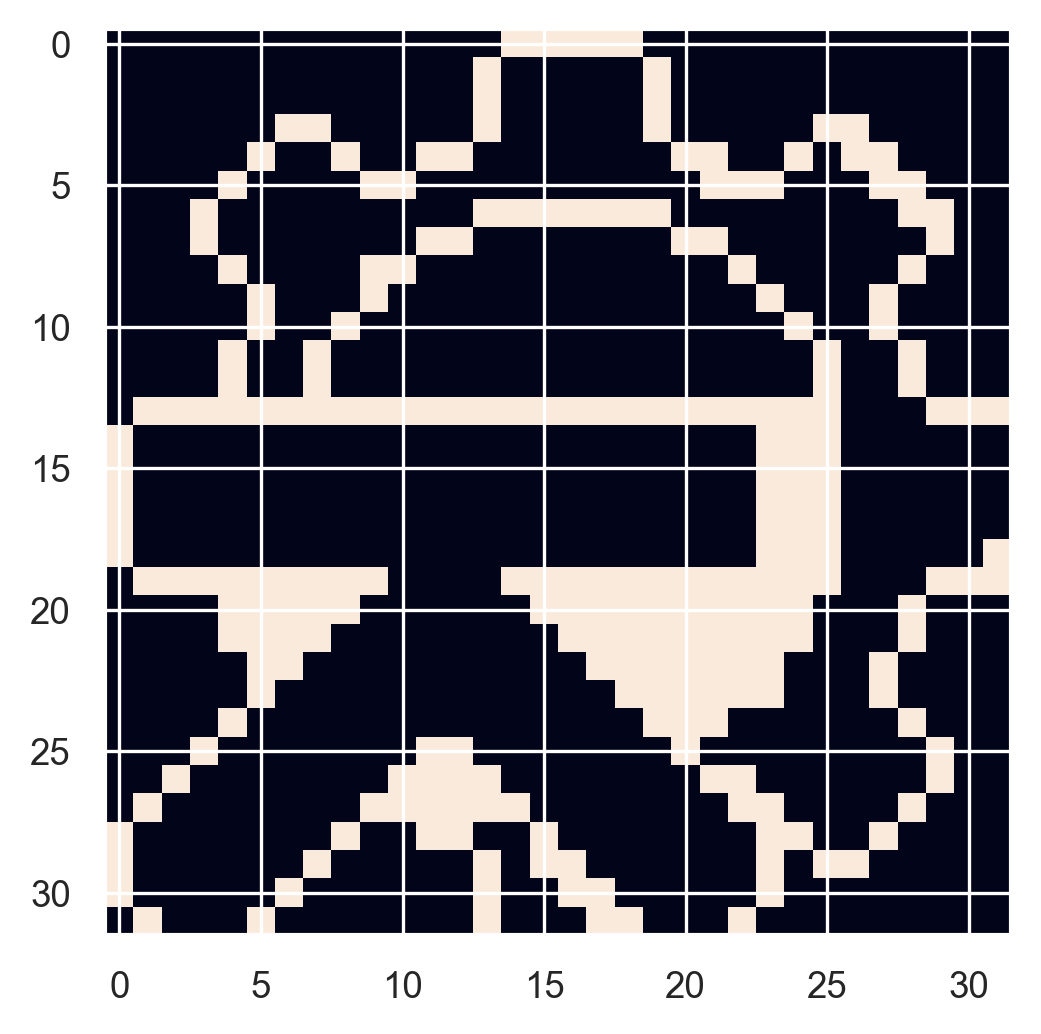

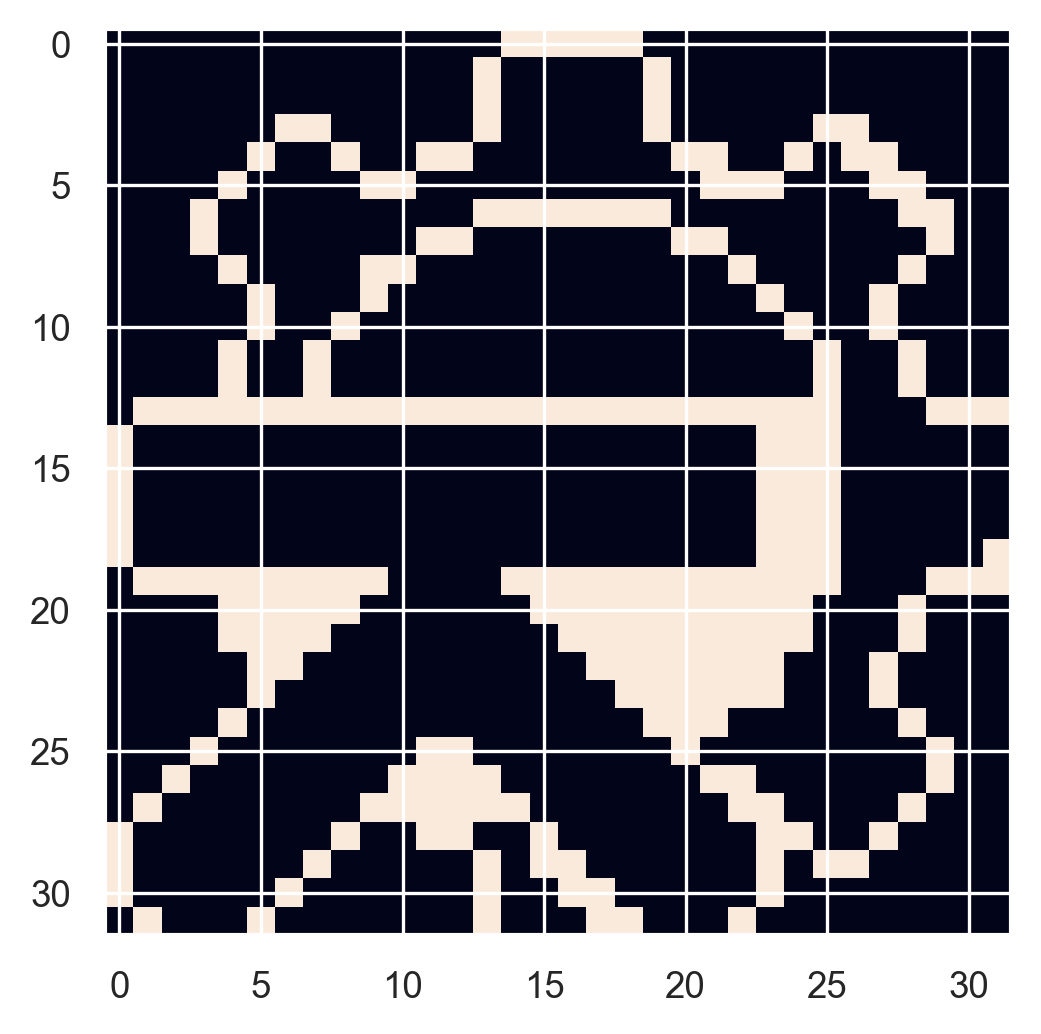

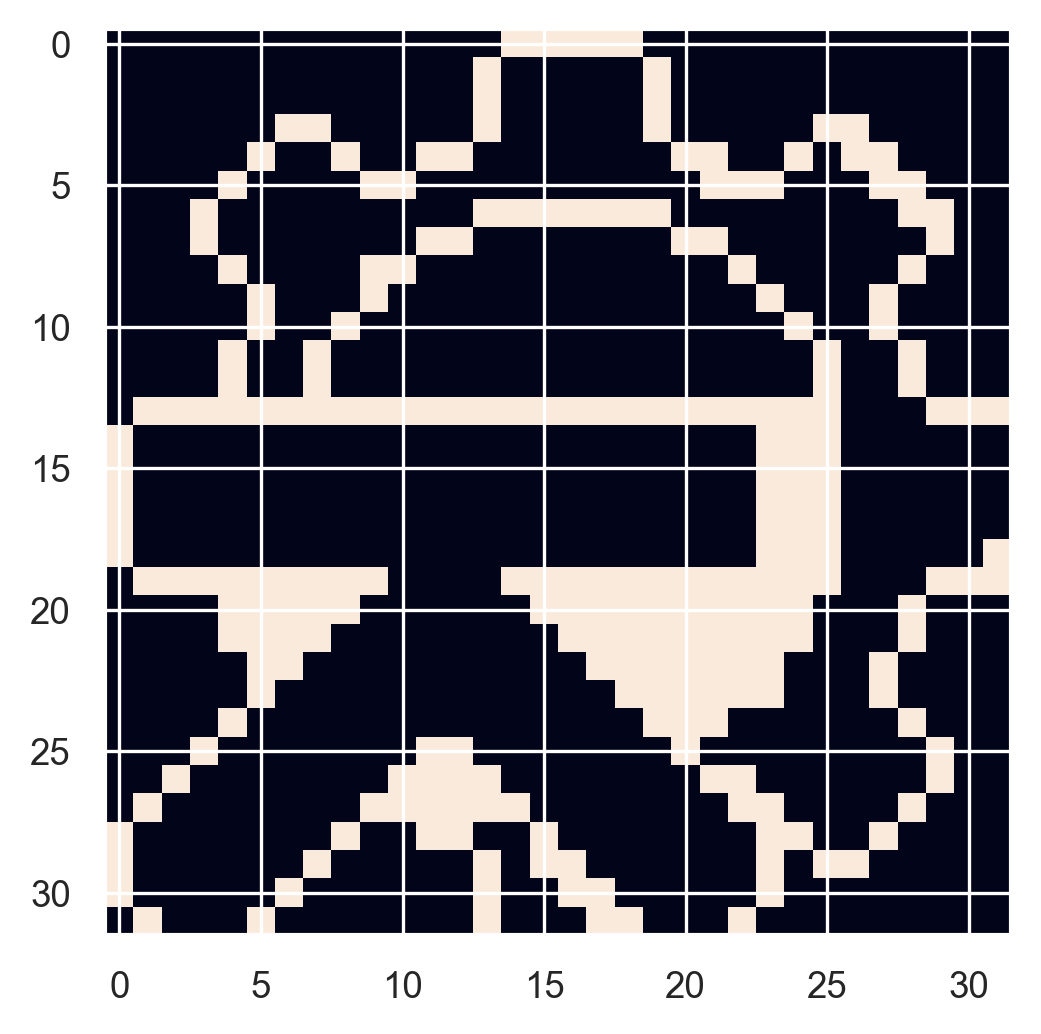

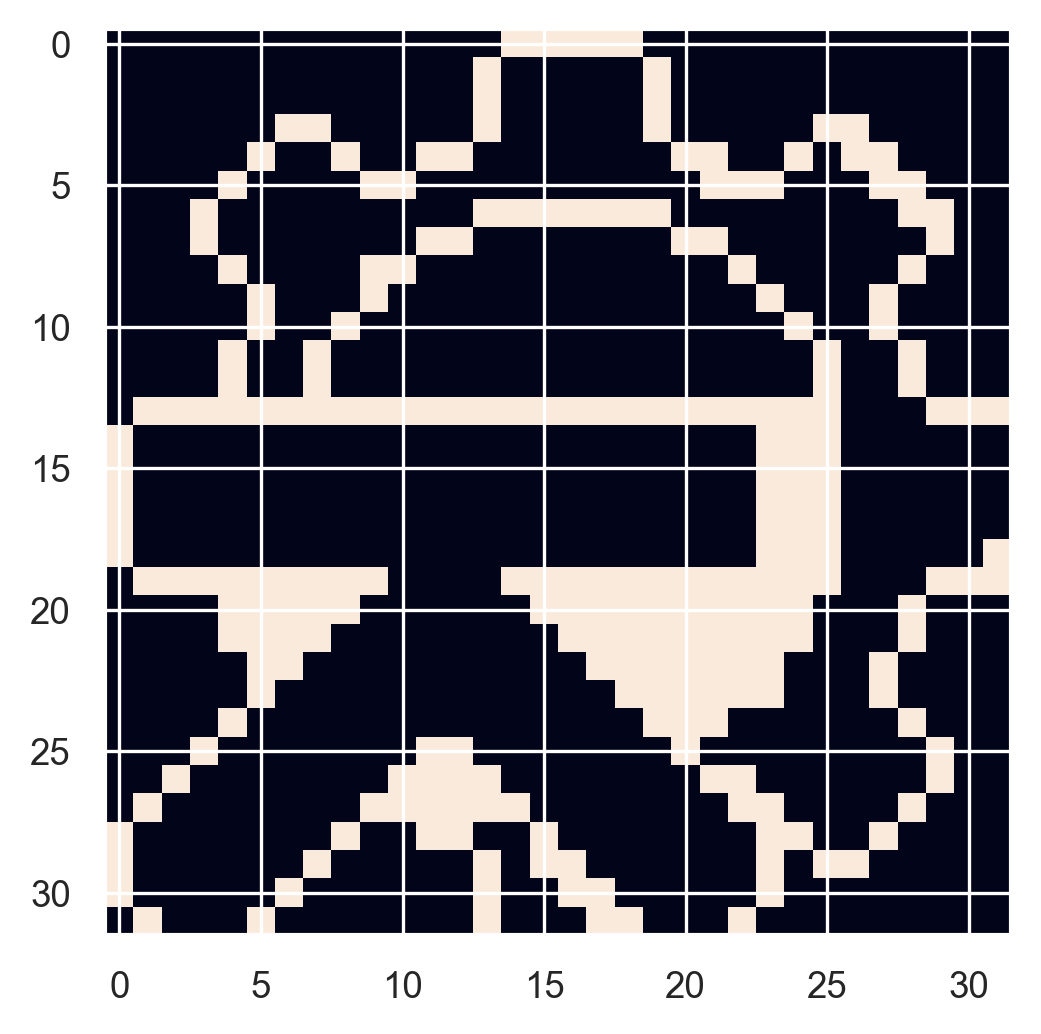

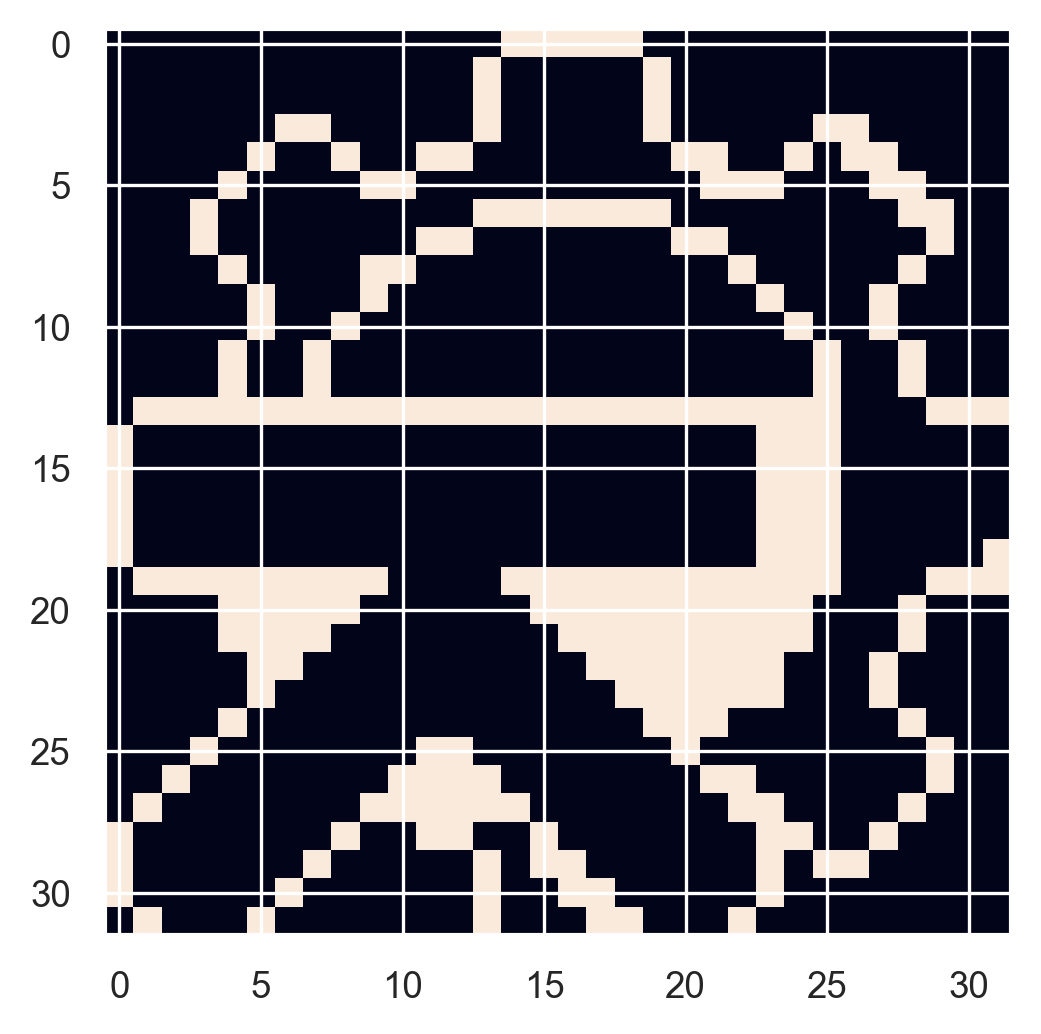

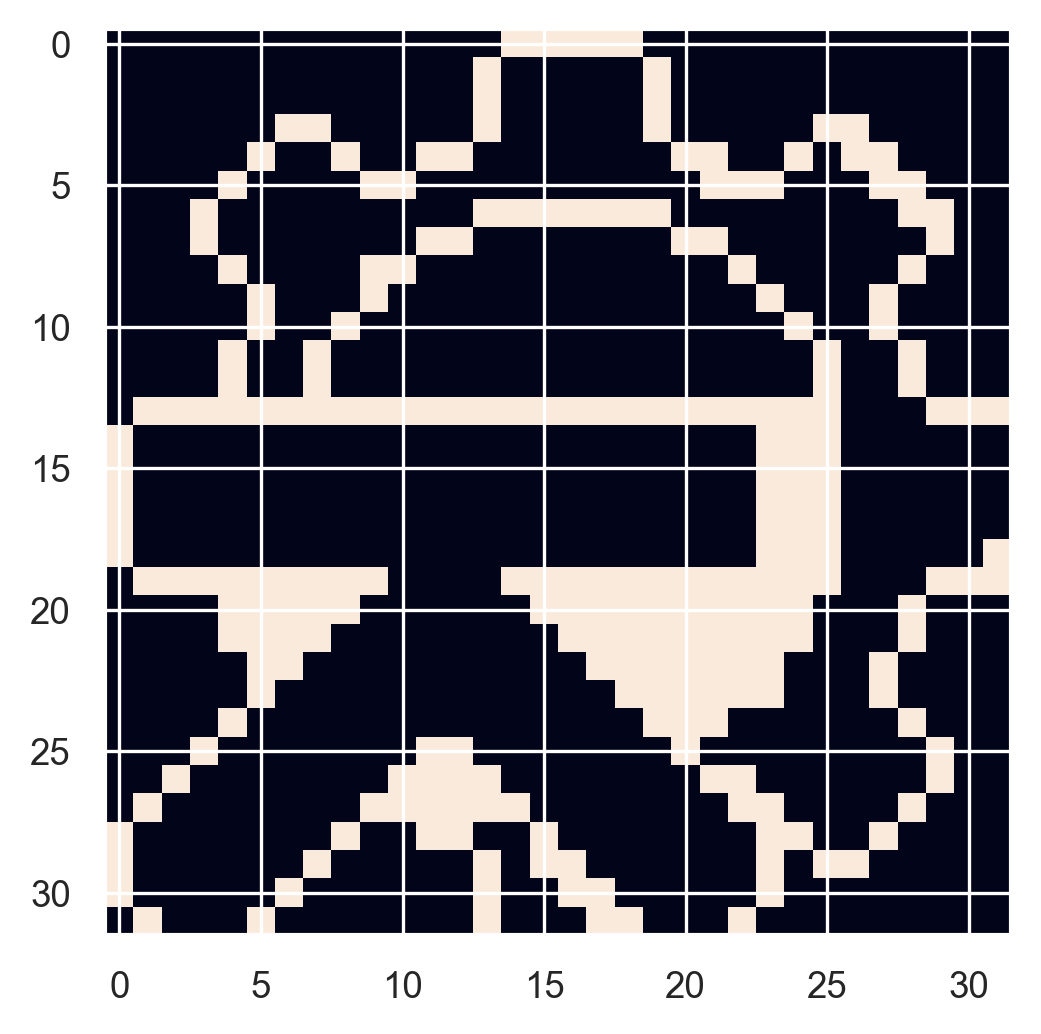

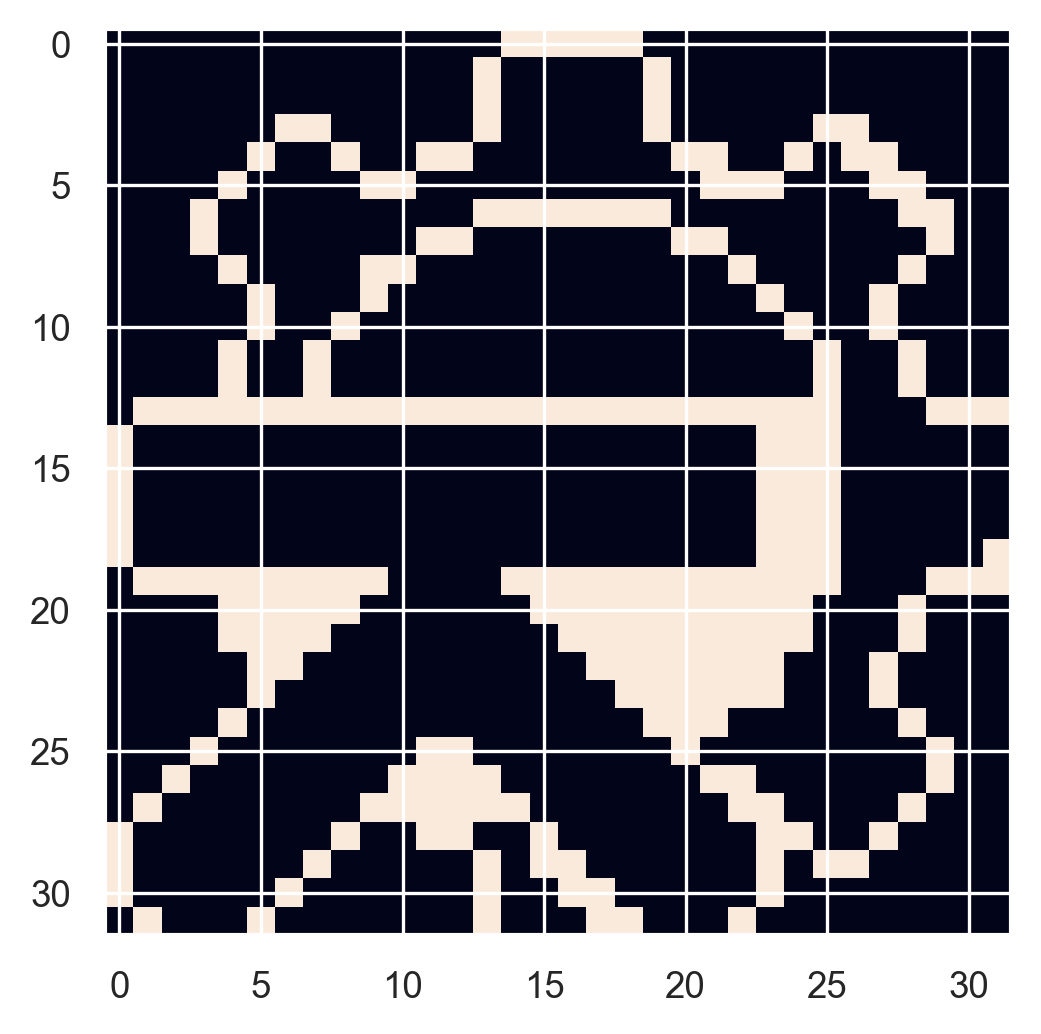

array([[-1., -1., -1., ..., -1., -1., -1.]])

In [4]:
def print_fn(iteration, pattern_index, unit_index, pattern):
    if unit_index % 100 == 0:
        fig, ax = plt.subplots()
        p = pattern.copy().reshape((32, 32))
        ax.imshow(p)
        plt.show()
    
nn.recall(patterns[[10], :], callback=print_fn)

In [10]:
# sparse patterns
def generate_sparse_patterns(xdims: int, activity: float, max_patterns: int = 50) -> np.ndarray:
    # set a limit for how many patterns we grab based on calculating the possible k-combinations (with replacement) of indices 
    # in each sample based on the activity
    
    ones_per_sample = int(np.floor(activity * xdims))
    n_patterns = scipy.special.comb(xdims, ones_per_sample, exact=True)
    n_patterns = min(max_patterns, n_patterns)
    
    X = scipy.sparse.random(n_patterns, xdims, density=activity, random_state=rand_gen, dtype='int32').A
    X[X != 0] = 1
    X_unique = np.unique(X, axis=0)
    while X_unique.shape[0] != n_patterns:
        missing = n_patterns - X_unique.shape[0]
        X_missing = scipy.sparse.random(missing, xdims, density=activity, random_state=rand_gen, dtype='int32').A
        X_missing[X_missing != 0] = 1
        X_unique = np.unique(np.append(X_unique, X_missing, axis=0), axis=0)
        
    return X_unique

In [18]:
def test_sparse(activity: float, xdims: int = 1024) -> pd.DataFrame:
    results = []
    X = generate_sparse_patterns(xdims, activity)
    nn = HopfieldNetwork()
    
    for theta in np.power(10.0, np.arange(-1, 3)):
        for i in range(1, X.shape[0]):
            Xp = X[:i, :]
            nn.train(Xp, sparse=True)
            Xr = nn.recall(Xp, sparse=True, sparse_theta=theta)
            
            error = mean_squared_error(Xp, Xr)
            results.append({
                'theta': theta,
                'n_patterns': i,
                'recall_mse': error
            })
            
            print(f'\rTesting {i} patterns with xdims = {xdims}, theta = {theta} | MSE = {error:0.3f}', end='\t\t\t')
            
    return pd.DataFrame(results)

         
test_sparse(0.2)

Testing 45 patterns with xdims = 1024, theta = 0.1 | MSE = 0.144			

KeyboardInterrupt: 